In [ ]:
!pip install torch seaborn pandas sbi

In [ ]:
!pip install --upgrade tensorflow

In [5]:
import numpy as np
import os
import tensorflow as tf
import torch
import maxent
from sbi_gravitation import GravitySimulator, sim_wrapper, get_observation_points
from torch.distributions.multivariate_normal import MultivariateNormal
from sbi.inference import infer
import scipy

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

np.random.seed(12656)
sns.set_context('paper')
sns.set_style('white',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']

In [54]:
# set up true parameters
m1 = 100. # solar masses
m2 = 50. # solar masses
m3 = 75 # solar masses
G = 1.90809e5 # solar radius / solar mass * (km/s)^2
v0 = np.array([15.,-40.]) # km/s

true_params = [m1, m2, m3, v0[0], v0[1]]

# set prior means
prior_means = [85., 40., 70., 12., -30.]
prior_cov = np.eye(5) * 50

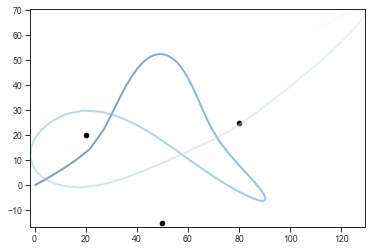

In [55]:
# generate true trajectory and apply some noise to it
if os.path.exists('true_trajectory.txt'):
    true_traj = np.genfromtxt('true_trajectory.txt')
else:
    sim = GravitySimulator(m1, m2, m3, v0, G, random_noise=False)
    true_traj = sim.run()
    np.savetxt('true_trajectory.txt', true_traj)

if os.path.exists('noisy_trajectory.txt'):
    noisy_traj=np.genfromtxt('noisy_trajectory.txt')
else:
    sim = GravitySimulator(m1, m2, m3, v0, G, random_noise=True)
    noisy_traj = sim.run()
    np.savetxt('noisy_trajectory.txt', noisy_traj)

observed_points = get_observation_points(noisy_traj)
observation_summary_stats = observed_points.flatten()
sim = GravitySimulator(m1, m2, m3, v0, G, random_noise=False)
sim.run()
sim.plot_traj()

In [ ]:
# perform SNL inference
prior = MultivariateNormal(loc=torch.as_tensor(prior_means),
                            covariance_matrix=torch.as_tensor(torch.eye(5)*50))

posterior = infer(sim_wrapper, prior, method='SNLE', num_simulations=2048, num_workers=16)

In [ ]:
# sample from SNL posterior
samples = posterior.sample((2000,), x=observation_summary_stats)
snl_data = np.array(samples)
np.savetxt('wide_prior_samples.txt', snl_data)

In [42]:
# set up restraints for maxent
# restraint structure: [value, uncertainty, indices... ]
restraints = []
for i, point in enumerate(observed_points):
    value1 = point[0]
    value2 = point[1]
    uncertainty = 25
    index = 20 * i + 19 # based on how we slice in get_observation_points()
    restraints.append([value1, uncertainty, index, 0])
    restraints.append([value2, uncertainty, index, 1])

In [43]:
# set up laplace restraints
laplace_restraints = []

for i in range(len(restraints)):
    traj_index = tuple(restraints[i][2:])
    value = restraints[i][0]
    uncertainty = restraints[i][1]
    p = maxent.EmptyPrior()
    r = maxent.Restraint(lambda traj, i=traj_index: traj[i], value, p)
    laplace_restraints.append(r)

In [44]:
# sample from prior for maxent
if os.path.exists('maxent_prior_samples.npy'):
    prior_dist = np.load('maxent_prior_samples.npy')
else:
    prior_dist = np.random.multivariate_normal(prior_means, prior_cov, size=2048)
    np.save('maxent_prior_samples.npy', prior_dist)

In [45]:
# generate trajectories for maxent from prior samples
trajs = np.zeros([prior_dist.shape[0], 100, 2])

for i, sample in enumerate(prior_dist):
    m1, m2, m3, v0 = sample[0], sample[1], sample[2], sample[3:]
    sim = GravitySimulator(m1, m2, m3, v0, random_noise=False)
    traj = sim.run()
    trajs[i] = traj
    
maxent_trajs = trajs
np.save('maxent_raw_trajectories.npy', trajs)

In [56]:
# run maxent on trajectories
batch_size = prior_dist.shape[0]

model = maxent.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Adam(1e-4), 'mean_squared_error')
# short burn-in
h = model.fit(trajs, batch_size=batch_size, epochs=5000, verbose=1)
# restart to reset learning rate
h = model.fit(trajs, batch_size=batch_size, epochs=25000, verbose=1)

np.savetxt('maxent_loss.txt', h.history['loss'])

maxent_weights = model.traj_weights
np.savetxt('maxent_traj_weights.txt', maxent_weights)

maxent_avg_traj = np.sum(trajs * maxent_weights[:, np.newaxis, np.newaxis], axis=0)
np.savetxt('maxent_avg_traj.txt', maxent_avg_traj)

Epoch 1/5000
1/1 [==============================] - 0s 356ms/step - loss: 1170.8549 - weight-entropy: 7.6246
Epoch 2/5000
1/1 [==============================] - 0s 2ms/step - loss: 736.3903 - weight-entropy: 7.6202
Epoch 3/5000
1/1 [==============================] - 0s 3ms/step - loss: 817.7186 - weight-entropy: 7.5795
Epoch 4/5000
1/1 [==============================] - 0s 2ms/step - loss: 493.1036 - weight-entropy: 7.6052
Epoch 5/5000
1/1 [==============================] - 0s 4ms/step - loss: 585.2880 - weight-entropy: 7.6147
Epoch 6/5000
1/1 [==============================] - 0s 2ms/step - loss: 654.2595 - weight-entropy: 7.6173
Epoch 7/5000
1/1 [==============================] - 0s 4ms/step - loss: 666.2298 - weight-entropy: 7.6172
Epoch 8/5000
1/1 [==============================] - 0s 3ms/step - loss: 637.8734 - weight-entropy: 7.6153
Epoch 9/5000
1/1 [==============================] - 0s 2ms/step - loss: 591.6251 - weight-entropy: 7.6112
Epoch 10/5000
1/1 [========================

1/1 [==============================] - 0s 2ms/step - loss: 476.3301 - weight-entropy: 7.6034
Epoch 78/5000
1/1 [==============================] - 0s 3ms/step - loss: 476.0543 - weight-entropy: 7.6036
Epoch 79/5000
1/1 [==============================] - 0s 3ms/step - loss: 475.8261 - weight-entropy: 7.6038
Epoch 80/5000
1/1 [==============================] - 0s 3ms/step - loss: 475.5551 - weight-entropy: 7.6038
Epoch 81/5000
1/1 [==============================] - 0s 3ms/step - loss: 475.2423 - weight-entropy: 7.6036
Epoch 82/5000
1/1 [==============================] - 0s 2ms/step - loss: 475.0074 - weight-entropy: 7.6033
Epoch 83/5000
1/1 [==============================] - 0s 2ms/step - loss: 474.8030 - weight-entropy: 7.6032
Epoch 84/5000
1/1 [==============================] - 0s 3ms/step - loss: 474.5410 - weight-entropy: 7.6033
Epoch 85/5000
1/1 [==============================] - 0s 3ms/step - loss: 474.2874 - weight-entropy: 7.6035
Epoch 86/5000
1/1 [==============================] 

1/1 [==============================] - 0s 3ms/step - loss: 454.4515 - weight-entropy: 7.6007
Epoch 154/5000
1/1 [==============================] - 0s 2ms/step - loss: 454.1190 - weight-entropy: 7.6007
Epoch 155/5000
1/1 [==============================] - 0s 3ms/step - loss: 453.7886 - weight-entropy: 7.6006
Epoch 156/5000
1/1 [==============================] - 0s 3ms/step - loss: 453.4536 - weight-entropy: 7.6005
Epoch 157/5000
1/1 [==============================] - 0s 3ms/step - loss: 453.1193 - weight-entropy: 7.6005
Epoch 158/5000
1/1 [==============================] - 0s 2ms/step - loss: 452.7833 - weight-entropy: 7.6004
Epoch 159/5000
1/1 [==============================] - 0s 3ms/step - loss: 452.4470 - weight-entropy: 7.6003
Epoch 160/5000
1/1 [==============================] - 0s 4ms/step - loss: 452.1094 - weight-entropy: 7.6002
Epoch 161/5000
1/1 [==============================] - 0s 2ms/step - loss: 451.7716 - weight-entropy: 7.6002
Epoch 162/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 426.4164 - weight-entropy: 7.5925
Epoch 229/5000
1/1 [==============================] - 0s 3ms/step - loss: 426.0000 - weight-entropy: 7.5924
Epoch 230/5000
1/1 [==============================] - 0s 3ms/step - loss: 425.5804 - weight-entropy: 7.5922
Epoch 231/5000
1/1 [==============================] - 0s 4ms/step - loss: 425.1622 - weight-entropy: 7.5921
Epoch 232/5000
1/1 [==============================] - 0s 4ms/step - loss: 424.7417 - weight-entropy: 7.5919
Epoch 233/5000
1/1 [==============================] - 0s 5ms/step - loss: 424.3197 - weight-entropy: 7.5917
Epoch 234/5000
1/1 [==============================] - 0s 4ms/step - loss: 423.8962 - weight-entropy: 7.5915
Epoch 235/5000
1/1 [==============================] - 0s 5ms/step - loss: 423.4705 - weight-entropy: 7.5914
Epoch 236/5000
1/1 [==============================] - 0s 3ms/step - loss: 423.0463 - weight-entropy: 7.5912
Epoch 237/5000
1/1 [=======================

Epoch 304/5000
1/1 [==============================] - 0s 3ms/step - loss: 391.7710 - weight-entropy: 7.5743
Epoch 305/5000
1/1 [==============================] - 0s 4ms/step - loss: 391.2819 - weight-entropy: 7.5739
Epoch 306/5000
1/1 [==============================] - 0s 3ms/step - loss: 390.7962 - weight-entropy: 7.5736
Epoch 307/5000
1/1 [==============================] - 0s 3ms/step - loss: 390.3052 - weight-entropy: 7.5733
Epoch 308/5000
1/1 [==============================] - 0s 3ms/step - loss: 389.8178 - weight-entropy: 7.5729
Epoch 309/5000
1/1 [==============================] - 0s 3ms/step - loss: 389.3276 - weight-entropy: 7.5726
Epoch 310/5000
1/1 [==============================] - 0s 3ms/step - loss: 388.8361 - weight-entropy: 7.5723
Epoch 311/5000
1/1 [==============================] - 0s 3ms/step - loss: 388.3444 - weight-entropy: 7.5719
Epoch 312/5000
1/1 [==============================] - 0s 3ms/step - loss: 387.8541 - weight-entropy: 7.5716
Epoch 313/5000
1/1 [========

1/1 [==============================] - 0s 4ms/step - loss: 354.8068 - weight-entropy: 7.5426
Epoch 380/5000
1/1 [==============================] - 0s 3ms/step - loss: 354.3225 - weight-entropy: 7.5421
Epoch 381/5000
1/1 [==============================] - 0s 3ms/step - loss: 353.8382 - weight-entropy: 7.5416
Epoch 382/5000
1/1 [==============================] - 0s 3ms/step - loss: 353.3571 - weight-entropy: 7.5411
Epoch 383/5000
1/1 [==============================] - 0s 3ms/step - loss: 352.8743 - weight-entropy: 7.5406
Epoch 384/5000
1/1 [==============================] - 0s 3ms/step - loss: 352.3913 - weight-entropy: 7.5400
Epoch 385/5000
1/1 [==============================] - 0s 4ms/step - loss: 351.9114 - weight-entropy: 7.5395
Epoch 386/5000
1/1 [==============================] - 0s 4ms/step - loss: 351.4297 - weight-entropy: 7.5390
Epoch 387/5000
1/1 [==============================] - 0s 4ms/step - loss: 350.9504 - weight-entropy: 7.5385
Epoch 388/5000
1/1 [=======================

Epoch 455/5000
1/1 [==============================] - 0s 2ms/step - loss: 319.7469 - weight-entropy: 7.4986
Epoch 456/5000
1/1 [==============================] - 0s 3ms/step - loss: 319.3096 - weight-entropy: 7.4980
Epoch 457/5000
1/1 [==============================] - 0s 3ms/step - loss: 318.8742 - weight-entropy: 7.4973
Epoch 458/5000
1/1 [==============================] - 0s 2ms/step - loss: 318.4377 - weight-entropy: 7.4967
Epoch 459/5000
1/1 [==============================] - 0s 4ms/step - loss: 318.0030 - weight-entropy: 7.4960
Epoch 460/5000
1/1 [==============================] - 0s 3ms/step - loss: 317.5701 - weight-entropy: 7.4953
Epoch 461/5000
1/1 [==============================] - 0s 4ms/step - loss: 317.1360 - weight-entropy: 7.4947
Epoch 462/5000
1/1 [==============================] - 0s 3ms/step - loss: 316.7037 - weight-entropy: 7.4940
Epoch 463/5000
1/1 [==============================] - 0s 4ms/step - loss: 316.2728 - weight-entropy: 7.4934
Epoch 464/5000
1/1 [========

1/1 [==============================] - 0s 3ms/step - loss: 289.1321 - weight-entropy: 7.4445
Epoch 531/5000
1/1 [==============================] - 0s 3ms/step - loss: 288.7578 - weight-entropy: 7.4437
Epoch 532/5000
1/1 [==============================] - 0s 3ms/step - loss: 288.3855 - weight-entropy: 7.4429
Epoch 533/5000
1/1 [==============================] - 0s 3ms/step - loss: 288.0128 - weight-entropy: 7.4421
Epoch 534/5000
1/1 [==============================] - 0s 3ms/step - loss: 287.6414 - weight-entropy: 7.4413
Epoch 535/5000
1/1 [==============================] - 0s 3ms/step - loss: 287.2734 - weight-entropy: 7.4405
Epoch 536/5000
1/1 [==============================] - 0s 3ms/step - loss: 286.9054 - weight-entropy: 7.4397
Epoch 537/5000
1/1 [==============================] - 0s 3ms/step - loss: 286.5362 - weight-entropy: 7.4389
Epoch 538/5000
1/1 [==============================] - 0s 3ms/step - loss: 286.1710 - weight-entropy: 7.4381
Epoch 539/5000
1/1 [=======================

Epoch 606/5000
1/1 [==============================] - 0s 3ms/step - loss: 264.0831 - weight-entropy: 7.3822
Epoch 607/5000
1/1 [==============================] - 0s 4ms/step - loss: 263.8018 - weight-entropy: 7.3814
Epoch 608/5000
1/1 [==============================] - 0s 4ms/step - loss: 263.5232 - weight-entropy: 7.3806
Epoch 609/5000
1/1 [==============================] - 0s 2ms/step - loss: 263.2430 - weight-entropy: 7.3798
Epoch 610/5000
1/1 [==============================] - 0s 3ms/step - loss: 262.9657 - weight-entropy: 7.3790
Epoch 611/5000
1/1 [==============================] - 0s 2ms/step - loss: 262.6904 - weight-entropy: 7.3782
Epoch 612/5000
1/1 [==============================] - 0s 3ms/step - loss: 262.4141 - weight-entropy: 7.3773
Epoch 613/5000
1/1 [==============================] - 0s 3ms/step - loss: 262.1406 - weight-entropy: 7.3765
Epoch 614/5000
1/1 [==============================] - 0s 3ms/step - loss: 261.8674 - weight-entropy: 7.3757
Epoch 615/5000
1/1 [========

1/1 [==============================] - 0s 5ms/step - loss: 246.1135 - weight-entropy: 7.3247
Epoch 682/5000
1/1 [==============================] - 0s 3ms/step - loss: 245.9104 - weight-entropy: 7.3240
Epoch 683/5000
1/1 [==============================] - 0s 3ms/step - loss: 245.7080 - weight-entropy: 7.3233
Epoch 684/5000
1/1 [==============================] - 0s 4ms/step - loss: 245.5079 - weight-entropy: 7.3226
Epoch 685/5000
1/1 [==============================] - 0s 2ms/step - loss: 245.3078 - weight-entropy: 7.3219
Epoch 686/5000
1/1 [==============================] - 0s 2ms/step - loss: 245.1084 - weight-entropy: 7.3212
Epoch 687/5000
1/1 [==============================] - 0s 4ms/step - loss: 244.9091 - weight-entropy: 7.3205
Epoch 688/5000
1/1 [==============================] - 0s 4ms/step - loss: 244.7107 - weight-entropy: 7.3198
Epoch 689/5000
1/1 [==============================] - 0s 3ms/step - loss: 244.5125 - weight-entropy: 7.3192
Epoch 690/5000
1/1 [=======================

Epoch 757/5000
1/1 [==============================] - 0s 4ms/step - loss: 232.5050 - weight-entropy: 7.2775
Epoch 758/5000
1/1 [==============================] - 0s 3ms/step - loss: 232.3466 - weight-entropy: 7.2769
Epoch 759/5000
1/1 [==============================] - 0s 3ms/step - loss: 232.1872 - weight-entropy: 7.2764
Epoch 760/5000
1/1 [==============================] - 0s 4ms/step - loss: 232.0276 - weight-entropy: 7.2758
Epoch 761/5000
1/1 [==============================] - 0s 4ms/step - loss: 231.8700 - weight-entropy: 7.2753
Epoch 762/5000
1/1 [==============================] - 0s 4ms/step - loss: 231.7110 - weight-entropy: 7.2747
Epoch 763/5000
1/1 [==============================] - 0s 3ms/step - loss: 231.5539 - weight-entropy: 7.2742
Epoch 764/5000
1/1 [==============================] - 0s 4ms/step - loss: 231.3956 - weight-entropy: 7.2736
Epoch 765/5000
1/1 [==============================] - 0s 3ms/step - loss: 231.2384 - weight-entropy: 7.2731
Epoch 766/5000
1/1 [========

1/1 [==============================] - 0s 3ms/step - loss: 221.4376 - weight-entropy: 7.2400
Epoch 833/5000
1/1 [==============================] - 0s 3ms/step - loss: 221.3007 - weight-entropy: 7.2396
Epoch 834/5000
1/1 [==============================] - 0s 3ms/step - loss: 221.1640 - weight-entropy: 7.2391
Epoch 835/5000
1/1 [==============================] - 0s 2ms/step - loss: 221.0273 - weight-entropy: 7.2387
Epoch 836/5000
1/1 [==============================] - 0s 2ms/step - loss: 220.8906 - weight-entropy: 7.2382
Epoch 837/5000
1/1 [==============================] - 0s 3ms/step - loss: 220.7540 - weight-entropy: 7.2378
Epoch 838/5000
1/1 [==============================] - 0s 3ms/step - loss: 220.6181 - weight-entropy: 7.2373
Epoch 839/5000
1/1 [==============================] - 0s 3ms/step - loss: 220.4816 - weight-entropy: 7.2369
Epoch 840/5000
1/1 [==============================] - 0s 3ms/step - loss: 220.3474 - weight-entropy: 7.2364
Epoch 841/5000
1/1 [=======================

Epoch 908/5000
1/1 [==============================] - 0s 4ms/step - loss: 211.5832 - weight-entropy: 7.2081
Epoch 909/5000
1/1 [==============================] - 0s 4ms/step - loss: 211.4610 - weight-entropy: 7.2077
Epoch 910/5000
1/1 [==============================] - 0s 4ms/step - loss: 211.3387 - weight-entropy: 7.2073
Epoch 911/5000
1/1 [==============================] - 0s 3ms/step - loss: 211.2151 - weight-entropy: 7.2070
Epoch 912/5000
1/1 [==============================] - 0s 3ms/step - loss: 211.0935 - weight-entropy: 7.2066
Epoch 913/5000
1/1 [==============================] - 0s 3ms/step - loss: 210.9715 - weight-entropy: 7.2062
Epoch 914/5000
1/1 [==============================] - 0s 3ms/step - loss: 210.8486 - weight-entropy: 7.2058
Epoch 915/5000
1/1 [==============================] - 0s 4ms/step - loss: 210.7266 - weight-entropy: 7.2054
Epoch 916/5000
1/1 [==============================] - 0s 4ms/step - loss: 210.6054 - weight-entropy: 7.2050
Epoch 917/5000
1/1 [========

1/1 [==============================] - 0s 2ms/step - loss: 202.7490 - weight-entropy: 7.1806
Epoch 984/5000
1/1 [==============================] - 0s 2ms/step - loss: 202.6357 - weight-entropy: 7.1802
Epoch 985/5000
1/1 [==============================] - 0s 3ms/step - loss: 202.5231 - weight-entropy: 7.1799
Epoch 986/5000
1/1 [==============================] - 0s 4ms/step - loss: 202.4101 - weight-entropy: 7.1795
Epoch 987/5000
1/1 [==============================] - 0s 4ms/step - loss: 202.2969 - weight-entropy: 7.1792
Epoch 988/5000
1/1 [==============================] - 0s 3ms/step - loss: 202.1839 - weight-entropy: 7.1789
Epoch 989/5000
1/1 [==============================] - 0s 2ms/step - loss: 202.0715 - weight-entropy: 7.1785
Epoch 990/5000
1/1 [==============================] - 0s 3ms/step - loss: 201.9598 - weight-entropy: 7.1782
Epoch 991/5000
1/1 [==============================] - 0s 3ms/step - loss: 201.8476 - weight-entropy: 7.1778
Epoch 992/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 194.5497 - weight-entropy: 7.1558
Epoch 1059/5000
1/1 [==============================] - 0s 4ms/step - loss: 194.4443 - weight-entropy: 7.1555
Epoch 1060/5000
1/1 [==============================] - 0s 5ms/step - loss: 194.3372 - weight-entropy: 7.1552
Epoch 1061/5000
1/1 [==============================] - 0s 3ms/step - loss: 194.2317 - weight-entropy: 7.1549
Epoch 1062/5000
1/1 [==============================] - 0s 3ms/step - loss: 194.1262 - weight-entropy: 7.1546
Epoch 1063/5000
1/1 [==============================] - 0s 3ms/step - loss: 194.0208 - weight-entropy: 7.1543
Epoch 1064/5000
1/1 [==============================] - 0s 3ms/step - loss: 193.9153 - weight-entropy: 7.1539
Epoch 1065/5000
1/1 [==============================] - 0s 3ms/step - loss: 193.8112 - weight-entropy: 7.1536
Epoch 1066/5000
1/1 [==============================] - 0s 3ms/step - loss: 193.7058 - weight-entropy: 7.1533
Epoch 1067/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 186.8331 - weight-entropy: 7.1331
Epoch 1134/5000
1/1 [==============================] - 0s 4ms/step - loss: 186.7334 - weight-entropy: 7.1328
Epoch 1135/5000
1/1 [==============================] - 0s 3ms/step - loss: 186.6328 - weight-entropy: 7.1325
Epoch 1136/5000
1/1 [==============================] - 0s 3ms/step - loss: 186.5338 - weight-entropy: 7.1322
Epoch 1137/5000
1/1 [==============================] - 0s 3ms/step - loss: 186.4335 - weight-entropy: 7.1319
Epoch 1138/5000
1/1 [==============================] - 0s 3ms/step - loss: 186.3331 - weight-entropy: 7.1317
Epoch 1139/5000
1/1 [==============================] - 0s 3ms/step - loss: 186.2341 - weight-entropy: 7.1314
Epoch 1140/5000
1/1 [==============================] - 0s 5ms/step - loss: 186.1339 - weight-entropy: 7.1311
Epoch 1141/5000
1/1 [==============================] - 0s 4ms/step - loss: 186.0348 - weight-entropy: 7.1308
Epoch 1142/5000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 179.5004 - weight-entropy: 7.1119
Epoch 1209/5000
1/1 [==============================] - 0s 3ms/step - loss: 179.4052 - weight-entropy: 7.1116
Epoch 1210/5000
1/1 [==============================] - 0s 3ms/step - loss: 179.3097 - weight-entropy: 7.1113
Epoch 1211/5000
1/1 [==============================] - 0s 3ms/step - loss: 179.2148 - weight-entropy: 7.1110
Epoch 1212/5000
1/1 [==============================] - 0s 3ms/step - loss: 179.1186 - weight-entropy: 7.1108
Epoch 1213/5000
1/1 [==============================] - 0s 3ms/step - loss: 179.0235 - weight-entropy: 7.1105
Epoch 1214/5000
1/1 [==============================] - 0s 3ms/step - loss: 178.9286 - weight-entropy: 7.1102
Epoch 1215/5000
1/1 [==============================] - 0s 3ms/step - loss: 178.8332 - weight-entropy: 7.1100
Epoch 1216/5000
1/1 [==============================] - 0s 3ms/step - loss: 178.7383 - weight-entropy: 7.1097
Epoch 1217/5000
1/1 [==============

1/1 [==============================] - 0s 5ms/step - loss: 172.5767 - weight-entropy: 7.0919
Epoch 1283/5000
1/1 [==============================] - 0s 3ms/step - loss: 172.4844 - weight-entropy: 7.0917
Epoch 1284/5000
1/1 [==============================] - 0s 3ms/step - loss: 172.3931 - weight-entropy: 7.0914
Epoch 1285/5000
1/1 [==============================] - 0s 3ms/step - loss: 172.3011 - weight-entropy: 7.0911
Epoch 1286/5000
1/1 [==============================] - 0s 2ms/step - loss: 172.2098 - weight-entropy: 7.0909
Epoch 1287/5000
1/1 [==============================] - 0s 2ms/step - loss: 172.1183 - weight-entropy: 7.0906
Epoch 1288/5000
1/1 [==============================] - 0s 4ms/step - loss: 172.0271 - weight-entropy: 7.0903
Epoch 1289/5000
1/1 [==============================] - 0s 4ms/step - loss: 171.9350 - weight-entropy: 7.0901
Epoch 1290/5000
1/1 [==============================] - 0s 3ms/step - loss: 171.8440 - weight-entropy: 7.0898
Epoch 1291/5000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 165.8281 - weight-entropy: 7.0724
Epoch 1358/5000
1/1 [==============================] - 0s 3ms/step - loss: 165.7395 - weight-entropy: 7.0721
Epoch 1359/5000
1/1 [==============================] - 0s 3ms/step - loss: 165.6520 - weight-entropy: 7.0719
Epoch 1360/5000
1/1 [==============================] - 0s 3ms/step - loss: 165.5628 - weight-entropy: 7.0716
Epoch 1361/5000
1/1 [==============================] - 0s 3ms/step - loss: 165.4751 - weight-entropy: 7.0714
Epoch 1362/5000
1/1 [==============================] - 0s 3ms/step - loss: 165.3868 - weight-entropy: 7.0711
Epoch 1363/5000
1/1 [==============================] - 0s 3ms/step - loss: 165.2984 - weight-entropy: 7.0708
Epoch 1364/5000
1/1 [==============================] - 0s 4ms/step - loss: 165.2109 - weight-entropy: 7.0706
Epoch 1365/5000
1/1 [==============================] - 0s 4ms/step - loss: 165.1225 - weight-entropy: 7.0703
Epoch 1366/5000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 159.3206 - weight-entropy: 7.0532
Epoch 1433/5000
1/1 [==============================] - 0s 3ms/step - loss: 159.2356 - weight-entropy: 7.0530
Epoch 1434/5000
1/1 [==============================] - 0s 3ms/step - loss: 159.1509 - weight-entropy: 7.0527
Epoch 1435/5000
1/1 [==============================] - 0s 4ms/step - loss: 159.0652 - weight-entropy: 7.0525
Epoch 1436/5000
1/1 [==============================] - 0s 3ms/step - loss: 158.9804 - weight-entropy: 7.0522
Epoch 1437/5000
1/1 [==============================] - 0s 4ms/step - loss: 158.8949 - weight-entropy: 7.0520
Epoch 1438/5000
1/1 [==============================] - 0s 3ms/step - loss: 158.8101 - weight-entropy: 7.0517
Epoch 1439/5000
1/1 [==============================] - 0s 2ms/step - loss: 158.7253 - weight-entropy: 7.0514
Epoch 1440/5000
1/1 [==============================] - 0s 3ms/step - loss: 158.6405 - weight-entropy: 7.0512
Epoch 1441/5000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 153.0339 - weight-entropy: 7.0342
Epoch 1508/5000
1/1 [==============================] - 0s 4ms/step - loss: 152.9518 - weight-entropy: 7.0340
Epoch 1509/5000
1/1 [==============================] - 0s 3ms/step - loss: 152.8696 - weight-entropy: 7.0337
Epoch 1510/5000
1/1 [==============================] - 0s 3ms/step - loss: 152.7874 - weight-entropy: 7.0335
Epoch 1511/5000
1/1 [==============================] - 0s 4ms/step - loss: 152.7047 - weight-entropy: 7.0332
Epoch 1512/5000
1/1 [==============================] - 0s 3ms/step - loss: 152.6226 - weight-entropy: 7.0330
Epoch 1513/5000
1/1 [==============================] - 0s 3ms/step - loss: 152.5404 - weight-entropy: 7.0327
Epoch 1514/5000
1/1 [==============================] - 0s 3ms/step - loss: 152.4583 - weight-entropy: 7.0324
Epoch 1515/5000
1/1 [==============================] - 0s 4ms/step - loss: 152.3763 - weight-entropy: 7.0322
Epoch 1516/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 147.0329 - weight-entropy: 7.0155
Epoch 1582/5000
1/1 [==============================] - 0s 3ms/step - loss: 146.9532 - weight-entropy: 7.0152
Epoch 1583/5000
1/1 [==============================] - 0s 2ms/step - loss: 146.8736 - weight-entropy: 7.0149
Epoch 1584/5000
1/1 [==============================] - 0s 3ms/step - loss: 146.7934 - weight-entropy: 7.0147
Epoch 1585/5000
1/1 [==============================] - 0s 3ms/step - loss: 146.7145 - weight-entropy: 7.0144
Epoch 1586/5000
1/1 [==============================] - 0s 4ms/step - loss: 146.6345 - weight-entropy: 7.0142
Epoch 1587/5000
1/1 [==============================] - 0s 3ms/step - loss: 146.5548 - weight-entropy: 7.0139
Epoch 1588/5000
1/1 [==============================] - 0s 3ms/step - loss: 146.4753 - weight-entropy: 7.0137
Epoch 1589/5000
1/1 [==============================] - 0s 2ms/step - loss: 146.3959 - weight-entropy: 7.0134
Epoch 1590/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 141.1449 - weight-entropy: 6.9963
Epoch 1657/5000
1/1 [==============================] - 0s 3ms/step - loss: 141.0678 - weight-entropy: 6.9960
Epoch 1658/5000
1/1 [==============================] - 0s 3ms/step - loss: 140.9905 - weight-entropy: 6.9957
Epoch 1659/5000
1/1 [==============================] - 0s 3ms/step - loss: 140.9140 - weight-entropy: 6.9955
Epoch 1660/5000
1/1 [==============================] - 0s 3ms/step - loss: 140.8361 - weight-entropy: 6.9952
Epoch 1661/5000
1/1 [==============================] - 0s 3ms/step - loss: 140.7595 - weight-entropy: 6.9950
Epoch 1662/5000
1/1 [==============================] - 0s 4ms/step - loss: 140.6822 - weight-entropy: 6.9947
Epoch 1663/5000
1/1 [==============================] - 0s 3ms/step - loss: 140.6055 - weight-entropy: 6.9945
Epoch 1664/5000
1/1 [==============================] - 0s 3ms/step - loss: 140.5277 - weight-entropy: 6.9942
Epoch 1665/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 135.4453 - weight-entropy: 6.9768
Epoch 1732/5000
1/1 [==============================] - 0s 2ms/step - loss: 135.3710 - weight-entropy: 6.9765
Epoch 1733/5000
1/1 [==============================] - 0s 3ms/step - loss: 135.2964 - weight-entropy: 6.9763
Epoch 1734/5000
1/1 [==============================] - 0s 3ms/step - loss: 135.2212 - weight-entropy: 6.9760
Epoch 1735/5000
1/1 [==============================] - 0s 3ms/step - loss: 135.1466 - weight-entropy: 6.9757
Epoch 1736/5000
1/1 [==============================] - 0s 2ms/step - loss: 135.0721 - weight-entropy: 6.9755
Epoch 1737/5000
1/1 [==============================] - 0s 3ms/step - loss: 134.9976 - weight-entropy: 6.9752
Epoch 1738/5000
1/1 [==============================] - 0s 3ms/step - loss: 134.9233 - weight-entropy: 6.9749
Epoch 1739/5000
1/1 [==============================] - 0s 3ms/step - loss: 134.8480 - weight-entropy: 6.9747
Epoch 1740/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 129.9281 - weight-entropy: 6.9569
Epoch 1807/5000
1/1 [==============================] - 0s 3ms/step - loss: 129.8558 - weight-entropy: 6.9567
Epoch 1808/5000
1/1 [==============================] - 0s 3ms/step - loss: 129.7836 - weight-entropy: 6.9564
Epoch 1809/5000
1/1 [==============================] - 0s 4ms/step - loss: 129.7113 - weight-entropy: 6.9561
Epoch 1810/5000
1/1 [==============================] - 0s 4ms/step - loss: 129.6391 - weight-entropy: 6.9559
Epoch 1811/5000
1/1 [==============================] - 0s 3ms/step - loss: 129.5668 - weight-entropy: 6.9556
Epoch 1812/5000
1/1 [==============================] - 0s 3ms/step - loss: 129.4946 - weight-entropy: 6.9553
Epoch 1813/5000
1/1 [==============================] - 0s 3ms/step - loss: 129.4223 - weight-entropy: 6.9551
Epoch 1814/5000
1/1 [==============================] - 0s 4ms/step - loss: 129.3501 - weight-entropy: 6.9548
Epoch 1815/5000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 124.6598 - weight-entropy: 6.9369
Epoch 1881/5000
1/1 [==============================] - 0s 3ms/step - loss: 124.5895 - weight-entropy: 6.9366
Epoch 1882/5000
1/1 [==============================] - 0s 3ms/step - loss: 124.5195 - weight-entropy: 6.9363
Epoch 1883/5000
1/1 [==============================] - 0s 5ms/step - loss: 124.4492 - weight-entropy: 6.9361
Epoch 1884/5000
1/1 [==============================] - 0s 4ms/step - loss: 124.3793 - weight-entropy: 6.9358
Epoch 1885/5000
1/1 [==============================] - 0s 3ms/step - loss: 124.3091 - weight-entropy: 6.9355
Epoch 1886/5000
1/1 [==============================] - 0s 3ms/step - loss: 124.2398 - weight-entropy: 6.9352
Epoch 1887/5000
1/1 [==============================] - 0s 2ms/step - loss: 124.1699 - weight-entropy: 6.9350
Epoch 1888/5000
1/1 [==============================] - 0s 3ms/step - loss: 124.0997 - weight-entropy: 6.9347
Epoch 1889/5000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 119.5591 - weight-entropy: 6.9163
Epoch 1955/5000
1/1 [==============================] - 0s 3ms/step - loss: 119.4921 - weight-entropy: 6.9160
Epoch 1956/5000
1/1 [==============================] - 0s 3ms/step - loss: 119.4239 - weight-entropy: 6.9158
Epoch 1957/5000
1/1 [==============================] - 0s 3ms/step - loss: 119.3560 - weight-entropy: 6.9155
Epoch 1958/5000
1/1 [==============================] - 0s 3ms/step - loss: 119.2887 - weight-entropy: 6.9152
Epoch 1959/5000
1/1 [==============================] - 0s 4ms/step - loss: 119.2207 - weight-entropy: 6.9149
Epoch 1960/5000
1/1 [==============================] - 0s 2ms/step - loss: 119.1529 - weight-entropy: 6.9146
Epoch 1961/5000
1/1 [==============================] - 0s 3ms/step - loss: 119.0858 - weight-entropy: 6.9143
Epoch 1962/5000
1/1 [==============================] - 0s 2ms/step - loss: 119.0177 - weight-entropy: 6.9141
Epoch 1963/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 114.5591 - weight-entropy: 6.8949
Epoch 2030/5000
1/1 [==============================] - 0s 3ms/step - loss: 114.4940 - weight-entropy: 6.8946
Epoch 2031/5000
1/1 [==============================] - 0s 4ms/step - loss: 114.4279 - weight-entropy: 6.8943
Epoch 2032/5000
1/1 [==============================] - 0s 3ms/step - loss: 114.3631 - weight-entropy: 6.8940
Epoch 2033/5000
1/1 [==============================] - 0s 4ms/step - loss: 114.2970 - weight-entropy: 6.8937
Epoch 2034/5000
1/1 [==============================] - 0s 3ms/step - loss: 114.2323 - weight-entropy: 6.8934
Epoch 2035/5000
1/1 [==============================] - 0s 3ms/step - loss: 114.1664 - weight-entropy: 6.8932
Epoch 2036/5000
1/1 [==============================] - 0s 3ms/step - loss: 114.1015 - weight-entropy: 6.8929
Epoch 2037/5000
1/1 [==============================] - 0s 3ms/step - loss: 114.0357 - weight-entropy: 6.8926
Epoch 2038/5000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 109.7251 - weight-entropy: 6.8728
Epoch 2105/5000
1/1 [==============================] - 0s 3ms/step - loss: 109.6621 - weight-entropy: 6.8725
Epoch 2106/5000
1/1 [==============================] - 0s 3ms/step - loss: 109.5990 - weight-entropy: 6.8722
Epoch 2107/5000
1/1 [==============================] - 0s 2ms/step - loss: 109.5353 - weight-entropy: 6.8719
Epoch 2108/5000
1/1 [==============================] - 0s 3ms/step - loss: 109.4722 - weight-entropy: 6.8716
Epoch 2109/5000
1/1 [==============================] - 0s 2ms/step - loss: 109.4087 - weight-entropy: 6.8713
Epoch 2110/5000
1/1 [==============================] - 0s 5ms/step - loss: 109.3457 - weight-entropy: 6.8710
Epoch 2111/5000
1/1 [==============================] - 0s 3ms/step - loss: 109.2827 - weight-entropy: 6.8707
Epoch 2112/5000
1/1 [==============================] - 0s 4ms/step - loss: 109.2192 - weight-entropy: 6.8704
Epoch 2113/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 105.0533 - weight-entropy: 6.8501
Epoch 2180/5000
1/1 [==============================] - 0s 3ms/step - loss: 104.9922 - weight-entropy: 6.8497
Epoch 2181/5000
1/1 [==============================] - 0s 3ms/step - loss: 104.9315 - weight-entropy: 6.8494
Epoch 2182/5000
1/1 [==============================] - 0s 3ms/step - loss: 104.8697 - weight-entropy: 6.8491
Epoch 2183/5000
1/1 [==============================] - 0s 2ms/step - loss: 104.8087 - weight-entropy: 6.8488
Epoch 2184/5000
1/1 [==============================] - 0s 4ms/step - loss: 104.7479 - weight-entropy: 6.8485
Epoch 2185/5000
1/1 [==============================] - 0s 3ms/step - loss: 104.6869 - weight-entropy: 6.8482
Epoch 2186/5000
1/1 [==============================] - 0s 4ms/step - loss: 104.6255 - weight-entropy: 6.8479
Epoch 2187/5000
1/1 [==============================] - 0s 3ms/step - loss: 104.5645 - weight-entropy: 6.8476
Epoch 2188/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 100.5991 - weight-entropy: 6.8269
Epoch 2254/5000
1/1 [==============================] - 0s 4ms/step - loss: 100.5396 - weight-entropy: 6.8266
Epoch 2255/5000
1/1 [==============================] - 0s 4ms/step - loss: 100.4806 - weight-entropy: 6.8263
Epoch 2256/5000
1/1 [==============================] - 0s 3ms/step - loss: 100.4218 - weight-entropy: 6.8259
Epoch 2257/5000
1/1 [==============================] - 0s 4ms/step - loss: 100.3627 - weight-entropy: 6.8256
Epoch 2258/5000
1/1 [==============================] - 0s 4ms/step - loss: 100.3033 - weight-entropy: 6.8253
Epoch 2259/5000
1/1 [==============================] - 0s 5ms/step - loss: 100.2443 - weight-entropy: 6.8250
Epoch 2260/5000
1/1 [==============================] - 0s 4ms/step - loss: 100.1855 - weight-entropy: 6.8247
Epoch 2261/5000
1/1 [==============================] - 0s 3ms/step - loss: 100.1265 - weight-entropy: 6.8243
Epoch 2262/5000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 96.2370 - weight-entropy: 6.8027
Epoch 2329/5000
1/1 [==============================] - 0s 3ms/step - loss: 96.1798 - weight-entropy: 6.8023
Epoch 2330/5000
1/1 [==============================] - 0s 4ms/step - loss: 96.1230 - weight-entropy: 6.8020
Epoch 2331/5000
1/1 [==============================] - 0s 4ms/step - loss: 96.0662 - weight-entropy: 6.8017
Epoch 2332/5000
1/1 [==============================] - 0s 3ms/step - loss: 96.0091 - weight-entropy: 6.8014
Epoch 2333/5000
1/1 [==============================] - 0s 3ms/step - loss: 95.9518 - weight-entropy: 6.8010
Epoch 2334/5000
1/1 [==============================] - 0s 3ms/step - loss: 95.8947 - weight-entropy: 6.8007
Epoch 2335/5000
1/1 [==============================] - 0s 3ms/step - loss: 95.8379 - weight-entropy: 6.8004
Epoch 2336/5000
1/1 [==============================] - 0s 3ms/step - loss: 95.7811 - weight-entropy: 6.8000
Epoch 2337/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 92.0254 - weight-entropy: 6.7777
Epoch 2404/5000
1/1 [==============================] - 0s 3ms/step - loss: 91.9705 - weight-entropy: 6.7773
Epoch 2405/5000
1/1 [==============================] - 0s 3ms/step - loss: 91.9153 - weight-entropy: 6.7770
Epoch 2406/5000
1/1 [==============================] - 0s 3ms/step - loss: 91.8595 - weight-entropy: 6.7767
Epoch 2407/5000
1/1 [==============================] - 0s 2ms/step - loss: 91.8048 - weight-entropy: 6.7763
Epoch 2408/5000
1/1 [==============================] - 0s 3ms/step - loss: 91.7499 - weight-entropy: 6.7760
Epoch 2409/5000
1/1 [==============================] - 0s 4ms/step - loss: 91.6948 - weight-entropy: 6.7757
Epoch 2410/5000
1/1 [==============================] - 0s 3ms/step - loss: 91.6399 - weight-entropy: 6.7753
Epoch 2411/5000
1/1 [==============================] - 0s 3ms/step - loss: 91.5846 - weight-entropy: 6.7750
Epoch 2412/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 87.9055 - weight-entropy: 6.7516
Epoch 2480/5000
1/1 [==============================] - 0s 3ms/step - loss: 87.8522 - weight-entropy: 6.7512
Epoch 2481/5000
1/1 [==============================] - 0s 4ms/step - loss: 87.7989 - weight-entropy: 6.7509
Epoch 2482/5000
1/1 [==============================] - 0s 3ms/step - loss: 87.7460 - weight-entropy: 6.7505
Epoch 2483/5000
1/1 [==============================] - 0s 2ms/step - loss: 87.6928 - weight-entropy: 6.7502
Epoch 2484/5000
1/1 [==============================] - 0s 3ms/step - loss: 87.6394 - weight-entropy: 6.7498
Epoch 2485/5000
1/1 [==============================] - 0s 3ms/step - loss: 87.5865 - weight-entropy: 6.7495
Epoch 2486/5000
1/1 [==============================] - 0s 2ms/step - loss: 87.5333 - weight-entropy: 6.7491
Epoch 2487/5000
1/1 [==============================] - 0s 4ms/step - loss: 87.4805 - weight-entropy: 6.7488
Epoch 2488/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 83.9304 - weight-entropy: 6.7247
Epoch 2556/5000
1/1 [==============================] - 0s 2ms/step - loss: 83.8790 - weight-entropy: 6.7243
Epoch 2557/5000
1/1 [==============================] - 0s 4ms/step - loss: 83.8281 - weight-entropy: 6.7240
Epoch 2558/5000
1/1 [==============================] - 0s 3ms/step - loss: 83.7767 - weight-entropy: 6.7236
Epoch 2559/5000
1/1 [==============================] - 0s 3ms/step - loss: 83.7252 - weight-entropy: 6.7232
Epoch 2560/5000
1/1 [==============================] - 0s 3ms/step - loss: 83.6739 - weight-entropy: 6.7229
Epoch 2561/5000
1/1 [==============================] - 0s 2ms/step - loss: 83.6230 - weight-entropy: 6.7225
Epoch 2562/5000
1/1 [==============================] - 0s 3ms/step - loss: 83.5717 - weight-entropy: 6.7222
Epoch 2563/5000
1/1 [==============================] - 0s 3ms/step - loss: 83.5203 - weight-entropy: 6.7218
Epoch 2564/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 80.0957 - weight-entropy: 6.6970
Epoch 2632/5000
1/1 [==============================] - 0s 3ms/step - loss: 80.0467 - weight-entropy: 6.6966
Epoch 2633/5000
1/1 [==============================] - 0s 2ms/step - loss: 79.9968 - weight-entropy: 6.6963
Epoch 2634/5000
1/1 [==============================] - 0s 2ms/step - loss: 79.9473 - weight-entropy: 6.6959
Epoch 2635/5000
1/1 [==============================] - 0s 3ms/step - loss: 79.8979 - weight-entropy: 6.6955
Epoch 2636/5000
1/1 [==============================] - 0s 3ms/step - loss: 79.8484 - weight-entropy: 6.6952
Epoch 2637/5000
1/1 [==============================] - 0s 4ms/step - loss: 79.7990 - weight-entropy: 6.6948
Epoch 2638/5000
1/1 [==============================] - 0s 3ms/step - loss: 79.7498 - weight-entropy: 6.6944
Epoch 2639/5000
1/1 [==============================] - 0s 2ms/step - loss: 79.7004 - weight-entropy: 6.6940
Epoch 2640/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 76.4453 - weight-entropy: 6.6690
Epoch 2707/5000
1/1 [==============================] - 0s 3ms/step - loss: 76.3973 - weight-entropy: 6.6686
Epoch 2708/5000
1/1 [==============================] - 0s 3ms/step - loss: 76.3496 - weight-entropy: 6.6682
Epoch 2709/5000
1/1 [==============================] - 0s 2ms/step - loss: 76.3019 - weight-entropy: 6.6678
Epoch 2710/5000
1/1 [==============================] - 0s 4ms/step - loss: 76.2541 - weight-entropy: 6.6674
Epoch 2711/5000
1/1 [==============================] - 0s 4ms/step - loss: 76.2064 - weight-entropy: 6.6671
Epoch 2712/5000
1/1 [==============================] - 0s 4ms/step - loss: 76.1588 - weight-entropy: 6.6667
Epoch 2713/5000
1/1 [==============================] - 0s 3ms/step - loss: 76.1113 - weight-entropy: 6.6663
Epoch 2714/5000
1/1 [==============================] - 0s 3ms/step - loss: 76.0633 - weight-entropy: 6.6659
Epoch 2715/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 72.8768 - weight-entropy: 6.6398
Epoch 2783/5000
1/1 [==============================] - 0s 3ms/step - loss: 72.8303 - weight-entropy: 6.6394
Epoch 2784/5000
1/1 [==============================] - 0s 2ms/step - loss: 72.7845 - weight-entropy: 6.6390
Epoch 2785/5000
1/1 [==============================] - 0s 2ms/step - loss: 72.7383 - weight-entropy: 6.6387
Epoch 2786/5000
1/1 [==============================] - 0s 3ms/step - loss: 72.6925 - weight-entropy: 6.6383
Epoch 2787/5000
1/1 [==============================] - 0s 2ms/step - loss: 72.6465 - weight-entropy: 6.6379
Epoch 2788/5000
1/1 [==============================] - 0s 3ms/step - loss: 72.6004 - weight-entropy: 6.6375
Epoch 2789/5000
1/1 [==============================] - 0s 4ms/step - loss: 72.5546 - weight-entropy: 6.6371
Epoch 2790/5000
1/1 [==============================] - 0s 2ms/step - loss: 72.5086 - weight-entropy: 6.6367
Epoch 2791/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 69.4805 - weight-entropy: 6.6104
Epoch 2858/5000
1/1 [==============================] - 0s 2ms/step - loss: 69.4363 - weight-entropy: 6.6100
Epoch 2859/5000
1/1 [==============================] - 0s 2ms/step - loss: 69.3918 - weight-entropy: 6.6096
Epoch 2860/5000
1/1 [==============================] - 0s 3ms/step - loss: 69.3475 - weight-entropy: 6.6092
Epoch 2861/5000
1/1 [==============================] - 0s 3ms/step - loss: 69.3029 - weight-entropy: 6.6088
Epoch 2862/5000
1/1 [==============================] - 0s 3ms/step - loss: 69.2587 - weight-entropy: 6.6084
Epoch 2863/5000
1/1 [==============================] - 0s 4ms/step - loss: 69.2146 - weight-entropy: 6.6080
Epoch 2864/5000
1/1 [==============================] - 0s 2ms/step - loss: 69.1699 - weight-entropy: 6.6076
Epoch 2865/5000
1/1 [==============================] - 0s 3ms/step - loss: 69.1257 - weight-entropy: 6.6072
Epoch 2866/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 66.1630 - weight-entropy: 6.5800
Epoch 2934/5000
1/1 [==============================] - 0s 3ms/step - loss: 66.1201 - weight-entropy: 6.5795
Epoch 2935/5000
1/1 [==============================] - 0s 3ms/step - loss: 66.0772 - weight-entropy: 6.5791
Epoch 2936/5000
1/1 [==============================] - 0s 3ms/step - loss: 66.0344 - weight-entropy: 6.5787
Epoch 2937/5000
1/1 [==============================] - 0s 2ms/step - loss: 65.9915 - weight-entropy: 6.5783
Epoch 2938/5000
1/1 [==============================] - 0s 3ms/step - loss: 65.9490 - weight-entropy: 6.5779
Epoch 2939/5000
1/1 [==============================] - 0s 4ms/step - loss: 65.9062 - weight-entropy: 6.5775
Epoch 2940/5000
1/1 [==============================] - 0s 3ms/step - loss: 65.8633 - weight-entropy: 6.5771
Epoch 2941/5000
1/1 [==============================] - 0s 4ms/step - loss: 65.8205 - weight-entropy: 6.5767
Epoch 2942/5000
1/1 [=======================

Epoch 3009/5000
1/1 [==============================] - 0s 4ms/step - loss: 62.9661 - weight-entropy: 6.5489
Epoch 3010/5000
1/1 [==============================] - 0s 3ms/step - loss: 62.9249 - weight-entropy: 6.5485
Epoch 3011/5000
1/1 [==============================] - 0s 3ms/step - loss: 62.8837 - weight-entropy: 6.5481
Epoch 3012/5000
1/1 [==============================] - 0s 3ms/step - loss: 62.8425 - weight-entropy: 6.5477
Epoch 3013/5000
1/1 [==============================] - 0s 4ms/step - loss: 62.8010 - weight-entropy: 6.5473
Epoch 3014/5000
1/1 [==============================] - 0s 4ms/step - loss: 62.7598 - weight-entropy: 6.5469
Epoch 3015/5000
1/1 [==============================] - 0s 3ms/step - loss: 62.7188 - weight-entropy: 6.5464
Epoch 3016/5000
1/1 [==============================] - 0s 2ms/step - loss: 62.6777 - weight-entropy: 6.5460
Epoch 3017/5000
1/1 [==============================] - 0s 3ms/step - loss: 62.6367 - weight-entropy: 6.5456
Epoch 3018/5000
1/1 [=======

1/1 [==============================] - 0s 3ms/step - loss: 59.9268 - weight-entropy: 6.5178
Epoch 3085/5000
1/1 [==============================] - 0s 4ms/step - loss: 59.8870 - weight-entropy: 6.5174
Epoch 3086/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.8476 - weight-entropy: 6.5169
Epoch 3087/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.8076 - weight-entropy: 6.5165
Epoch 3088/5000
1/1 [==============================] - 0s 2ms/step - loss: 59.7678 - weight-entropy: 6.5161
Epoch 3089/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.7285 - weight-entropy: 6.5157
Epoch 3090/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.6885 - weight-entropy: 6.5153
Epoch 3091/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.6492 - weight-entropy: 6.5148
Epoch 3092/5000
1/1 [==============================] - 0s 4ms/step - loss: 59.6094 - weight-entropy: 6.5144
Epoch 3093/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 56.9997 - weight-entropy: 6.4861
Epoch 3160/5000
1/1 [==============================] - 0s 3ms/step - loss: 56.9612 - weight-entropy: 6.4857
Epoch 3161/5000
1/1 [==============================] - 0s 3ms/step - loss: 56.9231 - weight-entropy: 6.4853
Epoch 3162/5000
1/1 [==============================] - 0s 3ms/step - loss: 56.8848 - weight-entropy: 6.4849
Epoch 3163/5000
1/1 [==============================] - 0s 3ms/step - loss: 56.8467 - weight-entropy: 6.4844
Epoch 3164/5000
1/1 [==============================] - 0s 3ms/step - loss: 56.8085 - weight-entropy: 6.4840
Epoch 3165/5000
1/1 [==============================] - 0s 3ms/step - loss: 56.7705 - weight-entropy: 6.4836
Epoch 3166/5000
1/1 [==============================] - 0s 3ms/step - loss: 56.7322 - weight-entropy: 6.4832
Epoch 3167/5000
1/1 [==============================] - ETA: 0s - loss: 56.6941 - weight-entropy: 6.482 - 0s 2ms/step - loss: 56.6941 - weight-entropy: 6

1/1 [==============================] - 0s 4ms/step - loss: 54.1819 - weight-entropy: 6.4541
Epoch 3235/5000
1/1 [==============================] - 0s 3ms/step - loss: 54.1452 - weight-entropy: 6.4537
Epoch 3236/5000
1/1 [==============================] - 0s 3ms/step - loss: 54.1084 - weight-entropy: 6.4533
Epoch 3237/5000
1/1 [==============================] - 0s 2ms/step - loss: 54.0714 - weight-entropy: 6.4528
Epoch 3238/5000
1/1 [==============================] - 0s 3ms/step - loss: 54.0345 - weight-entropy: 6.4524
Epoch 3239/5000
1/1 [==============================] - 0s 3ms/step - loss: 53.9980 - weight-entropy: 6.4520
Epoch 3240/5000
1/1 [==============================] - 0s 3ms/step - loss: 53.9610 - weight-entropy: 6.4515
Epoch 3241/5000
1/1 [==============================] - 0s 3ms/step - loss: 53.9246 - weight-entropy: 6.4511
Epoch 3242/5000
1/1 [==============================] - 0s 3ms/step - loss: 53.8877 - weight-entropy: 6.4507
Epoch 3243/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 51.4358 - weight-entropy: 6.4213
Epoch 3311/5000
1/1 [==============================] - 0s 2ms/step - loss: 51.4004 - weight-entropy: 6.4208
Epoch 3312/5000
1/1 [==============================] - 0s 3ms/step - loss: 51.3652 - weight-entropy: 6.4204
Epoch 3313/5000
1/1 [==============================] - 0s 2ms/step - loss: 51.3298 - weight-entropy: 6.4200
Epoch 3314/5000
1/1 [==============================] - 0s 2ms/step - loss: 51.2940 - weight-entropy: 6.4195
Epoch 3315/5000
1/1 [==============================] - 0s 3ms/step - loss: 51.2589 - weight-entropy: 6.4191
Epoch 3316/5000
1/1 [==============================] - 0s 4ms/step - loss: 51.2236 - weight-entropy: 6.4187
Epoch 3317/5000
1/1 [==============================] - 0s 2ms/step - loss: 51.1884 - weight-entropy: 6.4182
Epoch 3318/5000
1/1 [==============================] - 0s 3ms/step - loss: 51.1531 - weight-entropy: 6.4178
Epoch 3319/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 48.8311 - weight-entropy: 6.3886
Epoch 3386/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.7972 - weight-entropy: 6.3881
Epoch 3387/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.7634 - weight-entropy: 6.3877
Epoch 3388/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.7294 - weight-entropy: 6.3872
Epoch 3389/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.6953 - weight-entropy: 6.3868
Epoch 3390/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.6612 - weight-entropy: 6.3864
Epoch 3391/5000
1/1 [==============================] - 0s 4ms/step - loss: 48.6273 - weight-entropy: 6.3859
Epoch 3392/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.5935 - weight-entropy: 6.3855
Epoch 3393/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.5596 - weight-entropy: 6.3851
Epoch 3394/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 46.2969 - weight-entropy: 6.3551
Epoch 3462/5000
1/1 [==============================] - 0s 3ms/step - loss: 46.2640 - weight-entropy: 6.3547
Epoch 3463/5000
1/1 [==============================] - 0s 3ms/step - loss: 46.2314 - weight-entropy: 6.3543
Epoch 3464/5000
1/1 [==============================] - 0s 2ms/step - loss: 46.1989 - weight-entropy: 6.3538
Epoch 3465/5000
1/1 [==============================] - 0s 3ms/step - loss: 46.1663 - weight-entropy: 6.3534
Epoch 3466/5000
1/1 [==============================] - 0s 4ms/step - loss: 46.1337 - weight-entropy: 6.3529
Epoch 3467/5000
1/1 [==============================] - 0s 4ms/step - loss: 46.1012 - weight-entropy: 6.3525
Epoch 3468/5000
1/1 [==============================] - 0s 2ms/step - loss: 46.0684 - weight-entropy: 6.3521
Epoch 3469/5000
1/1 [==============================] - 0s 3ms/step - loss: 46.0360 - weight-entropy: 6.3516
Epoch 3470/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 43.8653 - weight-entropy: 6.3215
Epoch 3538/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.8343 - weight-entropy: 6.3211
Epoch 3539/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.8028 - weight-entropy: 6.3206
Epoch 3540/5000
1/1 [==============================] - 0s 4ms/step - loss: 43.7715 - weight-entropy: 6.3202
Epoch 3541/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.7403 - weight-entropy: 6.3198
Epoch 3542/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.7090 - weight-entropy: 6.3193
Epoch 3543/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.6778 - weight-entropy: 6.3189
Epoch 3544/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.6466 - weight-entropy: 6.3184
Epoch 3545/5000
1/1 [==============================] - 0s 4ms/step - loss: 43.6155 - weight-entropy: 6.3180
Epoch 3546/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 41.5653 - weight-entropy: 6.2882
Epoch 3613/5000
1/1 [==============================] - 0s 3ms/step - loss: 41.5352 - weight-entropy: 6.2878
Epoch 3614/5000
1/1 [==============================] - 0s 3ms/step - loss: 41.5053 - weight-entropy: 6.2873
Epoch 3615/5000
1/1 [==============================] - 0s 3ms/step - loss: 41.4753 - weight-entropy: 6.2869
Epoch 3616/5000
1/1 [==============================] - 0s 3ms/step - loss: 41.4453 - weight-entropy: 6.2864
Epoch 3617/5000
1/1 [==============================] - 0s 2ms/step - loss: 41.4153 - weight-entropy: 6.2860
Epoch 3618/5000
1/1 [==============================] - 0s 2ms/step - loss: 41.3854 - weight-entropy: 6.2855
Epoch 3619/5000
1/1 [==============================] - 0s 3ms/step - loss: 41.3555 - weight-entropy: 6.2851
Epoch 3620/5000
1/1 [==============================] - 0s 3ms/step - loss: 41.3258 - weight-entropy: 6.2846
Epoch 3621/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 39.3327 - weight-entropy: 6.2543
Epoch 3689/5000
1/1 [==============================] - 0s 2ms/step - loss: 39.3040 - weight-entropy: 6.2539
Epoch 3690/5000
1/1 [==============================] - 0s 3ms/step - loss: 39.2754 - weight-entropy: 6.2534
Epoch 3691/5000
1/1 [==============================] - 0s 3ms/step - loss: 39.2467 - weight-entropy: 6.2530
Epoch 3692/5000
1/1 [==============================] - 0s 3ms/step - loss: 39.2179 - weight-entropy: 6.2526
Epoch 3693/5000
1/1 [==============================] - 0s 3ms/step - loss: 39.1894 - weight-entropy: 6.2521
Epoch 3694/5000
1/1 [==============================] - 0s 3ms/step - loss: 39.1607 - weight-entropy: 6.2517
Epoch 3695/5000
1/1 [==============================] - 0s 3ms/step - loss: 39.1319 - weight-entropy: 6.2512
Epoch 3696/5000
1/1 [==============================] - 0s 2ms/step - loss: 39.1034 - weight-entropy: 6.2508
Epoch 3697/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 37.1969 - weight-entropy: 6.2204
Epoch 3765/5000
1/1 [==============================] - 0s 3ms/step - loss: 37.1695 - weight-entropy: 6.2200
Epoch 3766/5000
1/1 [==============================] - 0s 3ms/step - loss: 37.1420 - weight-entropy: 6.2195
Epoch 3767/5000
1/1 [==============================] - 0s 2ms/step - loss: 37.1147 - weight-entropy: 6.2191
Epoch 3768/5000
1/1 [==============================] - 0s 4ms/step - loss: 37.0870 - weight-entropy: 6.2186
Epoch 3769/5000
1/1 [==============================] - 0s 3ms/step - loss: 37.0596 - weight-entropy: 6.2182
Epoch 3770/5000
1/1 [==============================] - 0s 3ms/step - loss: 37.0323 - weight-entropy: 6.2177
Epoch 3771/5000
1/1 [==============================] - 0s 3ms/step - loss: 37.0050 - weight-entropy: 6.2173
Epoch 3772/5000
1/1 [==============================] - 0s 2ms/step - loss: 36.9776 - weight-entropy: 6.2169
Epoch 3773/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 35.1557 - weight-entropy: 6.1865
Epoch 3841/5000
1/1 [==============================] - 0s 2ms/step - loss: 35.1293 - weight-entropy: 6.1861
Epoch 3842/5000
1/1 [==============================] - 0s 2ms/step - loss: 35.1032 - weight-entropy: 6.1856
Epoch 3843/5000
1/1 [==============================] - 0s 3ms/step - loss: 35.0768 - weight-entropy: 6.1852
Epoch 3844/5000
1/1 [==============================] - 0s 3ms/step - loss: 35.0508 - weight-entropy: 6.1847
Epoch 3845/5000
1/1 [==============================] - 0s 4ms/step - loss: 35.0245 - weight-entropy: 6.1843
Epoch 3846/5000
1/1 [==============================] - 0s 2ms/step - loss: 34.9985 - weight-entropy: 6.1838
Epoch 3847/5000
1/1 [==============================] - 0s 3ms/step - loss: 34.9723 - weight-entropy: 6.1834
Epoch 3848/5000
1/1 [==============================] - 0s 2ms/step - loss: 34.9463 - weight-entropy: 6.1830
Epoch 3849/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 33.2316 - weight-entropy: 6.1531
Epoch 3916/5000
1/1 [==============================] - 0s 4ms/step - loss: 33.2066 - weight-entropy: 6.1527
Epoch 3917/5000
1/1 [==============================] - 0s 4ms/step - loss: 33.1815 - weight-entropy: 6.1522
Epoch 3918/5000
1/1 [==============================] - 0s 4ms/step - loss: 33.1564 - weight-entropy: 6.1518
Epoch 3919/5000
1/1 [==============================] - 0s 3ms/step - loss: 33.1314 - weight-entropy: 6.1513
Epoch 3920/5000
1/1 [==============================] - 0s 3ms/step - loss: 33.1065 - weight-entropy: 6.1509
Epoch 3921/5000
1/1 [==============================] - 0s 4ms/step - loss: 33.0816 - weight-entropy: 6.1504
Epoch 3922/5000
1/1 [==============================] - 0s 5ms/step - loss: 33.0566 - weight-entropy: 6.1500
Epoch 3923/5000
1/1 [==============================] - 0s 3ms/step - loss: 33.0316 - weight-entropy: 6.1496
Epoch 3924/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 32.0664 - weight-entropy: 6.1211
Epoch 3991/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.4530 - weight-entropy: 6.1185
Epoch 3992/5000
1/1 [==============================] - 0s 3ms/step - loss: 32.2524 - weight-entropy: 6.1158
Epoch 3993/5000
1/1 [==============================] - 0s 2ms/step - loss: 32.8140 - weight-entropy: 6.1212
Epoch 3994/5000
1/1 [==============================] - 0s 3ms/step - loss: 31.7309 - weight-entropy: 6.1170
Epoch 3995/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.4004 - weight-entropy: 6.1175
Epoch 3996/5000
1/1 [==============================] - 0s 3ms/step - loss: 32.0566 - weight-entropy: 6.1195
Epoch 3997/5000
1/1 [==============================] - 0s 3ms/step - loss: 31.9657 - weight-entropy: 6.1146
Epoch 3998/5000
1/1 [==============================] - 0s 3ms/step - loss: 31.4019 - weight-entropy: 6.1167
Epoch 3999/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 29.7769 - weight-entropy: 6.0918
Epoch 4067/5000
1/1 [==============================] - 0s 4ms/step - loss: 29.7560 - weight-entropy: 6.0915
Epoch 4068/5000
1/1 [==============================] - 0s 3ms/step - loss: 29.7349 - weight-entropy: 6.0910
Epoch 4069/5000
1/1 [==============================] - 0s 3ms/step - loss: 29.7137 - weight-entropy: 6.0908
Epoch 4070/5000
1/1 [==============================] - 0s 2ms/step - loss: 29.6920 - weight-entropy: 6.0903
Epoch 4071/5000
1/1 [==============================] - 0s 3ms/step - loss: 29.6708 - weight-entropy: 6.0899
Epoch 4072/5000
1/1 [==============================] - 0s 3ms/step - loss: 29.6495 - weight-entropy: 6.0895
Epoch 4073/5000
1/1 [==============================] - 0s 5ms/step - loss: 29.6285 - weight-entropy: 6.0891
Epoch 4074/5000
1/1 [==============================] - 0s 3ms/step - loss: 29.6078 - weight-entropy: 6.0888
Epoch 4075/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 28.2715 - weight-entropy: 6.0621
Epoch 4142/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.2959 - weight-entropy: 6.0628
Epoch 4143/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.3462 - weight-entropy: 6.0609
Epoch 4144/5000
1/1 [==============================] - 0s 4ms/step - loss: 28.4785 - weight-entropy: 6.0625
Epoch 4145/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.6685 - weight-entropy: 6.0594
Epoch 4146/5000
1/1 [==============================] - 0s 3ms/step - loss: 29.1510 - weight-entropy: 6.0625
Epoch 4147/5000
1/1 [==============================] - 0s 2ms/step - loss: 29.6002 - weight-entropy: 6.0575
Epoch 4148/5000
1/1 [==============================] - 0s 3ms/step - loss: 30.8320 - weight-entropy: 6.0628
Epoch 4149/5000
1/1 [==============================] - 0s 4ms/step - loss: 30.8590 - weight-entropy: 6.0553
Epoch 4150/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 26.8169 - weight-entropy: 6.0367
Epoch 4217/5000
1/1 [==============================] - 0s 3ms/step - loss: 26.7973 - weight-entropy: 6.0361
Epoch 4218/5000
1/1 [==============================] - 0s 4ms/step - loss: 26.7770 - weight-entropy: 6.0360
Epoch 4219/5000
1/1 [==============================] - 0s 3ms/step - loss: 26.7570 - weight-entropy: 6.0354
Epoch 4220/5000
1/1 [==============================] - 0s 3ms/step - loss: 26.7378 - weight-entropy: 6.0351
Epoch 4221/5000
1/1 [==============================] - 0s 4ms/step - loss: 26.7198 - weight-entropy: 6.0347
Epoch 4222/5000
1/1 [==============================] - 0s 3ms/step - loss: 26.7023 - weight-entropy: 6.0342
Epoch 4223/5000
1/1 [==============================] - 0s 4ms/step - loss: 26.6849 - weight-entropy: 6.0340
Epoch 4224/5000
1/1 [==============================] - 0s 3ms/step - loss: 26.6669 - weight-entropy: 6.0335
Epoch 4225/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 25.5254 - weight-entropy: 6.0091
Epoch 4293/5000
1/1 [==============================] - 0s 3ms/step - loss: 25.7271 - weight-entropy: 6.0079
Epoch 4294/5000
1/1 [==============================] - 0s 3ms/step - loss: 25.8579 - weight-entropy: 6.0102
Epoch 4295/5000
1/1 [==============================] - 0s 4ms/step - loss: 25.6620 - weight-entropy: 6.0075
Epoch 4296/5000
1/1 [==============================] - 0s 3ms/step - loss: 25.4502 - weight-entropy: 6.0081
Epoch 4297/5000
1/1 [==============================] - 0s 3ms/step - loss: 25.4048 - weight-entropy: 6.0074
Epoch 4298/5000
1/1 [==============================] - 0s 3ms/step - loss: 25.5069 - weight-entropy: 6.0063
Epoch 4299/5000
1/1 [==============================] - 0s 3ms/step - loss: 25.5927 - weight-entropy: 6.0082
Epoch 4300/5000
1/1 [==============================] - 0s 3ms/step - loss: 25.5082 - weight-entropy: 6.0063
Epoch 4301/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 24.2384 - weight-entropy: 5.9841
Epoch 4369/5000
1/1 [==============================] - 0s 3ms/step - loss: 24.2412 - weight-entropy: 5.9845
Epoch 4370/5000
1/1 [==============================] - 0s 3ms/step - loss: 24.2492 - weight-entropy: 5.9832
Epoch 4371/5000
1/1 [==============================] - 0s 3ms/step - loss: 24.2787 - weight-entropy: 5.9840
Epoch 4372/5000
1/1 [==============================] - 0s 2ms/step - loss: 24.3180 - weight-entropy: 5.9823
Epoch 4373/5000
1/1 [==============================] - 0s 2ms/step - loss: 24.4149 - weight-entropy: 5.9836
Epoch 4374/5000
1/1 [==============================] - 0s 2ms/step - loss: 24.5186 - weight-entropy: 5.9811
Epoch 4375/5000
1/1 [==============================] - 0s 3ms/step - loss: 24.7720 - weight-entropy: 5.9834
Epoch 4376/5000
1/1 [==============================] - 0s 4ms/step - loss: 24.9580 - weight-entropy: 5.9798
Epoch 4377/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 23.0469 - weight-entropy: 5.9605
Epoch 4444/5000
1/1 [==============================] - 0s 3ms/step - loss: 23.0328 - weight-entropy: 5.9604
Epoch 4445/5000
1/1 [==============================] - 0s 3ms/step - loss: 23.0191 - weight-entropy: 5.9599
Epoch 4446/5000
1/1 [==============================] - 0s 3ms/step - loss: 23.0060 - weight-entropy: 5.9598
Epoch 4447/5000
1/1 [==============================] - 0s 3ms/step - loss: 22.9936 - weight-entropy: 5.9591
Epoch 4448/5000
1/1 [==============================] - 0s 5ms/step - loss: 22.9824 - weight-entropy: 5.9591
Epoch 4449/5000
1/1 [==============================] - 0s 4ms/step - loss: 22.9722 - weight-entropy: 5.9584
Epoch 4450/5000
1/1 [==============================] - 0s 3ms/step - loss: 22.9652 - weight-entropy: 5.9586
Epoch 4451/5000
1/1 [==============================] - 0s 3ms/step - loss: 22.9606 - weight-entropy: 5.9577
Epoch 4452/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 22.0080 - weight-entropy: 5.9369
Epoch 4520/5000
1/1 [==============================] - 0s 3ms/step - loss: 22.0073 - weight-entropy: 5.9374
Epoch 4521/5000
1/1 [==============================] - 0s 3ms/step - loss: 22.0040 - weight-entropy: 5.9362
Epoch 4522/5000
1/1 [==============================] - 0s 3ms/step - loss: 22.0113 - weight-entropy: 5.9369
Epoch 4523/5000
1/1 [==============================] - 0s 3ms/step - loss: 22.0140 - weight-entropy: 5.9354
Epoch 4524/5000
1/1 [==============================] - 0s 3ms/step - loss: 22.0340 - weight-entropy: 5.9363
Epoch 4525/5000
1/1 [==============================] - 0s 2ms/step - loss: 22.0436 - weight-entropy: 5.9346
Epoch 4526/5000
1/1 [==============================] - 0s 3ms/step - loss: 22.0822 - weight-entropy: 5.9358
Epoch 4527/5000
1/1 [==============================] - 0s 2ms/step - loss: 22.0986 - weight-entropy: 5.9338
Epoch 4528/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 21.0580 - weight-entropy: 5.9140
Epoch 4595/5000
1/1 [==============================] - 0s 3ms/step - loss: 21.0625 - weight-entropy: 5.9150
Epoch 4596/5000
1/1 [==============================] - 0s 3ms/step - loss: 21.0142 - weight-entropy: 5.9137
Epoch 4597/5000
1/1 [==============================] - 0s 2ms/step - loss: 20.9570 - weight-entropy: 5.9143
Epoch 4598/5000
1/1 [==============================] - 0s 2ms/step - loss: 20.9025 - weight-entropy: 5.9134
Epoch 4599/5000
1/1 [==============================] - 0s 3ms/step - loss: 20.8721 - weight-entropy: 5.9134
Epoch 4600/5000
1/1 [==============================] - 0s 2ms/step - loss: 20.8663 - weight-entropy: 5.9133
Epoch 4601/5000
1/1 [==============================] - 0s 3ms/step - loss: 20.8747 - weight-entropy: 5.9126
Epoch 4602/5000
1/1 [==============================] - 0s 2ms/step - loss: 20.8867 - weight-entropy: 5.9130
Epoch 4603/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 20.4429 - weight-entropy: 5.8941
Epoch 4670/5000
1/1 [==============================] - 0s 3ms/step - loss: 20.5220 - weight-entropy: 5.8916
Epoch 4671/5000
1/1 [==============================] - 0s 3ms/step - loss: 20.7528 - weight-entropy: 5.8938
Epoch 4672/5000
1/1 [==============================] - 0s 2ms/step - loss: 20.8144 - weight-entropy: 5.8906
Epoch 4673/5000
1/1 [==============================] - 0s 3ms/step - loss: 21.0960 - weight-entropy: 5.8934
Epoch 4674/5000
1/1 [==============================] - 0s 3ms/step - loss: 20.9834 - weight-entropy: 5.8898
Epoch 4675/5000
1/1 [==============================] - 0s 4ms/step - loss: 21.0652 - weight-entropy: 5.8927
Epoch 4676/5000
1/1 [==============================] - 0s 2ms/step - loss: 20.6827 - weight-entropy: 5.8894
Epoch 4677/5000
1/1 [==============================] - 0s 4ms/step - loss: 20.4223 - weight-entropy: 5.8917
Epoch 4678/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 19.1094 - weight-entropy: 5.8721
Epoch 4746/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.1307 - weight-entropy: 5.8712
Epoch 4747/5000
1/1 [==============================] - 0s 2ms/step - loss: 19.1504 - weight-entropy: 5.8718
Epoch 4748/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.1470 - weight-entropy: 5.8706
Epoch 4749/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.1351 - weight-entropy: 5.8713
Epoch 4750/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.1012 - weight-entropy: 5.8701
Epoch 4751/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.0676 - weight-entropy: 5.8706
Epoch 4752/5000
1/1 [==============================] - 0s 4ms/step - loss: 19.0305 - weight-entropy: 5.8698
Epoch 4753/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.0007 - weight-entropy: 5.8700
Epoch 4754/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 18.8637 - weight-entropy: 5.8525
Epoch 4822/5000
1/1 [==============================] - 0s 3ms/step - loss: 18.8565 - weight-entropy: 5.8499
Epoch 4823/5000
1/1 [==============================] - 0s 3ms/step - loss: 18.9683 - weight-entropy: 5.8520
Epoch 4824/5000
1/1 [==============================] - 0s 2ms/step - loss: 18.8568 - weight-entropy: 5.8492
Epoch 4825/5000
1/1 [==============================] - 0s 3ms/step - loss: 18.8394 - weight-entropy: 5.8513
Epoch 4826/5000
1/1 [==============================] - 0s 3ms/step - loss: 18.6265 - weight-entropy: 5.8489
Epoch 4827/5000
1/1 [==============================] - 0s 3ms/step - loss: 18.4773 - weight-entropy: 5.8505
Epoch 4828/5000
1/1 [==============================] - 0s 3ms/step - loss: 18.2925 - weight-entropy: 5.8489
Epoch 4829/5000
1/1 [==============================] - 0s 4ms/step - loss: 18.1781 - weight-entropy: 5.8495
Epoch 4830/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 17.6475 - weight-entropy: 5.8307
Epoch 4897/5000
1/1 [==============================] - 0s 2ms/step - loss: 17.5184 - weight-entropy: 5.8319
Epoch 4898/5000
1/1 [==============================] - 0s 3ms/step - loss: 17.4319 - weight-entropy: 5.8313
Epoch 4899/5000
1/1 [==============================] - 0s 3ms/step - loss: 17.4446 - weight-entropy: 5.8308
Epoch 4900/5000
1/1 [==============================] - 0s 3ms/step - loss: 17.5127 - weight-entropy: 5.8311
Epoch 4901/5000
1/1 [==============================] - 0s 4ms/step - loss: 17.5412 - weight-entropy: 5.8298
Epoch 4902/5000
1/1 [==============================] - 0s 4ms/step - loss: 17.5162 - weight-entropy: 5.8309
Epoch 4903/5000
1/1 [==============================] - 0s 3ms/step - loss: 17.4372 - weight-entropy: 5.8299
Epoch 4904/5000
1/1 [==============================] - 0s 5ms/step - loss: 17.3740 - weight-entropy: 5.8301
Epoch 4905/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 18.5854 - weight-entropy: 5.8137
Epoch 4973/5000
1/1 [==============================] - 0s 2ms/step - loss: 18.6194 - weight-entropy: 5.8094
Epoch 4974/5000
1/1 [==============================] - 0s 2ms/step - loss: 19.1958 - weight-entropy: 5.8133
Epoch 4975/5000
1/1 [==============================] - 0s 3ms/step - loss: 18.3586 - weight-entropy: 5.8089
Epoch 4976/5000
1/1 [==============================] - 0s 3ms/step - loss: 17.8188 - weight-entropy: 5.8123
Epoch 4977/5000
1/1 [==============================] - 0s 3ms/step - loss: 16.9555 - weight-entropy: 5.8099
Epoch 4978/5000
1/1 [==============================] - 0s 4ms/step - loss: 16.6333 - weight-entropy: 5.8107
Epoch 4979/5000
1/1 [==============================] - 0s 3ms/step - loss: 16.8342 - weight-entropy: 5.8109
Epoch 4980/5000
1/1 [==============================] - 0s 3ms/step - loss: 17.2132 - weight-entropy: 5.8086
Epoch 4981/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 15.9760 - weight-entropy: 5.7935
Epoch 49/25000
1/1 [==============================] - 0s 2ms/step - loss: 15.9668 - weight-entropy: 5.7934
Epoch 50/25000
1/1 [==============================] - 0s 4ms/step - loss: 15.9578 - weight-entropy: 5.7930
Epoch 51/25000
1/1 [==============================] - 0s 4ms/step - loss: 15.9489 - weight-entropy: 5.7929
Epoch 52/25000
1/1 [==============================] - 0s 4ms/step - loss: 15.9401 - weight-entropy: 5.7925
Epoch 53/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.9316 - weight-entropy: 5.7924
Epoch 54/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.9233 - weight-entropy: 5.7919
Epoch 55/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.9155 - weight-entropy: 5.7919
Epoch 56/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.9082 - weight-entropy: 5.7914
Epoch 57/25000
1/1 [==============================] 

1/1 [==============================] - 0s 2ms/step - loss: 15.3182 - weight-entropy: 5.7757
Epoch 124/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.3124 - weight-entropy: 5.7756
Epoch 125/25000
1/1 [==============================] - 0s 4ms/step - loss: 15.3067 - weight-entropy: 5.7752
Epoch 126/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.3011 - weight-entropy: 5.7752
Epoch 127/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.2946 - weight-entropy: 5.7746
Epoch 128/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.2878 - weight-entropy: 5.7747
Epoch 129/25000
1/1 [==============================] - 0s 2ms/step - loss: 15.2798 - weight-entropy: 5.7741
Epoch 130/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.2717 - weight-entropy: 5.7742
Epoch 131/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.2623 - weight-entropy: 5.7736
Epoch 132/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 14.7422 - weight-entropy: 5.7573
Epoch 200/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.7125 - weight-entropy: 5.7577
Epoch 201/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.6833 - weight-entropy: 5.7570
Epoch 202/25000
1/1 [==============================] - 0s 2ms/step - loss: 14.6622 - weight-entropy: 5.7571
Epoch 203/25000
1/1 [==============================] - 0s 2ms/step - loss: 14.6496 - weight-entropy: 5.7568
Epoch 204/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.6443 - weight-entropy: 5.7565
Epoch 205/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.6440 - weight-entropy: 5.7564
Epoch 206/25000
1/1 [==============================] - ETA: 0s - loss: 14.6453 - weight-entropy: 5.755 - 0s 3ms/step - loss: 14.6453 - weight-entropy: 5.7559
Epoch 207/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.6475 - weight-entropy: 5

1/1 [==============================] - 0s 2ms/step - loss: 14.2078 - weight-entropy: 5.7396
Epoch 275/25000
1/1 [==============================] - 0s 2ms/step - loss: 14.2195 - weight-entropy: 5.7403
Epoch 276/25000
1/1 [==============================] - 0s 2ms/step - loss: 14.2214 - weight-entropy: 5.7390
Epoch 277/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.2434 - weight-entropy: 5.7399
Epoch 278/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.2520 - weight-entropy: 5.7385
Epoch 279/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.2913 - weight-entropy: 5.7395
Epoch 280/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.3089 - weight-entropy: 5.7379
Epoch 281/25000
1/1 [==============================] - 0s 2ms/step - loss: 14.3733 - weight-entropy: 5.7391
Epoch 282/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.3965 - weight-entropy: 5.7373
Epoch 283/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 13.5283 - weight-entropy: 5.7228
Epoch 351/25000
1/1 [==============================] - 0s 3ms/step - loss: 13.5173 - weight-entropy: 5.7225
Epoch 352/25000
1/1 [==============================] - 0s 3ms/step - loss: 13.5159 - weight-entropy: 5.7222
Epoch 353/25000
1/1 [==============================] - 0s 4ms/step - loss: 13.5205 - weight-entropy: 5.7223
Epoch 354/25000
1/1 [==============================] - 0s 3ms/step - loss: 13.5273 - weight-entropy: 5.7216
Epoch 355/25000
1/1 [==============================] - 0s 3ms/step - loss: 13.5353 - weight-entropy: 5.7219
Epoch 356/25000
1/1 [==============================] - 0s 2ms/step - loss: 13.5391 - weight-entropy: 5.7211
Epoch 357/25000
1/1 [==============================] - 0s 2ms/step - loss: 13.5446 - weight-entropy: 5.7216
Epoch 358/25000
1/1 [==============================] - 0s 3ms/step - loss: 13.5428 - weight-entropy: 5.7206
Epoch 359/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 13.4579 - weight-entropy: 5.7049
Epoch 427/25000
1/1 [==============================] - 0s 3ms/step - loss: 13.3351 - weight-entropy: 5.7064
Epoch 428/25000
1/1 [==============================] - 0s 2ms/step - loss: 13.1594 - weight-entropy: 5.7048
Epoch 429/25000
1/1 [==============================] - 0s 3ms/step - loss: 13.0416 - weight-entropy: 5.7055
Epoch 430/25000
1/1 [==============================] - 0s 2ms/step - loss: 12.9726 - weight-entropy: 5.7049
Epoch 431/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.9625 - weight-entropy: 5.7047
Epoch 432/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.9960 - weight-entropy: 5.7048
Epoch 433/25000
1/1 [==============================] - 0s 3ms/step - loss: 13.0447 - weight-entropy: 5.7039
Epoch 434/25000
1/1 [==============================] - 0s 2ms/step - loss: 13.0948 - weight-entropy: 5.7046
Epoch 435/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 12.5837 - weight-entropy: 5.6894
Epoch 502/25000
1/1 [==============================] - 0s 2ms/step - loss: 12.5505 - weight-entropy: 5.6900
Epoch 503/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.5121 - weight-entropy: 5.6892
Epoch 504/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.4841 - weight-entropy: 5.6894
Epoch 505/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.4689 - weight-entropy: 5.6890
Epoch 506/25000
1/1 [==============================] - 0s 2ms/step - loss: 12.4657 - weight-entropy: 5.6888
Epoch 507/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.4705 - weight-entropy: 5.6888
Epoch 508/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.4778 - weight-entropy: 5.6882
Epoch 509/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.4853 - weight-entropy: 5.6885
Epoch 510/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 12.1013 - weight-entropy: 5.6743
Epoch 577/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.0793 - weight-entropy: 5.6735
Epoch 578/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.0588 - weight-entropy: 5.6739
Epoch 579/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.0365 - weight-entropy: 5.6732
Epoch 580/25000
1/1 [==============================] - 0s 2ms/step - loss: 12.0183 - weight-entropy: 5.6734
Epoch 581/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.0031 - weight-entropy: 5.6729
Epoch 582/25000
1/1 [==============================] - 0s 4ms/step - loss: 11.9917 - weight-entropy: 5.6728
Epoch 583/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.9833 - weight-entropy: 5.6726
Epoch 584/25000
1/1 [==============================] - 0s 4ms/step - loss: 11.9773 - weight-entropy: 5.6724
Epoch 585/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 11.6107 - weight-entropy: 5.6585
Epoch 653/25000
1/1 [==============================] - 0s 4ms/step - loss: 11.6117 - weight-entropy: 5.6578
Epoch 654/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.6178 - weight-entropy: 5.6581
Epoch 655/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.6257 - weight-entropy: 5.6573
Epoch 656/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.6442 - weight-entropy: 5.6578
Epoch 657/25000
1/1 [==============================] - 0s 4ms/step - loss: 11.6650 - weight-entropy: 5.6568
Epoch 658/25000
1/1 [==============================] - 0s 4ms/step - loss: 11.7083 - weight-entropy: 5.6575
Epoch 659/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.7519 - weight-entropy: 5.6561
Epoch 660/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.8436 - weight-entropy: 5.6572
Epoch 661/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 11.3687 - weight-entropy: 5.6434
Epoch 729/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.2667 - weight-entropy: 5.6421
Epoch 730/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.1964 - weight-entropy: 5.6427
Epoch 731/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.1526 - weight-entropy: 5.6421
Epoch 732/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.1395 - weight-entropy: 5.6420
Epoch 733/25000
1/1 [==============================] - 0s 4ms/step - loss: 11.1503 - weight-entropy: 5.6420
Epoch 734/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.1736 - weight-entropy: 5.6413
Epoch 735/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.2013 - weight-entropy: 5.6418
Epoch 736/25000
1/1 [==============================] - 0s 4ms/step - loss: 11.2164 - weight-entropy: 5.6408
Epoch 737/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 10.7985 - weight-entropy: 5.6285
Epoch 804/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.7858 - weight-entropy: 5.6279
Epoch 805/25000
1/1 [==============================] - 0s 4ms/step - loss: 10.7754 - weight-entropy: 5.6280
Epoch 806/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.7656 - weight-entropy: 5.6275
Epoch 807/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.7574 - weight-entropy: 5.6276
Epoch 808/25000
1/1 [==============================] - 0s 4ms/step - loss: 10.7498 - weight-entropy: 5.6272
Epoch 809/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.7430 - weight-entropy: 5.6272
Epoch 810/25000
1/1 [==============================] - 0s 4ms/step - loss: 10.7367 - weight-entropy: 5.6268
Epoch 811/25000
1/1 [==============================] - 0s 4ms/step - loss: 10.7308 - weight-entropy: 5.6267
Epoch 812/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 10.3985 - weight-entropy: 5.6139
Epoch 880/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.3951 - weight-entropy: 5.6136
Epoch 881/25000
1/1 [==============================] - 0s 4ms/step - loss: 10.3946 - weight-entropy: 5.6136
Epoch 882/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.3953 - weight-entropy: 5.6132
Epoch 883/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.3965 - weight-entropy: 5.6133
Epoch 884/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.3962 - weight-entropy: 5.6127
Epoch 885/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.3952 - weight-entropy: 5.6129
Epoch 886/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.3916 - weight-entropy: 5.6123
Epoch 887/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.3877 - weight-entropy: 5.6125
Epoch 888/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 11.6177 - weight-entropy: 5.5966
Epoch 955/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.2009 - weight-entropy: 5.6006
Epoch 956/25000
1/1 [==============================] - 0s 4ms/step - loss: 10.2405 - weight-entropy: 5.5979
Epoch 957/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.2004 - weight-entropy: 5.5982
Epoch 958/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.8515 - weight-entropy: 5.6000
Epoch 959/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.9456 - weight-entropy: 5.5959
Epoch 960/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.4906 - weight-entropy: 5.5995
Epoch 961/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.0772 - weight-entropy: 5.5981
Epoch 962/25000
1/1 [==============================] - 0s 4ms/step - loss: 10.2863 - weight-entropy: 5.5967
Epoch 963/25000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 9.7348 - weight-entropy: 5.5861
Epoch 1030/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.7307 - weight-entropy: 5.5859
Epoch 1031/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.7268 - weight-entropy: 5.5858
Epoch 1032/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.7229 - weight-entropy: 5.5855
Epoch 1033/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.7190 - weight-entropy: 5.5854
Epoch 1034/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.7148 - weight-entropy: 5.5852
Epoch 1035/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.7105 - weight-entropy: 5.5851
Epoch 1036/25000
1/1 [==============================] - 0s 2ms/step - loss: 9.7061 - weight-entropy: 5.5848
Epoch 1037/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.7017 - weight-entropy: 5.5847
Epoch 1038/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 10.2166 - weight-entropy: 5.5739
Epoch 1105/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.9154 - weight-entropy: 5.5709
Epoch 1106/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.5940 - weight-entropy: 5.5730
Epoch 1107/25000
1/1 [==============================] - 0s 4ms/step - loss: 9.4354 - weight-entropy: 5.5720
Epoch 1108/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.5330 - weight-entropy: 5.5712
Epoch 1109/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.7358 - weight-entropy: 5.5728
Epoch 1110/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.7888 - weight-entropy: 5.5703
Epoch 1111/25000
1/1 [==============================] - 0s 4ms/step - loss: 9.7012 - weight-entropy: 5.5723
Epoch 1112/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.5089 - weight-entropy: 5.5707
Epoch 1113/25000
1/1 [======================

1/1 [==============================] - 0s 3ms/step - loss: 9.1836 - weight-entropy: 5.5602
Epoch 1179/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.1881 - weight-entropy: 5.5595
Epoch 1180/25000
1/1 [==============================] - 0s 2ms/step - loss: 9.1980 - weight-entropy: 5.5600
Epoch 1181/25000
1/1 [==============================] - 0s 2ms/step - loss: 9.2096 - weight-entropy: 5.5590
Epoch 1182/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.2320 - weight-entropy: 5.5597
Epoch 1183/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.2561 - weight-entropy: 5.5585
Epoch 1184/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.3024 - weight-entropy: 5.5595
Epoch 1185/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.3488 - weight-entropy: 5.5580
Epoch 1186/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.4407 - weight-entropy: 5.5594
Epoch 1187/25000
1/1 [=======================

Epoch 1254/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.4121 - weight-entropy: 5.5485
Epoch 1255/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.2675 - weight-entropy: 5.5459
Epoch 1256/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.1560 - weight-entropy: 5.5478
Epoch 1257/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.0188 - weight-entropy: 5.5460
Epoch 1258/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.9239 - weight-entropy: 5.5470
Epoch 1259/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.8690 - weight-entropy: 5.5463
Epoch 1260/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.8598 - weight-entropy: 5.5462
Epoch 1261/25000
1/1 [==============================] - 0s 4ms/step - loss: 8.8853 - weight-entropy: 5.5464
Epoch 1262/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.9260 - weight-entropy: 5.5454
Epoch 1263/25000
1/1 [======

1/1 [==============================] - 0s 3ms/step - loss: 8.6969 - weight-entropy: 5.5347
Epoch 1330/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.6906 - weight-entropy: 5.5355
Epoch 1331/25000
1/1 [==============================] - 0s 5ms/step - loss: 8.6804 - weight-entropy: 5.5344
Epoch 1332/25000
1/1 [==============================] - 0s 4ms/step - loss: 8.6740 - weight-entropy: 5.5352
Epoch 1333/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.6655 - weight-entropy: 5.5342
Epoch 1334/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.6608 - weight-entropy: 5.5348
Epoch 1335/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.6548 - weight-entropy: 5.5339
Epoch 1336/25000
1/1 [==============================] - 0s 4ms/step - loss: 8.6528 - weight-entropy: 5.5345
Epoch 1337/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.6501 - weight-entropy: 5.5335
Epoch 1338/25000
1/1 [=======================

Epoch 1405/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.6095 - weight-entropy: 5.5241
Epoch 1406/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.6404 - weight-entropy: 5.5221
Epoch 1407/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.7048 - weight-entropy: 5.5240
Epoch 1408/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.7424 - weight-entropy: 5.5215
Epoch 1409/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.8274 - weight-entropy: 5.5239
Epoch 1410/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.8578 - weight-entropy: 5.5210
Epoch 1411/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.9452 - weight-entropy: 5.5237
Epoch 1412/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.9395 - weight-entropy: 5.5205
Epoch 1413/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.9863 - weight-entropy: 5.5235
Epoch 1414/25000
1/1 [======

1/1 [==============================] - 0s 3ms/step - loss: 8.2575 - weight-entropy: 5.5112
Epoch 1481/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.2374 - weight-entropy: 5.5125
Epoch 1482/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.2101 - weight-entropy: 5.5111
Epoch 1483/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.1861 - weight-entropy: 5.5120
Epoch 1484/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.1656 - weight-entropy: 5.5111
Epoch 1485/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.1515 - weight-entropy: 5.5114
Epoch 1486/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.1434 - weight-entropy: 5.5110
Epoch 1487/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.1404 - weight-entropy: 5.5109
Epoch 1488/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.1410 - weight-entropy: 5.5110
Epoch 1489/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 7.9648 - weight-entropy: 5.5005
Epoch 1557/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.9700 - weight-entropy: 5.5010
Epoch 1558/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.9780 - weight-entropy: 5.5001
Epoch 1559/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.9924 - weight-entropy: 5.5009
Epoch 1560/25000
1/1 [==============================] - 0s 4ms/step - loss: 8.0128 - weight-entropy: 5.4996
Epoch 1561/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.0486 - weight-entropy: 5.5008
Epoch 1562/25000
1/1 [==============================] - 0s 4ms/step - loss: 8.0958 - weight-entropy: 5.4990
Epoch 1563/25000
1/1 [==============================] - 0s 5ms/step - loss: 8.1807 - weight-entropy: 5.5008
Epoch 1564/25000
1/1 [==============================] - 0s 4ms/step - loss: 8.2842 - weight-entropy: 5.4982
Epoch 1565/25000
1/1 [=======================

Epoch 1632/25000
1/1 [==============================] - 0s 4ms/step - loss: 7.7512 - weight-entropy: 5.4902
Epoch 1633/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.7487 - weight-entropy: 5.4901
Epoch 1634/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.7466 - weight-entropy: 5.4900
Epoch 1635/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.7447 - weight-entropy: 5.4897
Epoch 1636/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.7430 - weight-entropy: 5.4898
Epoch 1637/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.7413 - weight-entropy: 5.4894
Epoch 1638/25000
1/1 [==============================] - 0s 4ms/step - loss: 7.7396 - weight-entropy: 5.4895
Epoch 1639/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.7378 - weight-entropy: 5.4891
Epoch 1640/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.7360 - weight-entropy: 5.4893
Epoch 1641/25000
1/1 [======

1/1 [==============================] - 0s 3ms/step - loss: 7.5934 - weight-entropy: 5.4799
Epoch 1708/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.5999 - weight-entropy: 5.4806
Epoch 1709/25000
1/1 [==============================] - 0s 5ms/step - loss: 7.6040 - weight-entropy: 5.4795
Epoch 1710/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.6076 - weight-entropy: 5.4804
Epoch 1711/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.6081 - weight-entropy: 5.4792
Epoch 1712/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.6089 - weight-entropy: 5.4801
Epoch 1713/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.6068 - weight-entropy: 5.4789
Epoch 1714/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.6058 - weight-entropy: 5.4799
Epoch 1715/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.6024 - weight-entropy: 5.4786
Epoch 1716/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 7.7560 - weight-entropy: 5.4718
Epoch 1784/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.8468 - weight-entropy: 5.4683
Epoch 1785/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.0116 - weight-entropy: 5.4720
Epoch 1786/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.1449 - weight-entropy: 5.4675
Epoch 1787/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.3946 - weight-entropy: 5.4724
Epoch 1788/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.5264 - weight-entropy: 5.4665
Epoch 1789/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.7891 - weight-entropy: 5.4727
Epoch 1790/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.7768 - weight-entropy: 5.4657
Epoch 1791/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.8298 - weight-entropy: 5.4727
Epoch 1792/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 7.6821 - weight-entropy: 5.4588
Epoch 1859/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.5558 - weight-entropy: 5.4626
Epoch 1860/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.4130 - weight-entropy: 5.4593
Epoch 1861/25000
1/1 [==============================] - 0s 4ms/step - loss: 7.3070 - weight-entropy: 5.4615
Epoch 1862/25000
1/1 [==============================] - 0s 4ms/step - loss: 7.2402 - weight-entropy: 5.4600
Epoch 1863/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.2196 - weight-entropy: 5.4604
Epoch 1864/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.2368 - weight-entropy: 5.4607
Epoch 1865/25000
1/1 [==============================] - 0s 4ms/step - loss: 7.2762 - weight-entropy: 5.4594
Epoch 1866/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.3229 - weight-entropy: 5.4611
Epoch 1867/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 7.0845 - weight-entropy: 5.4525
Epoch 1934/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.0773 - weight-entropy: 5.4519
Epoch 1935/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.0720 - weight-entropy: 5.4521
Epoch 1936/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.0680 - weight-entropy: 5.4518
Epoch 1937/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.0649 - weight-entropy: 5.4518
Epoch 1938/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.0625 - weight-entropy: 5.4516
Epoch 1939/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.0607 - weight-entropy: 5.4514
Epoch 1940/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.0592 - weight-entropy: 5.4514
Epoch 1941/25000
1/1 [==============================] - 0s 5ms/step - loss: 7.0581 - weight-entropy: 5.4511
Epoch 1942/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 6.9267 - weight-entropy: 5.4437
Epoch 2010/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.9272 - weight-entropy: 5.4437
Epoch 2011/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.9293 - weight-entropy: 5.4433
Epoch 2012/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.9321 - weight-entropy: 5.4436
Epoch 2013/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.9341 - weight-entropy: 5.4429
Epoch 2014/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.9353 - weight-entropy: 5.4434
Epoch 2015/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.9347 - weight-entropy: 5.4427
Epoch 2016/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.9330 - weight-entropy: 5.4432
Epoch 2017/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.9296 - weight-entropy: 5.4424
Epoch 2018/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 6.9418 - weight-entropy: 5.4344
Epoch 2086/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.9473 - weight-entropy: 5.4366
Epoch 2087/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.9072 - weight-entropy: 5.4344
Epoch 2088/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.8550 - weight-entropy: 5.4360
Epoch 2089/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.8068 - weight-entropy: 5.4347
Epoch 2090/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.7810 - weight-entropy: 5.4352
Epoch 2091/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.7798 - weight-entropy: 5.4351
Epoch 2092/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.7963 - weight-entropy: 5.4344
Epoch 2093/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.8197 - weight-entropy: 5.4353
Epoch 2094/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 6.8534 - weight-entropy: 5.4288
Epoch 2162/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.7794 - weight-entropy: 5.4263
Epoch 2163/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.7148 - weight-entropy: 5.4280
Epoch 2164/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.6680 - weight-entropy: 5.4269
Epoch 2165/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.6482 - weight-entropy: 5.4272
Epoch 2166/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.6526 - weight-entropy: 5.4273
Epoch 2167/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.6731 - weight-entropy: 5.4264
Epoch 2168/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.7006 - weight-entropy: 5.4275
Epoch 2169/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.7243 - weight-entropy: 5.4259
Epoch 2170/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 6.5559 - weight-entropy: 5.4208
Epoch 2238/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.6583 - weight-entropy: 5.4193
Epoch 2239/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.7545 - weight-entropy: 5.4215
Epoch 2240/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.7420 - weight-entropy: 5.4188
Epoch 2241/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.6587 - weight-entropy: 5.4210
Epoch 2242/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.5605 - weight-entropy: 5.4194
Epoch 2243/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.5210 - weight-entropy: 5.4199
Epoch 2244/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.5483 - weight-entropy: 5.4202
Epoch 2245/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.6038 - weight-entropy: 5.4188
Epoch 2246/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 6.4080 - weight-entropy: 5.4125
Epoch 2314/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.4075 - weight-entropy: 5.4127
Epoch 2315/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.4072 - weight-entropy: 5.4123
Epoch 2316/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.4077 - weight-entropy: 5.4126
Epoch 2317/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.4089 - weight-entropy: 5.4121
Epoch 2318/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.4114 - weight-entropy: 5.4124
Epoch 2319/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.4154 - weight-entropy: 5.4118
Epoch 2320/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.4226 - weight-entropy: 5.4123
Epoch 2321/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.4327 - weight-entropy: 5.4115
Epoch 2322/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 6.2914 - weight-entropy: 5.4059
Epoch 2390/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.2913 - weight-entropy: 5.4059
Epoch 2391/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2914 - weight-entropy: 5.4056
Epoch 2392/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.2917 - weight-entropy: 5.4058
Epoch 2393/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2918 - weight-entropy: 5.4053
Epoch 2394/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.2920 - weight-entropy: 5.4057
Epoch 2395/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2918 - weight-entropy: 5.4051
Epoch 2396/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2919 - weight-entropy: 5.4055
Epoch 2397/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2917 - weight-entropy: 5.4049
Epoch 2398/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 6.3442 - weight-entropy: 5.3986
Epoch 2465/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.3946 - weight-entropy: 5.4002
Epoch 2466/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.4421 - weight-entropy: 5.3981
Epoch 2467/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.5283 - weight-entropy: 5.4003
Epoch 2468/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.6003 - weight-entropy: 5.3976
Epoch 2469/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.7368 - weight-entropy: 5.4004
Epoch 2470/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.8259 - weight-entropy: 5.3970
Epoch 2471/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.0064 - weight-entropy: 5.4007
Epoch 2472/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.0671 - weight-entropy: 5.3964
Epoch 2473/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 6.1381 - weight-entropy: 5.3924
Epoch 2541/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.0889 - weight-entropy: 5.3933
Epoch 2542/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.0770 - weight-entropy: 5.3932
Epoch 2543/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.0955 - weight-entropy: 5.3923
Epoch 2544/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.1300 - weight-entropy: 5.3936
Epoch 2545/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.1634 - weight-entropy: 5.3918
Epoch 2546/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.1882 - weight-entropy: 5.3936
Epoch 2547/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.1915 - weight-entropy: 5.3916
Epoch 2548/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.1842 - weight-entropy: 5.3933
Epoch 2549/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.9857 - weight-entropy: 5.3872
Epoch 2617/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9901 - weight-entropy: 5.3866
Epoch 2618/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.9969 - weight-entropy: 5.3871
Epoch 2619/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.0055 - weight-entropy: 5.3863
Epoch 2620/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.0192 - weight-entropy: 5.3870
Epoch 2621/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.0363 - weight-entropy: 5.3860
Epoch 2622/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.0646 - weight-entropy: 5.3870
Epoch 2623/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.0992 - weight-entropy: 5.3855
Epoch 2624/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.1582 - weight-entropy: 5.3871
Epoch 2625/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.9214 - weight-entropy: 5.3815
Epoch 2693/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9220 - weight-entropy: 5.3804
Epoch 2694/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9252 - weight-entropy: 5.3814
Epoch 2695/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.9276 - weight-entropy: 5.3803
Epoch 2696/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9335 - weight-entropy: 5.3812
Epoch 2697/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9386 - weight-entropy: 5.3801
Epoch 2698/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.9489 - weight-entropy: 5.3811
Epoch 2699/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9579 - weight-entropy: 5.3798
Epoch 2700/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.9746 - weight-entropy: 5.3810
Epoch 2701/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 5.9877 - weight-entropy: 5.3740
Epoch 2769/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9699 - weight-entropy: 5.3769
Epoch 2770/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.9245 - weight-entropy: 5.3742
Epoch 2771/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.8766 - weight-entropy: 5.3763
Epoch 2772/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.8298 - weight-entropy: 5.3747
Epoch 2773/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7967 - weight-entropy: 5.3755
Epoch 2774/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.7783 - weight-entropy: 5.3751
Epoch 2775/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7743 - weight-entropy: 5.3748
Epoch 2776/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.7813 - weight-entropy: 5.3753
Epoch 2777/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 7.5813 - weight-entropy: 5.3733
Epoch 2845/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.3736 - weight-entropy: 5.3660
Epoch 2846/25000
1/1 [==============================] - 0s 4ms/step - loss: 7.1875 - weight-entropy: 5.3738
Epoch 2847/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.6656 - weight-entropy: 5.3661
Epoch 2848/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.1953 - weight-entropy: 5.3730
Epoch 2849/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.8324 - weight-entropy: 5.3678
Epoch 2850/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7149 - weight-entropy: 5.3705
Epoch 2851/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.8248 - weight-entropy: 5.3705
Epoch 2852/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.0357 - weight-entropy: 5.3676
Epoch 2853/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.6059 - weight-entropy: 5.3646
Epoch 2921/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6073 - weight-entropy: 5.3648
Epoch 2922/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6093 - weight-entropy: 5.3644
Epoch 2923/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6125 - weight-entropy: 5.3647
Epoch 2924/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.6168 - weight-entropy: 5.3642
Epoch 2925/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6237 - weight-entropy: 5.3647
Epoch 2926/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6326 - weight-entropy: 5.3640
Epoch 2927/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6472 - weight-entropy: 5.3647
Epoch 2928/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6665 - weight-entropy: 5.3637
Epoch 2929/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.5328 - weight-entropy: 5.3598
Epoch 2997/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5280 - weight-entropy: 5.3597
Epoch 2998/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5240 - weight-entropy: 5.3597
Epoch 2999/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.5206 - weight-entropy: 5.3595
Epoch 3000/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5181 - weight-entropy: 5.3597
Epoch 3001/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5159 - weight-entropy: 5.3592
Epoch 3002/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5139 - weight-entropy: 5.3596
Epoch 3003/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5119 - weight-entropy: 5.3592
Epoch 3004/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5101 - weight-entropy: 5.3593
Epoch 3005/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.5520 - weight-entropy: 5.3559
Epoch 3073/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5624 - weight-entropy: 5.3544
Epoch 3074/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5552 - weight-entropy: 5.3562
Epoch 3075/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5228 - weight-entropy: 5.3543
Epoch 3076/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4887 - weight-entropy: 5.3554
Epoch 3077/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4623 - weight-entropy: 5.3550
Epoch 3078/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.4489 - weight-entropy: 5.3545
Epoch 3079/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.4403 - weight-entropy: 5.3553
Epoch 3080/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.4352 - weight-entropy: 5.3543
Epoch 3081/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 5.4816 - weight-entropy: 5.3517
Epoch 3148/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.3883 - weight-entropy: 5.3502
Epoch 3149/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3704 - weight-entropy: 5.3504
Epoch 3150/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4149 - weight-entropy: 5.3512
Epoch 3151/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4805 - weight-entropy: 5.3494
Epoch 3152/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5319 - weight-entropy: 5.3516
Epoch 3153/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5370 - weight-entropy: 5.3492
Epoch 3154/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5140 - weight-entropy: 5.3511
Epoch 3155/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4609 - weight-entropy: 5.3497
Epoch 3156/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 6.3429 - weight-entropy: 5.3440
Epoch 3224/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.3432 - weight-entropy: 5.3479
Epoch 3225/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.0785 - weight-entropy: 5.3437
Epoch 3226/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.8526 - weight-entropy: 5.3479
Epoch 3227/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5791 - weight-entropy: 5.3439
Epoch 3228/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.3911 - weight-entropy: 5.3473
Epoch 3229/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3065 - weight-entropy: 5.3448
Epoch 3230/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3244 - weight-entropy: 5.3459
Epoch 3231/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.4102 - weight-entropy: 5.3462
Epoch 3232/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 5.3955 - weight-entropy: 5.3446
Epoch 3299/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.3407 - weight-entropy: 5.3401
Epoch 3300/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.2882 - weight-entropy: 5.3427
Epoch 3301/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2878 - weight-entropy: 5.3423
Epoch 3302/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.3186 - weight-entropy: 5.3405
Epoch 3303/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3041 - weight-entropy: 5.3432
Epoch 3304/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2555 - weight-entropy: 5.3405
Epoch 3305/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.2131 - weight-entropy: 5.3420
Epoch 3306/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.2164 - weight-entropy: 5.3418
Epoch 3307/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.7509 - weight-entropy: 5.3360
Epoch 3374/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4950 - weight-entropy: 5.3389
Epoch 3375/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2678 - weight-entropy: 5.3364
Epoch 3376/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1616 - weight-entropy: 5.3382
Epoch 3377/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1753 - weight-entropy: 5.3373
Epoch 3378/25000
1/1 [==============================] - ETA: 0s - loss: 5.2651 - weight-entropy: 5.33 - 0s 3ms/step - loss: 5.2651 - weight-entropy: 5.3370
Epoch 3379/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3797 - weight-entropy: 5.3383
Epoch 3380/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.4359 - weight-entropy: 5.3359
Epoch 3381/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4430 - weight-entropy: 5.33

1/1 [==============================] - 0s 3ms/step - loss: 5.1206 - weight-entropy: 5.3325
Epoch 3449/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1048 - weight-entropy: 5.3344
Epoch 3450/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0867 - weight-entropy: 5.3328
Epoch 3451/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.0747 - weight-entropy: 5.3335
Epoch 3452/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0734 - weight-entropy: 5.3335
Epoch 3453/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0793 - weight-entropy: 5.3326
Epoch 3454/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.0856 - weight-entropy: 5.3339
Epoch 3455/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0869 - weight-entropy: 5.3323
Epoch 3456/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0826 - weight-entropy: 5.3337
Epoch 3457/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 5.4477 - weight-entropy: 5.3293
Epoch 3523/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5094 - weight-entropy: 5.3295
Epoch 3524/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.6951 - weight-entropy: 5.3295
Epoch 3525/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7335 - weight-entropy: 5.3290
Epoch 3526/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9262 - weight-entropy: 5.3299
Epoch 3527/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.8708 - weight-entropy: 5.3283
Epoch 3528/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9309 - weight-entropy: 5.3304
Epoch 3529/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.7302 - weight-entropy: 5.3278
Epoch 3530/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5775 - weight-entropy: 5.3306
Epoch 3531/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.0039 - weight-entropy: 5.3274
Epoch 3599/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.0691 - weight-entropy: 5.3239
Epoch 3600/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0985 - weight-entropy: 5.3283
Epoch 3601/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0533 - weight-entropy: 5.3239
Epoch 3602/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.9834 - weight-entropy: 5.3270
Epoch 3603/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.9465 - weight-entropy: 5.3257
Epoch 3604/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9636 - weight-entropy: 5.3248
Epoch 3605/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0048 - weight-entropy: 5.3272
Epoch 3606/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.0236 - weight-entropy: 5.3238
Epoch 3607/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 4.9624 - weight-entropy: 5.3216
Epoch 3675/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9569 - weight-entropy: 5.3222
Epoch 3676/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.9658 - weight-entropy: 5.3220
Epoch 3677/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9769 - weight-entropy: 5.3215
Epoch 3678/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0015 - weight-entropy: 5.3223
Epoch 3679/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.0250 - weight-entropy: 5.3211
Epoch 3680/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0668 - weight-entropy: 5.3223
Epoch 3681/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1058 - weight-entropy: 5.3211
Epoch 3682/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1874 - weight-entropy: 5.3219
Epoch 3683/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.9518 - weight-entropy: 5.3183
Epoch 3751/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.9461 - weight-entropy: 5.3196
Epoch 3752/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.9346 - weight-entropy: 5.3170
Epoch 3753/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.9244 - weight-entropy: 5.3203
Epoch 3754/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9056 - weight-entropy: 5.3166
Epoch 3755/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.8833 - weight-entropy: 5.3197
Epoch 3756/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.8632 - weight-entropy: 5.3174
Epoch 3757/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8536 - weight-entropy: 5.3184
Epoch 3758/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.8617 - weight-entropy: 5.3186
Epoch 3759/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.7764 - weight-entropy: 5.3155
Epoch 3827/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7880 - weight-entropy: 5.3139
Epoch 3828/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7946 - weight-entropy: 5.3158
Epoch 3829/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.7916 - weight-entropy: 5.3137
Epoch 3830/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.7817 - weight-entropy: 5.3155
Epoch 3831/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.7704 - weight-entropy: 5.3141
Epoch 3832/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.7633 - weight-entropy: 5.3147
Epoch 3833/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7629 - weight-entropy: 5.3146
Epoch 3834/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7673 - weight-entropy: 5.3140
Epoch 3835/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 6.4343 - weight-entropy: 5.3116
Epoch 3902/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2182 - weight-entropy: 5.3108
Epoch 3903/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2970 - weight-entropy: 5.3116
Epoch 3904/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6638 - weight-entropy: 5.3108
Epoch 3905/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2236 - weight-entropy: 5.3119
Epoch 3906/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8245 - weight-entropy: 5.3107
Epoch 3907/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7295 - weight-entropy: 5.3120
Epoch 3908/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8924 - weight-entropy: 5.3109
Epoch 3909/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.0899 - weight-entropy: 5.3113
Epoch 3910/25000
1/1 [=======================

Epoch 3977/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7332 - weight-entropy: 5.3089
Epoch 3978/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7106 - weight-entropy: 5.3073
Epoch 3979/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6908 - weight-entropy: 5.3090
Epoch 3980/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6751 - weight-entropy: 5.3072
Epoch 3981/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6661 - weight-entropy: 5.3087
Epoch 3982/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6639 - weight-entropy: 5.3075
Epoch 3983/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.6680 - weight-entropy: 5.3081
Epoch 3984/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6783 - weight-entropy: 5.3079
Epoch 3985/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6906 - weight-entropy: 5.3075
Epoch 3986/25000
1/1 [======

1/1 [==============================] - 0s 3ms/step - loss: 6.3788 - weight-entropy: 5.3048
Epoch 4053/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.0526 - weight-entropy: 5.3043
Epoch 4054/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.4258 - weight-entropy: 5.3045
Epoch 4055/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2021 - weight-entropy: 5.3048
Epoch 4056/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2887 - weight-entropy: 5.3041
Epoch 4057/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7601 - weight-entropy: 5.3057
Epoch 4058/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6552 - weight-entropy: 5.3037
Epoch 4059/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9127 - weight-entropy: 5.3057
Epoch 4060/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2774 - weight-entropy: 5.3039
Epoch 4061/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.6335 - weight-entropy: 5.3023
Epoch 4129/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6210 - weight-entropy: 5.3011
Epoch 4130/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6058 - weight-entropy: 5.3021
Epoch 4131/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5874 - weight-entropy: 5.3012
Epoch 4132/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.5723 - weight-entropy: 5.3017
Epoch 4133/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5604 - weight-entropy: 5.3014
Epoch 4134/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5532 - weight-entropy: 5.3013
Epoch 4135/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5493 - weight-entropy: 5.3016
Epoch 4136/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.5479 - weight-entropy: 5.3009
Epoch 4137/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.5076 - weight-entropy: 5.2989
Epoch 4205/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5157 - weight-entropy: 5.2979
Epoch 4206/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5232 - weight-entropy: 5.2992
Epoch 4207/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5290 - weight-entropy: 5.2976
Epoch 4208/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5321 - weight-entropy: 5.2990
Epoch 4209/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5405 - weight-entropy: 5.2978
Epoch 4210/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5541 - weight-entropy: 5.2985
Epoch 4211/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5857 - weight-entropy: 5.2982
Epoch 4212/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6265 - weight-entropy: 5.2979
Epoch 4213/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.9739 - weight-entropy: 5.2956
Epoch 4280/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9232 - weight-entropy: 5.2962
Epoch 4281/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6792 - weight-entropy: 5.2947
Epoch 4282/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5290 - weight-entropy: 5.2969
Epoch 4283/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5365 - weight-entropy: 5.2943
Epoch 4284/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6298 - weight-entropy: 5.2966
Epoch 4285/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7148 - weight-entropy: 5.2950
Epoch 4286/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6666 - weight-entropy: 5.2953
Epoch 4287/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5911 - weight-entropy: 5.2963
Epoch 4288/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.5136 - weight-entropy: 5.2933
Epoch 4355/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5011 - weight-entropy: 5.2927
Epoch 4356/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4740 - weight-entropy: 5.2923
Epoch 4357/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4530 - weight-entropy: 5.2934
Epoch 4358/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4376 - weight-entropy: 5.2916
Epoch 4359/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.4292 - weight-entropy: 5.2936
Epoch 4360/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4259 - weight-entropy: 5.2916
Epoch 4361/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4278 - weight-entropy: 5.2932
Epoch 4362/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4362 - weight-entropy: 5.2919
Epoch 4363/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.4745 - weight-entropy: 5.2892
Epoch 4431/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3781 - weight-entropy: 5.2905
Epoch 4432/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4448 - weight-entropy: 5.2890
Epoch 4433/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5773 - weight-entropy: 5.2902
Epoch 4434/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7107 - weight-entropy: 5.2894
Epoch 4435/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6813 - weight-entropy: 5.2895
Epoch 4436/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6074 - weight-entropy: 5.2901
Epoch 4437/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4786 - weight-entropy: 5.2888
Epoch 4438/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4012 - weight-entropy: 5.2905
Epoch 4439/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.3623 - weight-entropy: 5.2873
Epoch 4507/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3494 - weight-entropy: 5.2862
Epoch 4508/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3544 - weight-entropy: 5.2882
Epoch 4509/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3610 - weight-entropy: 5.2856
Epoch 4510/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3621 - weight-entropy: 5.2880
Epoch 4511/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3619 - weight-entropy: 5.2860
Epoch 4512/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3622 - weight-entropy: 5.2871
Epoch 4513/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.3735 - weight-entropy: 5.2869
Epoch 4514/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3835 - weight-entropy: 5.2862
Epoch 4515/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.4259 - weight-entropy: 5.2831
Epoch 4583/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.1876 - weight-entropy: 5.2845
Epoch 4584/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1396 - weight-entropy: 5.2834
Epoch 4585/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7843 - weight-entropy: 5.2841
Epoch 4586/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5484 - weight-entropy: 5.2839
Epoch 4587/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3434 - weight-entropy: 5.2837
Epoch 4588/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2739 - weight-entropy: 5.2843
Epoch 4589/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3240 - weight-entropy: 5.2834
Epoch 4590/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4283 - weight-entropy: 5.2842
Epoch 4591/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.3069 - weight-entropy: 5.2812
Epoch 4658/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3029 - weight-entropy: 5.2813
Epoch 4659/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2968 - weight-entropy: 5.2815
Epoch 4660/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3025 - weight-entropy: 5.2808
Epoch 4661/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3062 - weight-entropy: 5.2818
Epoch 4662/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3244 - weight-entropy: 5.2804
Epoch 4663/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3377 - weight-entropy: 5.2820
Epoch 4664/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3738 - weight-entropy: 5.2801
Epoch 4665/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.4014 - weight-entropy: 5.2820
Epoch 4666/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.2505 - weight-entropy: 5.2798
Epoch 4734/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.2280 - weight-entropy: 5.2777
Epoch 4735/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2647 - weight-entropy: 5.2797
Epoch 4736/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.3231 - weight-entropy: 5.2780
Epoch 4737/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3399 - weight-entropy: 5.2788
Epoch 4738/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3355 - weight-entropy: 5.2789
Epoch 4739/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2916 - weight-entropy: 5.2779
Epoch 4740/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2480 - weight-entropy: 5.2795
Epoch 4741/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2158 - weight-entropy: 5.2775
Epoch 4742/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 4.2323 - weight-entropy: 5.2766
Epoch 4810/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.2315 - weight-entropy: 5.2756
Epoch 4811/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2296 - weight-entropy: 5.2763
Epoch 4812/25000
1/1 [==============================] - 0s 6ms/step - loss: 4.2218 - weight-entropy: 5.2760
Epoch 4813/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.2248 - weight-entropy: 5.2757
Epoch 4814/25000
1/1 [==============================] - 0s 5ms/step - loss: 4.2264 - weight-entropy: 5.2765
Epoch 4815/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2427 - weight-entropy: 5.2750
Epoch 4816/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.2516 - weight-entropy: 5.2768
Epoch 4817/25000
1/1 [==============================] - 0s 5ms/step - loss: 4.2768 - weight-entropy: 5.2747
Epoch 4818/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.1567 - weight-entropy: 5.2747
Epoch 4885/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4670 - weight-entropy: 5.2721
Epoch 4886/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9074 - weight-entropy: 5.2748
Epoch 4887/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.1933 - weight-entropy: 5.2726
Epoch 4888/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6466 - weight-entropy: 5.2732
Epoch 4889/25000
1/1 [==============================] - ETA: 0s - loss: 4.2562 - weight-entropy: 5.27 - 0s 3ms/step - loss: 4.2562 - weight-entropy: 5.2748
Epoch 4890/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2781 - weight-entropy: 5.2717
Epoch 4891/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5239 - weight-entropy: 5.2753
Epoch 4892/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6726 - weight-entropy: 5.27

1/1 [==============================] - 0s 3ms/step - loss: 4.0943 - weight-entropy: 5.2710
Epoch 4960/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.0778 - weight-entropy: 5.2709
Epoch 4961/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0678 - weight-entropy: 5.2711
Epoch 4962/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.0643 - weight-entropy: 5.2706
Epoch 4963/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0654 - weight-entropy: 5.2711
Epoch 4964/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0692 - weight-entropy: 5.2706
Epoch 4965/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0749 - weight-entropy: 5.2709
Epoch 4966/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.0817 - weight-entropy: 5.2707
Epoch 4967/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0908 - weight-entropy: 5.2705
Epoch 4968/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.1670 - weight-entropy: 5.2685
Epoch 5036/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0359 - weight-entropy: 5.2684
Epoch 5037/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0885 - weight-entropy: 5.2688
Epoch 5038/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2515 - weight-entropy: 5.2681
Epoch 5039/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.3594 - weight-entropy: 5.2688
Epoch 5040/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.4142 - weight-entropy: 5.2681
Epoch 5041/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2860 - weight-entropy: 5.2685
Epoch 5042/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1537 - weight-entropy: 5.2685
Epoch 5043/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0529 - weight-entropy: 5.2681
Epoch 5044/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.0798 - weight-entropy: 5.2668
Epoch 5112/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.0475 - weight-entropy: 5.2656
Epoch 5113/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0161 - weight-entropy: 5.2666
Epoch 5114/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9940 - weight-entropy: 5.2659
Epoch 5115/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.9875 - weight-entropy: 5.2660
Epoch 5116/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9946 - weight-entropy: 5.2662
Epoch 5117/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0089 - weight-entropy: 5.2656
Epoch 5118/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0245 - weight-entropy: 5.2663
Epoch 5119/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0364 - weight-entropy: 5.2656
Epoch 5120/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 5.4531 - weight-entropy: 5.2650
Epoch 5187/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.0716 - weight-entropy: 5.2616
Epoch 5188/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5956 - weight-entropy: 5.2647
Epoch 5189/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.6095 - weight-entropy: 5.2622
Epoch 5190/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8068 - weight-entropy: 5.2640
Epoch 5191/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3158 - weight-entropy: 5.2635
Epoch 5192/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.9988 - weight-entropy: 5.2631
Epoch 5193/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.0302 - weight-entropy: 5.2643
Epoch 5194/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.2954 - weight-entropy: 5.2626
Epoch 5195/25000
1/1 [=======================

Epoch 5262/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9614 - weight-entropy: 5.2607
Epoch 5263/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9620 - weight-entropy: 5.2622
Epoch 5264/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0183 - weight-entropy: 5.2609
Epoch 5265/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.0641 - weight-entropy: 5.2615
Epoch 5266/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0833 - weight-entropy: 5.2616
Epoch 5267/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0426 - weight-entropy: 5.2608
Epoch 5268/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.9882 - weight-entropy: 5.2619
Epoch 5269/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9408 - weight-entropy: 5.2607
Epoch 5270/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.9233 - weight-entropy: 5.2616
Epoch 5271/25000
1/1 [======

1/1 [==============================] - 0s 3ms/step - loss: 3.9955 - weight-entropy: 5.2584
Epoch 5338/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9532 - weight-entropy: 5.2602
Epoch 5339/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9122 - weight-entropy: 5.2583
Epoch 5340/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8937 - weight-entropy: 5.2596
Epoch 5341/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9047 - weight-entropy: 5.2590
Epoch 5342/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9343 - weight-entropy: 5.2588
Epoch 5343/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9669 - weight-entropy: 5.2595
Epoch 5344/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9809 - weight-entropy: 5.2584
Epoch 5345/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9815 - weight-entropy: 5.2593
Epoch 5346/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.1229 - weight-entropy: 5.2559
Epoch 5413/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1924 - weight-entropy: 5.2575
Epoch 5414/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3719 - weight-entropy: 5.2555
Epoch 5415/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4803 - weight-entropy: 5.2576
Epoch 5416/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8202 - weight-entropy: 5.2551
Epoch 5417/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9098 - weight-entropy: 5.2578
Epoch 5418/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3993 - weight-entropy: 5.2548
Epoch 5419/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2611 - weight-entropy: 5.2577
Epoch 5420/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5795 - weight-entropy: 5.2549
Epoch 5421/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.8297 - weight-entropy: 5.2544
Epoch 5488/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8333 - weight-entropy: 5.2548
Epoch 5489/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8679 - weight-entropy: 5.2544
Epoch 5490/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9045 - weight-entropy: 5.2546
Epoch 5491/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9324 - weight-entropy: 5.2544
Epoch 5492/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9260 - weight-entropy: 5.2545
Epoch 5493/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.9092 - weight-entropy: 5.2544
Epoch 5494/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8754 - weight-entropy: 5.2545
Epoch 5495/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8477 - weight-entropy: 5.2542
Epoch 5496/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.7180 - weight-entropy: 5.2510
Epoch 5563/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7227 - weight-entropy: 5.2534
Epoch 5564/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0198 - weight-entropy: 5.2507
Epoch 5565/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8367 - weight-entropy: 5.2534
Epoch 5566/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.9324 - weight-entropy: 5.2507
Epoch 5567/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5469 - weight-entropy: 5.2531
Epoch 5568/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3375 - weight-entropy: 5.2513
Epoch 5569/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0116 - weight-entropy: 5.2525
Epoch 5570/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8325 - weight-entropy: 5.2521
Epoch 5571/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.8007 - weight-entropy: 5.2502
Epoch 5639/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8254 - weight-entropy: 5.2502
Epoch 5640/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8485 - weight-entropy: 5.2499
Epoch 5641/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8535 - weight-entropy: 5.2504
Epoch 5642/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.8601 - weight-entropy: 5.2496
Epoch 5643/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8491 - weight-entropy: 5.2505
Epoch 5644/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8452 - weight-entropy: 5.2494
Epoch 5645/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8303 - weight-entropy: 5.2505
Epoch 5646/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8240 - weight-entropy: 5.2494
Epoch 5647/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.8481 - weight-entropy: 5.2486
Epoch 5714/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9188 - weight-entropy: 5.2471
Epoch 5715/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9910 - weight-entropy: 5.2487
Epoch 5716/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1589 - weight-entropy: 5.2468
Epoch 5717/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2967 - weight-entropy: 5.2488
Epoch 5718/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6709 - weight-entropy: 5.2463
Epoch 5719/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8474 - weight-entropy: 5.2490
Epoch 5720/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5151 - weight-entropy: 5.2458
Epoch 5721/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4630 - weight-entropy: 5.2491
Epoch 5722/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.8615 - weight-entropy: 5.2456
Epoch 5790/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9244 - weight-entropy: 5.2461
Epoch 5791/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9267 - weight-entropy: 5.2459
Epoch 5792/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8296 - weight-entropy: 5.2457
Epoch 5793/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7410 - weight-entropy: 5.2461
Epoch 5794/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7018 - weight-entropy: 5.2456
Epoch 5795/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7248 - weight-entropy: 5.2459
Epoch 5796/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7801 - weight-entropy: 5.2457
Epoch 5797/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8161 - weight-entropy: 5.2457
Epoch 5798/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.8700 - weight-entropy: 5.2443
Epoch 5866/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9395 - weight-entropy: 5.2430
Epoch 5867/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9816 - weight-entropy: 5.2443
Epoch 5868/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1107 - weight-entropy: 5.2427
Epoch 5869/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1760 - weight-entropy: 5.2445
Epoch 5870/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4032 - weight-entropy: 5.2424
Epoch 5871/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4666 - weight-entropy: 5.2446
Epoch 5872/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8014 - weight-entropy: 5.2420
Epoch 5873/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7609 - weight-entropy: 5.2447
Epoch 5874/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.7939 - weight-entropy: 5.2416
Epoch 5942/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7046 - weight-entropy: 5.2418
Epoch 5943/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6492 - weight-entropy: 5.2417
Epoch 5944/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6413 - weight-entropy: 5.2417
Epoch 5945/25000
1/1 [==============================] - ETA: 0s - loss: 3.6718 - weight-entropy: 5.24 - 0s 3ms/step - loss: 3.6718 - weight-entropy: 5.2417
Epoch 5946/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7173 - weight-entropy: 5.2415
Epoch 5947/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7447 - weight-entropy: 5.2418
Epoch 5948/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7596 - weight-entropy: 5.2413
Epoch 5949/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7390 - weight-entropy: 5.24

1/1 [==============================] - 0s 3ms/step - loss: 3.6165 - weight-entropy: 5.2398
Epoch 6016/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6251 - weight-entropy: 5.2395
Epoch 6017/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.6359 - weight-entropy: 5.2397
Epoch 6018/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.6535 - weight-entropy: 5.2394
Epoch 6019/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6747 - weight-entropy: 5.2398
Epoch 6020/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7146 - weight-entropy: 5.2390
Epoch 6021/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7602 - weight-entropy: 5.2400
Epoch 6022/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.8558 - weight-entropy: 5.2386
Epoch 6023/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9496 - weight-entropy: 5.2403
Epoch 6024/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.8440 - weight-entropy: 5.2381
Epoch 6092/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8963 - weight-entropy: 5.2372
Epoch 6093/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.8097 - weight-entropy: 5.2380
Epoch 6094/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7135 - weight-entropy: 5.2373
Epoch 6095/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6168 - weight-entropy: 5.2378
Epoch 6096/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5812 - weight-entropy: 5.2375
Epoch 6097/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6055 - weight-entropy: 5.2375
Epoch 6098/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6581 - weight-entropy: 5.2377
Epoch 6099/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7102 - weight-entropy: 5.2372
Epoch 6100/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.6507 - weight-entropy: 5.2363
Epoch 6168/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6480 - weight-entropy: 5.2351
Epoch 6169/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6296 - weight-entropy: 5.2362
Epoch 6170/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6183 - weight-entropy: 5.2352
Epoch 6171/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6018 - weight-entropy: 5.2359
Epoch 6172/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5925 - weight-entropy: 5.2354
Epoch 6173/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.5825 - weight-entropy: 5.2357
Epoch 6174/25000
1/1 [==============================] - 0s 5ms/step - loss: 3.5771 - weight-entropy: 5.2354
Epoch 6175/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5719 - weight-entropy: 5.2356
Epoch 6176/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.1333 - weight-entropy: 5.2324
Epoch 6244/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2860 - weight-entropy: 5.2348
Epoch 6245/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.7561 - weight-entropy: 5.2319
Epoch 6246/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8761 - weight-entropy: 5.2350
Epoch 6247/25000
1/1 [==============================] - ETA: 0s - loss: 5.5638 - weight-entropy: 5.23 - 0s 4ms/step - loss: 5.5638 - weight-entropy: 5.2315
Epoch 6248/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.3050 - weight-entropy: 5.2349
Epoch 6249/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6593 - weight-entropy: 5.2317
Epoch 6250/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.8438 - weight-entropy: 5.2345
Epoch 6251/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.4087 - weight-entropy: 5.23

1/1 [==============================] - 0s 3ms/step - loss: 3.7265 - weight-entropy: 5.2315
Epoch 6319/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7131 - weight-entropy: 5.2321
Epoch 6320/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.6550 - weight-entropy: 5.2316
Epoch 6321/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.5596 - weight-entropy: 5.2319
Epoch 6322/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5067 - weight-entropy: 5.2317
Epoch 6323/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5103 - weight-entropy: 5.2317
Epoch 6324/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5518 - weight-entropy: 5.2318
Epoch 6325/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6008 - weight-entropy: 5.2315
Epoch 6326/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6158 - weight-entropy: 5.2319
Epoch 6327/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.9853 - weight-entropy: 5.2307
Epoch 6395/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2525 - weight-entropy: 5.2285
Epoch 6396/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3640 - weight-entropy: 5.2309
Epoch 6397/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.8172 - weight-entropy: 5.2281
Epoch 6398/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8235 - weight-entropy: 5.2310
Epoch 6399/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3298 - weight-entropy: 5.2279
Epoch 6400/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9727 - weight-entropy: 5.2309
Epoch 6401/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0610 - weight-entropy: 5.2282
Epoch 6402/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.3932 - weight-entropy: 5.2305
Epoch 6403/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.4851 - weight-entropy: 5.2279
Epoch 6470/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.4521 - weight-entropy: 5.2282
Epoch 6471/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4452 - weight-entropy: 5.2280
Epoch 6472/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4591 - weight-entropy: 5.2279
Epoch 6473/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4829 - weight-entropy: 5.2281
Epoch 6474/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5096 - weight-entropy: 5.2276
Epoch 6475/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5245 - weight-entropy: 5.2282
Epoch 6476/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.5382 - weight-entropy: 5.2275
Epoch 6477/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5337 - weight-entropy: 5.2282
Epoch 6478/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.6442 - weight-entropy: 5.2255
Epoch 6546/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.6934 - weight-entropy: 5.2268
Epoch 6547/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8183 - weight-entropy: 5.2251
Epoch 6548/25000
1/1 [==============================] - 0s 5ms/step - loss: 3.8957 - weight-entropy: 5.2270
Epoch 6549/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.1279 - weight-entropy: 5.2247
Epoch 6550/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.2152 - weight-entropy: 5.2272
Epoch 6551/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.5825 - weight-entropy: 5.2244
Epoch 6552/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5769 - weight-entropy: 5.2272
Epoch 6553/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.9590 - weight-entropy: 5.2242
Epoch 6554/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.6386 - weight-entropy: 5.2247
Epoch 6621/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5637 - weight-entropy: 5.2241
Epoch 6622/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.4545 - weight-entropy: 5.2245
Epoch 6623/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.4039 - weight-entropy: 5.2243
Epoch 6624/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4229 - weight-entropy: 5.2242
Epoch 6625/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4783 - weight-entropy: 5.2244
Epoch 6626/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5326 - weight-entropy: 5.2240
Epoch 6627/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5345 - weight-entropy: 5.2245
Epoch 6628/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5134 - weight-entropy: 5.2238
Epoch 6629/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.4453 - weight-entropy: 5.2221
Epoch 6697/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4514 - weight-entropy: 5.2228
Epoch 6698/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4725 - weight-entropy: 5.2219
Epoch 6699/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4913 - weight-entropy: 5.2228
Epoch 6700/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.5375 - weight-entropy: 5.2218
Epoch 6701/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.5788 - weight-entropy: 5.2229
Epoch 6702/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6788 - weight-entropy: 5.2215
Epoch 6703/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7594 - weight-entropy: 5.2230
Epoch 6704/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9715 - weight-entropy: 5.2211
Epoch 6705/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.6571 - weight-entropy: 5.2202
Epoch 6772/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.5796 - weight-entropy: 5.2211
Epoch 6773/25000
1/1 [==============================] - 0s 6ms/step - loss: 3.4945 - weight-entropy: 5.2203
Epoch 6774/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3983 - weight-entropy: 5.2209
Epoch 6775/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3522 - weight-entropy: 5.2206
Epoch 6776/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3592 - weight-entropy: 5.2205
Epoch 6777/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4010 - weight-entropy: 5.2208
Epoch 6778/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.4531 - weight-entropy: 5.2203
Epoch 6779/25000
1/1 [==============================] - 0s 5ms/step - loss: 3.4758 - weight-entropy: 5.2209
Epoch 6780/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.3549 - weight-entropy: 5.2191
Epoch 6848/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3669 - weight-entropy: 5.2185
Epoch 6849/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3819 - weight-entropy: 5.2191
Epoch 6850/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.4123 - weight-entropy: 5.2184
Epoch 6851/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4488 - weight-entropy: 5.2192
Epoch 6852/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5257 - weight-entropy: 5.2181
Epoch 6853/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6104 - weight-entropy: 5.2194
Epoch 6854/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8072 - weight-entropy: 5.2177
Epoch 6855/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9828 - weight-entropy: 5.2196
Epoch 6856/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.0065 - weight-entropy: 5.2184
Epoch 6924/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3042 - weight-entropy: 5.2152
Epoch 6925/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5427 - weight-entropy: 5.2180
Epoch 6926/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1303 - weight-entropy: 5.2161
Epoch 6927/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5503 - weight-entropy: 5.2174
Epoch 6928/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.3103 - weight-entropy: 5.2170
Epoch 6929/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3907 - weight-entropy: 5.2167
Epoch 6930/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6359 - weight-entropy: 5.2175
Epoch 6931/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8907 - weight-entropy: 5.2162
Epoch 6932/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.5740 - weight-entropy: 5.2154
Epoch 6999/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3273 - weight-entropy: 5.2159
Epoch 7000/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.8724 - weight-entropy: 5.2145
Epoch 7001/25000
1/1 [==============================] - 0s 5ms/step - loss: 4.3179 - weight-entropy: 5.2160
Epoch 7002/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.4834 - weight-entropy: 5.2147
Epoch 7003/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7615 - weight-entropy: 5.2154
Epoch 7004/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3376 - weight-entropy: 5.2157
Epoch 7005/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4755 - weight-entropy: 5.2148
Epoch 7006/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.8202 - weight-entropy: 5.2157
Epoch 7007/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.3495 - weight-entropy: 5.2132
Epoch 7075/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.3041 - weight-entropy: 5.2139
Epoch 7076/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2725 - weight-entropy: 5.2134
Epoch 7077/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2546 - weight-entropy: 5.2137
Epoch 7078/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2520 - weight-entropy: 5.2136
Epoch 7079/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2610 - weight-entropy: 5.2134
Epoch 7080/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2759 - weight-entropy: 5.2137
Epoch 7081/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2940 - weight-entropy: 5.2132
Epoch 7082/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3074 - weight-entropy: 5.2138
Epoch 7083/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.5832 - weight-entropy: 5.2111
Epoch 7151/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7265 - weight-entropy: 5.2128
Epoch 7152/25000
1/1 [==============================] - ETA: 0s - loss: 4.0910 - weight-entropy: 5.21 - 0s 3ms/step - loss: 4.0910 - weight-entropy: 5.2105
Epoch 7153/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3494 - weight-entropy: 5.2131
Epoch 7154/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.1814 - weight-entropy: 5.2098
Epoch 7155/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.3489 - weight-entropy: 5.2134
Epoch 7156/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.5842 - weight-entropy: 5.2092
Epoch 7157/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.8481 - weight-entropy: 5.2132
Epoch 7158/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.1095 - weight-entropy: 5.20

1/1 [==============================] - 0s 3ms/step - loss: 3.4604 - weight-entropy: 5.2108
Epoch 7225/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3880 - weight-entropy: 5.2099
Epoch 7226/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2827 - weight-entropy: 5.2106
Epoch 7227/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2227 - weight-entropy: 5.2102
Epoch 7228/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2182 - weight-entropy: 5.2102
Epoch 7229/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.2559 - weight-entropy: 5.2104
Epoch 7230/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3089 - weight-entropy: 5.2099
Epoch 7231/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3346 - weight-entropy: 5.2106
Epoch 7232/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3422 - weight-entropy: 5.2097
Epoch 7233/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.2339 - weight-entropy: 5.2084
Epoch 7300/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.2494 - weight-entropy: 5.2090
Epoch 7301/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.2720 - weight-entropy: 5.2083
Epoch 7302/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2893 - weight-entropy: 5.2090
Epoch 7303/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3227 - weight-entropy: 5.2081
Epoch 7304/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3480 - weight-entropy: 5.2091
Epoch 7305/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.4070 - weight-entropy: 5.2079
Epoch 7306/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.4507 - weight-entropy: 5.2092
Epoch 7307/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5645 - weight-entropy: 5.2076
Epoch 7308/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.3401 - weight-entropy: 5.2074
Epoch 7376/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2082 - weight-entropy: 5.2069
Epoch 7377/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1823 - weight-entropy: 5.2070
Epoch 7378/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2509 - weight-entropy: 5.2073
Epoch 7379/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3506 - weight-entropy: 5.2066
Epoch 7380/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3804 - weight-entropy: 5.2074
Epoch 7381/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3660 - weight-entropy: 5.2065
Epoch 7382/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2796 - weight-entropy: 5.2073
Epoch 7383/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2078 - weight-entropy: 5.2067
Epoch 7384/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.2484 - weight-entropy: 5.2050
Epoch 7452/25000
1/1 [==============================] - 0s 5ms/step - loss: 3.2670 - weight-entropy: 5.2058
Epoch 7453/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.3064 - weight-entropy: 5.2048
Epoch 7454/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3353 - weight-entropy: 5.2058
Epoch 7455/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4067 - weight-entropy: 5.2046
Epoch 7456/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4567 - weight-entropy: 5.2059
Epoch 7457/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5928 - weight-entropy: 5.2043
Epoch 7458/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6735 - weight-entropy: 5.2061
Epoch 7459/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9263 - weight-entropy: 5.2040
Epoch 7460/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.2375 - weight-entropy: 5.2036
Epoch 7528/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3817 - weight-entropy: 5.2042
Epoch 7529/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4724 - weight-entropy: 5.2033
Epoch 7530/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3691 - weight-entropy: 5.2042
Epoch 7531/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2392 - weight-entropy: 5.2035
Epoch 7532/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.1475 - weight-entropy: 5.2039
Epoch 7533/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.1577 - weight-entropy: 5.2039
Epoch 7534/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2349 - weight-entropy: 5.2035
Epoch 7535/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.2927 - weight-entropy: 5.2040
Epoch 7536/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.1640 - weight-entropy: 5.2025
Epoch 7604/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1434 - weight-entropy: 5.2020
Epoch 7605/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1239 - weight-entropy: 5.2023
Epoch 7606/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1112 - weight-entropy: 5.2020
Epoch 7607/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1036 - weight-entropy: 5.2022
Epoch 7608/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.1008 - weight-entropy: 5.2021
Epoch 7609/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1016 - weight-entropy: 5.2020
Epoch 7610/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.1050 - weight-entropy: 5.2021
Epoch 7611/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1105 - weight-entropy: 5.2019
Epoch 7612/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.6911 - weight-entropy: 5.1994
Epoch 7679/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.8381 - weight-entropy: 5.2015
Epoch 7680/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2819 - weight-entropy: 5.1989
Epoch 7681/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.4063 - weight-entropy: 5.2017
Epoch 7682/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0673 - weight-entropy: 5.1985
Epoch 7683/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8615 - weight-entropy: 5.2018
Epoch 7684/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2726 - weight-entropy: 5.1985
Epoch 7685/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5172 - weight-entropy: 5.2015
Epoch 7686/25000
1/1 [==============================] - ETA: 0s - loss: 4.1647 - weight-entropy: 5.19 - 0s 4ms/step - loss: 4.1647 - weight-entropy: 5.19

1/1 [==============================] - 0s 2ms/step - loss: 3.1124 - weight-entropy: 5.1990
Epoch 7754/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2624 - weight-entropy: 5.1995
Epoch 7755/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4169 - weight-entropy: 5.1986
Epoch 7756/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3690 - weight-entropy: 5.1995
Epoch 7757/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2508 - weight-entropy: 5.1987
Epoch 7758/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1155 - weight-entropy: 5.1992
Epoch 7759/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0860 - weight-entropy: 5.1991
Epoch 7760/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1526 - weight-entropy: 5.1988
Epoch 7761/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2291 - weight-entropy: 5.1993
Epoch 7762/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.0610 - weight-entropy: 5.1977
Epoch 7829/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0527 - weight-entropy: 5.1974
Epoch 7830/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0472 - weight-entropy: 5.1975
Epoch 7831/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0441 - weight-entropy: 5.1974
Epoch 7832/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0427 - weight-entropy: 5.1974
Epoch 7833/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0425 - weight-entropy: 5.1974
Epoch 7834/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0433 - weight-entropy: 5.1973
Epoch 7835/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0449 - weight-entropy: 5.1974
Epoch 7836/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0475 - weight-entropy: 5.1972
Epoch 7837/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.5209 - weight-entropy: 5.1950
Epoch 7905/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5462 - weight-entropy: 5.1969
Epoch 7906/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7006 - weight-entropy: 5.1948
Epoch 7907/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6843 - weight-entropy: 5.1969
Epoch 7908/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8255 - weight-entropy: 5.1947
Epoch 7909/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7211 - weight-entropy: 5.1968
Epoch 7910/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7621 - weight-entropy: 5.1947
Epoch 7911/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5679 - weight-entropy: 5.1966
Epoch 7912/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4714 - weight-entropy: 5.1949
Epoch 7913/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.2170 - weight-entropy: 5.1946
Epoch 7979/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0629 - weight-entropy: 5.1946
Epoch 7980/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2488 - weight-entropy: 5.1949
Epoch 7981/25000
1/1 [==============================] - 0s 5ms/step - loss: 3.4794 - weight-entropy: 5.1943
Epoch 7982/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.3656 - weight-entropy: 5.1948
Epoch 7983/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.1529 - weight-entropy: 5.1945
Epoch 7984/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0473 - weight-entropy: 5.1946
Epoch 7985/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1425 - weight-entropy: 5.1947
Epoch 7986/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2867 - weight-entropy: 5.1943
Epoch 7987/25000
1/1 [=======================

Epoch 8053/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9924 - weight-entropy: 5.1930
Epoch 8054/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0013 - weight-entropy: 5.1928
Epoch 8055/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0170 - weight-entropy: 5.1931
Epoch 8056/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0362 - weight-entropy: 5.1926
Epoch 8057/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0502 - weight-entropy: 5.1932
Epoch 8058/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0655 - weight-entropy: 5.1925
Epoch 8059/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0702 - weight-entropy: 5.1932
Epoch 8060/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0792 - weight-entropy: 5.1924
Epoch 8061/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0778 - weight-entropy: 5.1932
Epoch 8062/25000
1/1 [======

Epoch 8128/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6981 - weight-entropy: 5.1924
Epoch 8129/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2261 - weight-entropy: 5.1899
Epoch 8130/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4929 - weight-entropy: 5.1928
Epoch 8131/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.5316 - weight-entropy: 5.1891
Epoch 8132/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4364 - weight-entropy: 5.1929
Epoch 8133/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.4558 - weight-entropy: 5.1889
Epoch 8134/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2751 - weight-entropy: 5.1926
Epoch 8135/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.8796 - weight-entropy: 5.1899
Epoch 8136/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6323 - weight-entropy: 5.1920
Epoch 8137/25000
1/1 [======

1/1 [==============================] - 0s 3ms/step - loss: 3.0923 - weight-entropy: 5.1904
Epoch 8204/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9813 - weight-entropy: 5.1900
Epoch 8205/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9796 - weight-entropy: 5.1899
Epoch 8206/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0576 - weight-entropy: 5.1904
Epoch 8207/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1514 - weight-entropy: 5.1896
Epoch 8208/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.1636 - weight-entropy: 5.1904
Epoch 8209/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.1332 - weight-entropy: 5.1896
Epoch 8210/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0463 - weight-entropy: 5.1903
Epoch 8211/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9824 - weight-entropy: 5.1898
Epoch 8212/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.0047 - weight-entropy: 5.1882
Epoch 8279/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9999 - weight-entropy: 5.1889
Epoch 8280/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0030 - weight-entropy: 5.1882
Epoch 8281/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0040 - weight-entropy: 5.1888
Epoch 8282/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0151 - weight-entropy: 5.1881
Epoch 8283/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0247 - weight-entropy: 5.1888
Epoch 8284/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0506 - weight-entropy: 5.1880
Epoch 8285/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0753 - weight-entropy: 5.1889
Epoch 8286/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1328 - weight-entropy: 5.1878
Epoch 8287/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.9039 - weight-entropy: 5.1848
Epoch 8355/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0230 - weight-entropy: 5.1883
Epoch 8356/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8172 - weight-entropy: 5.1855
Epoch 8357/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7051 - weight-entropy: 5.1878
Epoch 8358/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0994 - weight-entropy: 5.1867
Epoch 8359/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9389 - weight-entropy: 5.1870
Epoch 8360/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2165 - weight-entropy: 5.1875
Epoch 8361/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6632 - weight-entropy: 5.1862
Epoch 8362/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6633 - weight-entropy: 5.1877
Epoch 8363/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.9963 - weight-entropy: 5.1860
Epoch 8431/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0280 - weight-entropy: 5.1853
Epoch 8432/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0239 - weight-entropy: 5.1860
Epoch 8433/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0116 - weight-entropy: 5.1853
Epoch 8434/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9767 - weight-entropy: 5.1859
Epoch 8435/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9468 - weight-entropy: 5.1853
Epoch 8436/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9205 - weight-entropy: 5.1857
Epoch 8437/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9055 - weight-entropy: 5.1855
Epoch 8438/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9009 - weight-entropy: 5.1855
Epoch 8439/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.3892 - weight-entropy: 5.1826
Epoch 8507/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.3300 - weight-entropy: 5.1855
Epoch 8508/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7697 - weight-entropy: 5.1824
Epoch 8509/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3335 - weight-entropy: 5.1853
Epoch 8510/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.2990 - weight-entropy: 5.1828
Epoch 8511/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6563 - weight-entropy: 5.1850
Epoch 8512/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2666 - weight-entropy: 5.1835
Epoch 8513/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9555 - weight-entropy: 5.1845
Epoch 8514/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8999 - weight-entropy: 5.1843
Epoch 8515/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.9218 - weight-entropy: 5.1827
Epoch 8582/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9574 - weight-entropy: 5.1832
Epoch 8583/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9860 - weight-entropy: 5.1825
Epoch 8584/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.9814 - weight-entropy: 5.1833
Epoch 8585/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9695 - weight-entropy: 5.1825
Epoch 8586/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9377 - weight-entropy: 5.1831
Epoch 8587/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9109 - weight-entropy: 5.1826
Epoch 8588/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8868 - weight-entropy: 5.1829
Epoch 8589/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8723 - weight-entropy: 5.1827
Epoch 8590/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.8549 - weight-entropy: 5.1815
Epoch 8658/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8562 - weight-entropy: 5.1813
Epoch 8659/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8582 - weight-entropy: 5.1815
Epoch 8660/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8621 - weight-entropy: 5.1812
Epoch 8661/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8678 - weight-entropy: 5.1815
Epoch 8662/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8782 - weight-entropy: 5.1810
Epoch 8663/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8934 - weight-entropy: 5.1815
Epoch 8664/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9219 - weight-entropy: 5.1809
Epoch 8665/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9610 - weight-entropy: 5.1816
Epoch 8666/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.4150 - weight-entropy: 5.1809
Epoch 8734/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4854 - weight-entropy: 5.1789
Epoch 8735/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3685 - weight-entropy: 5.1808
Epoch 8736/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3451 - weight-entropy: 5.1791
Epoch 8737/25000
1/1 [==============================] - 0s 5ms/step - loss: 3.1879 - weight-entropy: 5.1806
Epoch 8738/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0909 - weight-entropy: 5.1793
Epoch 8739/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.9647 - weight-entropy: 5.1803
Epoch 8740/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8852 - weight-entropy: 5.1796
Epoch 8741/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8417 - weight-entropy: 5.1800
Epoch 8742/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.8447 - weight-entropy: 5.1785
Epoch 8810/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8321 - weight-entropy: 5.1788
Epoch 8811/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8242 - weight-entropy: 5.1786
Epoch 8812/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8194 - weight-entropy: 5.1787
Epoch 8813/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8172 - weight-entropy: 5.1786
Epoch 8814/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8168 - weight-entropy: 5.1786
Epoch 8815/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8177 - weight-entropy: 5.1786
Epoch 8816/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8197 - weight-entropy: 5.1785
Epoch 8817/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8229 - weight-entropy: 5.1786
Epoch 8818/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.8227 - weight-entropy: 5.1775
Epoch 8885/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8317 - weight-entropy: 5.1771
Epoch 8886/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8419 - weight-entropy: 5.1776
Epoch 8887/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8586 - weight-entropy: 5.1769
Epoch 8888/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8767 - weight-entropy: 5.1776
Epoch 8889/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9092 - weight-entropy: 5.1768
Epoch 8890/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9420 - weight-entropy: 5.1776
Epoch 8891/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0069 - weight-entropy: 5.1765
Epoch 8892/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0645 - weight-entropy: 5.1778
Epoch 8893/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 6.3517 - weight-entropy: 5.1736
Epoch 8960/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4250 - weight-entropy: 5.1769
Epoch 8961/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3602 - weight-entropy: 5.1753
Epoch 8962/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8090 - weight-entropy: 5.1760
Epoch 8963/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1200 - weight-entropy: 5.1764
Epoch 8964/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8601 - weight-entropy: 5.1749
Epoch 8965/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8746 - weight-entropy: 5.1767
Epoch 8966/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.5969 - weight-entropy: 5.1751
Epoch 8967/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9683 - weight-entropy: 5.1763
Epoch 8968/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.7071 - weight-entropy: 5.1755
Epoch 9036/25000
1/1 [==============================] - ETA: 0s - loss: 3.2792 - weight-entropy: 5.17 - 0s 4ms/step - loss: 3.2792 - weight-entropy: 5.1737
Epoch 9037/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8846 - weight-entropy: 5.1749
Epoch 9038/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7845 - weight-entropy: 5.1746
Epoch 9039/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9302 - weight-entropy: 5.1741
Epoch 9040/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1432 - weight-entropy: 5.1751
Epoch 9041/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.3342 - weight-entropy: 5.1737
Epoch 9042/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2194 - weight-entropy: 5.1752
Epoch 9043/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0604 - weight-entropy: 5.17

1/1 [==============================] - 0s 3ms/step - loss: 2.8256 - weight-entropy: 5.1736
Epoch 9111/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8455 - weight-entropy: 5.1730
Epoch 9112/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8502 - weight-entropy: 5.1737
Epoch 9113/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8570 - weight-entropy: 5.1729
Epoch 9114/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8497 - weight-entropy: 5.1736
Epoch 9115/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8487 - weight-entropy: 5.1729
Epoch 9116/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8384 - weight-entropy: 5.1736
Epoch 9117/25000
1/1 [==============================] - ETA: 0s - loss: 2.8362 - weight-entropy: 5.17 - 0s 3ms/step - loss: 2.8362 - weight-entropy: 5.1728
Epoch 9118/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8289 - weight-entropy: 5.17

1/1 [==============================] - 0s 3ms/step - loss: 3.2677 - weight-entropy: 5.1710
Epoch 9186/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3988 - weight-entropy: 5.1729
Epoch 9187/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7771 - weight-entropy: 5.1706
Epoch 9188/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9262 - weight-entropy: 5.1731
Epoch 9189/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5566 - weight-entropy: 5.1701
Epoch 9190/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4923 - weight-entropy: 5.1732
Epoch 9191/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0826 - weight-entropy: 5.1699
Epoch 9192/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4640 - weight-entropy: 5.1731
Epoch 9193/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3488 - weight-entropy: 5.1703
Epoch 9194/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.8442 - weight-entropy: 5.1710
Epoch 9261/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8749 - weight-entropy: 5.1710
Epoch 9262/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5360 - weight-entropy: 5.1699
Epoch 9263/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8208 - weight-entropy: 5.1715
Epoch 9264/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8037 - weight-entropy: 5.1697
Epoch 9265/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0883 - weight-entropy: 5.1712
Epoch 9266/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7696 - weight-entropy: 5.1708
Epoch 9267/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.9918 - weight-entropy: 5.1703
Epoch 9268/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3038 - weight-entropy: 5.1713
Epoch 9269/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.8849 - weight-entropy: 5.1689
Epoch 9337/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0684 - weight-entropy: 5.1700
Epoch 9338/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.2235 - weight-entropy: 5.1685
Epoch 9339/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1154 - weight-entropy: 5.1700
Epoch 9340/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9731 - weight-entropy: 5.1688
Epoch 9341/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7947 - weight-entropy: 5.1696
Epoch 9342/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7272 - weight-entropy: 5.1693
Epoch 9343/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7743 - weight-entropy: 5.1691
Epoch 9344/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8690 - weight-entropy: 5.1697
Epoch 9345/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.7574 - weight-entropy: 5.1679
Epoch 9412/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7727 - weight-entropy: 5.1685
Epoch 9413/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7894 - weight-entropy: 5.1678
Epoch 9414/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7933 - weight-entropy: 5.1685
Epoch 9415/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8033 - weight-entropy: 5.1677
Epoch 9416/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8013 - weight-entropy: 5.1685
Epoch 9417/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8096 - weight-entropy: 5.1676
Epoch 9418/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8080 - weight-entropy: 5.1684
Epoch 9419/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8210 - weight-entropy: 5.1676
Epoch 9420/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.4339 - weight-entropy: 5.1679
Epoch 9488/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9754 - weight-entropy: 5.1655
Epoch 9489/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1130 - weight-entropy: 5.1674
Epoch 9490/25000
1/1 [==============================] - ETA: 0s - loss: 2.7232 - weight-entropy: 5.16 - 0s 2ms/step - loss: 2.7232 - weight-entropy: 5.1666
Epoch 9491/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7781 - weight-entropy: 5.1666
Epoch 9492/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1015 - weight-entropy: 5.1674
Epoch 9493/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4673 - weight-entropy: 5.1658
Epoch 9494/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3434 - weight-entropy: 5.1675
Epoch 9495/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1176 - weight-entropy: 5.16

1/1 [==============================] - 0s 4ms/step - loss: 2.6763 - weight-entropy: 5.1656
Epoch 9563/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6921 - weight-entropy: 5.1658
Epoch 9564/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7184 - weight-entropy: 5.1653
Epoch 9565/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7405 - weight-entropy: 5.1659
Epoch 9566/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7597 - weight-entropy: 5.1652
Epoch 9567/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7606 - weight-entropy: 5.1658
Epoch 9568/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7604 - weight-entropy: 5.1651
Epoch 9569/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7456 - weight-entropy: 5.1658
Epoch 9570/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7343 - weight-entropy: 5.1651
Epoch 9571/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.7248 - weight-entropy: 5.1642
Epoch 9639/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6910 - weight-entropy: 5.1648
Epoch 9640/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6686 - weight-entropy: 5.1643
Epoch 9641/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6576 - weight-entropy: 5.1645
Epoch 9642/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6578 - weight-entropy: 5.1645
Epoch 9643/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6663 - weight-entropy: 5.1643
Epoch 9644/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6794 - weight-entropy: 5.1646
Epoch 9645/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6961 - weight-entropy: 5.1641
Epoch 9646/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7113 - weight-entropy: 5.1646
Epoch 9647/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.1489 - weight-entropy: 5.1637
Epoch 9715/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7524 - weight-entropy: 5.1627
Epoch 9716/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6598 - weight-entropy: 5.1630
Epoch 9717/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8445 - weight-entropy: 5.1634
Epoch 9718/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1486 - weight-entropy: 5.1622
Epoch 9719/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2152 - weight-entropy: 5.1637
Epoch 9720/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1841 - weight-entropy: 5.1622
Epoch 9721/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8997 - weight-entropy: 5.1635
Epoch 9722/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7052 - weight-entropy: 5.1628
Epoch 9723/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.7681 - weight-entropy: 5.1615
Epoch 9791/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7399 - weight-entropy: 5.1622
Epoch 9792/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7082 - weight-entropy: 5.1616
Epoch 9793/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6696 - weight-entropy: 5.1621
Epoch 9794/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6434 - weight-entropy: 5.1617
Epoch 9795/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6304 - weight-entropy: 5.1618
Epoch 9796/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6305 - weight-entropy: 5.1618
Epoch 9797/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6402 - weight-entropy: 5.1616
Epoch 9798/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6549 - weight-entropy: 5.1619
Epoch 9799/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.3494 - weight-entropy: 5.1619
Epoch 9867/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.3405 - weight-entropy: 5.1583
Epoch 9868/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.0042 - weight-entropy: 5.1619
Epoch 9869/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6067 - weight-entropy: 5.1583
Epoch 9870/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4260 - weight-entropy: 5.1616
Epoch 9871/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8460 - weight-entropy: 5.1593
Epoch 9872/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9593 - weight-entropy: 5.1611
Epoch 9873/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6282 - weight-entropy: 5.1604
Epoch 9874/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8034 - weight-entropy: 5.1601
Epoch 9875/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.6986 - weight-entropy: 5.1597
Epoch 9943/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6185 - weight-entropy: 5.1593
Epoch 9944/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6359 - weight-entropy: 5.1592
Epoch 9945/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7118 - weight-entropy: 5.1597
Epoch 9946/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7944 - weight-entropy: 5.1589
Epoch 9947/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8029 - weight-entropy: 5.1597
Epoch 9948/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7776 - weight-entropy: 5.1589
Epoch 9949/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7003 - weight-entropy: 5.1596
Epoch 9950/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6394 - weight-entropy: 5.1591
Epoch 9951/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.6263 - weight-entropy: 5.1580
Epoch 10018/25000
1/1 [==============================] - 0s 8ms/step - loss: 2.6466 - weight-entropy: 5.1585
Epoch 10019/25000
1/1 [==============================] - 0s 6ms/step - loss: 2.6682 - weight-entropy: 5.1578
Epoch 10020/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6784 - weight-entropy: 5.1586
Epoch 10021/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6927 - weight-entropy: 5.1577
Epoch 10022/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6939 - weight-entropy: 5.1585
Epoch 10023/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7043 - weight-entropy: 5.1577
Epoch 10024/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7028 - weight-entropy: 5.1585
Epoch 10025/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7149 - weight-entropy: 5.1576
Epoch 10026/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.5876 - weight-entropy: 5.1570
Epoch 10093/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7750 - weight-entropy: 5.1566
Epoch 10094/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0699 - weight-entropy: 5.1576
Epoch 10095/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3309 - weight-entropy: 5.1560
Epoch 10096/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1299 - weight-entropy: 5.1576
Epoch 10097/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8824 - weight-entropy: 5.1564
Epoch 10098/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6387 - weight-entropy: 5.1571
Epoch 10099/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6166 - weight-entropy: 5.1571
Epoch 10100/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7695 - weight-entropy: 5.1565
Epoch 10101/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.5906 - weight-entropy: 5.1561
Epoch 10168/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5709 - weight-entropy: 5.1559
Epoch 10169/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5887 - weight-entropy: 5.1557
Epoch 10170/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6237 - weight-entropy: 5.1561
Epoch 10171/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6594 - weight-entropy: 5.1555
Epoch 10172/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6694 - weight-entropy: 5.1561
Epoch 10173/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6695 - weight-entropy: 5.1554
Epoch 10174/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6447 - weight-entropy: 5.1561
Epoch 10175/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6208 - weight-entropy: 5.1554
Epoch 10176/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.6843 - weight-entropy: 5.1541
Epoch 10243/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7018 - weight-entropy: 5.1550
Epoch 10244/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7498 - weight-entropy: 5.1540
Epoch 10245/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7868 - weight-entropy: 5.1551
Epoch 10246/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8814 - weight-entropy: 5.1537
Epoch 10247/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9472 - weight-entropy: 5.1552
Epoch 10248/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.1282 - weight-entropy: 5.1535
Epoch 10249/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2229 - weight-entropy: 5.1553
Epoch 10250/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5392 - weight-entropy: 5.1531
Epoch 10251/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 3.4351 - weight-entropy: 5.1543
Epoch 10317/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0611 - weight-entropy: 5.1528
Epoch 10318/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6265 - weight-entropy: 5.1538
Epoch 10319/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6404 - weight-entropy: 5.1539
Epoch 10320/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.9637 - weight-entropy: 5.1529
Epoch 10321/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0820 - weight-entropy: 5.1541
Epoch 10322/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9854 - weight-entropy: 5.1530
Epoch 10323/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6807 - weight-entropy: 5.1537
Epoch 10324/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5780 - weight-entropy: 5.1536
Epoch 10325/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.6144 - weight-entropy: 5.1519
Epoch 10391/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6095 - weight-entropy: 5.1526
Epoch 10392/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6064 - weight-entropy: 5.1519
Epoch 10393/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5931 - weight-entropy: 5.1525
Epoch 10394/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5839 - weight-entropy: 5.1519
Epoch 10395/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5708 - weight-entropy: 5.1524
Epoch 10396/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5623 - weight-entropy: 5.1519
Epoch 10397/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5531 - weight-entropy: 5.1523
Epoch 10398/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5474 - weight-entropy: 5.1519
Epoch 10399/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.6318 - weight-entropy: 5.1509
Epoch 10465/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6262 - weight-entropy: 5.1516
Epoch 10466/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6335 - weight-entropy: 5.1508
Epoch 10467/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6303 - weight-entropy: 5.1516
Epoch 10468/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6425 - weight-entropy: 5.1507
Epoch 10469/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6447 - weight-entropy: 5.1516
Epoch 10470/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6666 - weight-entropy: 5.1506
Epoch 10471/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6765 - weight-entropy: 5.1516
Epoch 10472/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7145 - weight-entropy: 5.1505
Epoch 10473/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.9855 - weight-entropy: 5.1507
Epoch 10539/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8531 - weight-entropy: 5.1495
Epoch 10540/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6307 - weight-entropy: 5.1504
Epoch 10541/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5231 - weight-entropy: 5.1500
Epoch 10542/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5515 - weight-entropy: 5.1499
Epoch 10543/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6566 - weight-entropy: 5.1504
Epoch 10544/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7635 - weight-entropy: 5.1495
Epoch 10545/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7543 - weight-entropy: 5.1505
Epoch 10546/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7008 - weight-entropy: 5.1495
Epoch 10547/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.5368 - weight-entropy: 5.1492
Epoch 10614/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5559 - weight-entropy: 5.1486
Epoch 10615/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5712 - weight-entropy: 5.1492
Epoch 10616/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5963 - weight-entropy: 5.1485
Epoch 10617/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6150 - weight-entropy: 5.1493
Epoch 10618/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6548 - weight-entropy: 5.1483
Epoch 10619/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6851 - weight-entropy: 5.1493
Epoch 10620/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7585 - weight-entropy: 5.1481
Epoch 10621/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8128 - weight-entropy: 5.1494
Epoch 10622/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.7396 - weight-entropy: 5.1483
Epoch 10689/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9042 - weight-entropy: 5.1471
Epoch 10690/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8718 - weight-entropy: 5.1484
Epoch 10691/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7960 - weight-entropy: 5.1472
Epoch 10692/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6238 - weight-entropy: 5.1481
Epoch 10693/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5142 - weight-entropy: 5.1476
Epoch 10694/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4926 - weight-entropy: 5.1477
Epoch 10695/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5480 - weight-entropy: 5.1480
Epoch 10696/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6330 - weight-entropy: 5.1473
Epoch 10697/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.4850 - weight-entropy: 5.1468
Epoch 10763/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4891 - weight-entropy: 5.1467
Epoch 10764/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5355 - weight-entropy: 5.1472
Epoch 10765/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5880 - weight-entropy: 5.1465
Epoch 10766/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5986 - weight-entropy: 5.1472
Epoch 10767/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5872 - weight-entropy: 5.1464
Epoch 10768/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5426 - weight-entropy: 5.1471
Epoch 10769/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5034 - weight-entropy: 5.1465
Epoch 10770/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4754 - weight-entropy: 5.1469
Epoch 10771/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.1807 - weight-entropy: 5.1464
Epoch 10838/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.5527 - weight-entropy: 5.1441
Epoch 10839/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6546 - weight-entropy: 5.1465
Epoch 10840/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2097 - weight-entropy: 5.1437
Epoch 10841/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0944 - weight-entropy: 5.1466
Epoch 10842/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5472 - weight-entropy: 5.1436
Epoch 10843/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9896 - weight-entropy: 5.1465
Epoch 10844/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8609 - weight-entropy: 5.1440
Epoch 10845/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1606 - weight-entropy: 5.1462
Epoch 10846/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.4593 - weight-entropy: 5.1446
Epoch 10913/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4997 - weight-entropy: 5.1443
Epoch 10914/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5498 - weight-entropy: 5.1449
Epoch 10915/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5894 - weight-entropy: 5.1441
Epoch 10916/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5794 - weight-entropy: 5.1449
Epoch 10917/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5551 - weight-entropy: 5.1441
Epoch 10918/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5084 - weight-entropy: 5.1447
Epoch 10919/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4719 - weight-entropy: 5.1443
Epoch 10920/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4495 - weight-entropy: 5.1445
Epoch 10921/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.5331 - weight-entropy: 5.1429
Epoch 10988/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5656 - weight-entropy: 5.1437
Epoch 10989/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6346 - weight-entropy: 5.1427
Epoch 10990/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7076 - weight-entropy: 5.1438
Epoch 10991/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8745 - weight-entropy: 5.1424
Epoch 10992/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0239 - weight-entropy: 5.1440
Epoch 10993/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.4174 - weight-entropy: 5.1419
Epoch 10994/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.6538 - weight-entropy: 5.1443
Epoch 10995/25000
1/1 [==============================] - 0s 5ms/step - loss: 4.4633 - weight-entropy: 5.1413
Epoch 10996/25000
1/1 [==============

1/1 [==============================] - 0s 5ms/step - loss: 4.5890 - weight-entropy: 5.1404
Epoch 11063/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7216 - weight-entropy: 5.1433
Epoch 11064/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.2460 - weight-entropy: 5.1412
Epoch 11065/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6541 - weight-entropy: 5.1427
Epoch 11066/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4318 - weight-entropy: 5.1422
Epoch 11067/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5437 - weight-entropy: 5.1419
Epoch 11068/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8081 - weight-entropy: 5.1428
Epoch 11069/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0764 - weight-entropy: 5.1413
Epoch 11070/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.9668 - weight-entropy: 5.1429
Epoch 11071/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.9718 - weight-entropy: 5.1419
Epoch 11137/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8503 - weight-entropy: 5.1408
Epoch 11138/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5411 - weight-entropy: 5.1415
Epoch 11139/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4566 - weight-entropy: 5.1414
Epoch 11140/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6089 - weight-entropy: 5.1410
Epoch 11141/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7432 - weight-entropy: 5.1417
Epoch 11142/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7473 - weight-entropy: 5.1408
Epoch 11143/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5672 - weight-entropy: 5.1416
Epoch 11144/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4473 - weight-entropy: 5.1411
Epoch 11145/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.4796 - weight-entropy: 5.1404
Epoch 11211/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4843 - weight-entropy: 5.1397
Epoch 11212/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4800 - weight-entropy: 5.1403
Epoch 11213/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4825 - weight-entropy: 5.1396
Epoch 11214/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4783 - weight-entropy: 5.1403
Epoch 11215/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4826 - weight-entropy: 5.1396
Epoch 11216/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4818 - weight-entropy: 5.1403
Epoch 11217/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4917 - weight-entropy: 5.1395
Epoch 11218/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.4974 - weight-entropy: 5.1403
Epoch 11219/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.2744 - weight-entropy: 5.1400
Epoch 11285/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8805 - weight-entropy: 5.1383
Epoch 11286/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5092 - weight-entropy: 5.1395
Epoch 11287/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3958 - weight-entropy: 5.1391
Epoch 11288/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5024 - weight-entropy: 5.1387
Epoch 11289/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6953 - weight-entropy: 5.1396
Epoch 11290/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8886 - weight-entropy: 5.1382
Epoch 11291/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8326 - weight-entropy: 5.1397
Epoch 11292/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7262 - weight-entropy: 5.1384
Epoch 11293/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 2.4058 - weight-entropy: 5.1383
Epoch 11360/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3837 - weight-entropy: 5.1380
Epoch 11361/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3816 - weight-entropy: 5.1380
Epoch 11362/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3946 - weight-entropy: 5.1382
Epoch 11363/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4159 - weight-entropy: 5.1378
Epoch 11364/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4357 - weight-entropy: 5.1383
Epoch 11365/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4566 - weight-entropy: 5.1376
Epoch 11366/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4659 - weight-entropy: 5.1383
Epoch 11367/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4784 - weight-entropy: 5.1375
Epoch 11368/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.3983 - weight-entropy: 5.1366
Epoch 11434/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4171 - weight-entropy: 5.1371
Epoch 11435/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4525 - weight-entropy: 5.1364
Epoch 11436/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5018 - weight-entropy: 5.1372
Epoch 11437/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6038 - weight-entropy: 5.1362
Epoch 11438/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7312 - weight-entropy: 5.1374
Epoch 11439/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0290 - weight-entropy: 5.1357
Epoch 11440/25000
1/1 [==============================] - 0s 5ms/step - loss: 3.3236 - weight-entropy: 5.1378
Epoch 11441/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.1512 - weight-entropy: 5.1349
Epoch 11442/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.9017 - weight-entropy: 5.1349
Epoch 11509/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8180 - weight-entropy: 5.1366
Epoch 11510/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8096 - weight-entropy: 5.1350
Epoch 11511/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6923 - weight-entropy: 5.1365
Epoch 11512/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6256 - weight-entropy: 5.1352
Epoch 11513/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.5178 - weight-entropy: 5.1363
Epoch 11514/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4453 - weight-entropy: 5.1354
Epoch 11515/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3873 - weight-entropy: 5.1360
Epoch 11516/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3598 - weight-entropy: 5.1357
Epoch 11517/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.4576 - weight-entropy: 5.1353
Epoch 11584/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4326 - weight-entropy: 5.1346
Epoch 11585/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3972 - weight-entropy: 5.1352
Epoch 11586/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3710 - weight-entropy: 5.1347
Epoch 11587/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3530 - weight-entropy: 5.1350
Epoch 11588/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3455 - weight-entropy: 5.1349
Epoch 11589/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3466 - weight-entropy: 5.1348
Epoch 11590/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3539 - weight-entropy: 5.1349
Epoch 11591/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3657 - weight-entropy: 5.1346
Epoch 11592/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.9064 - weight-entropy: 5.1346
Epoch 11659/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1982 - weight-entropy: 5.1325
Epoch 11660/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3186 - weight-entropy: 5.1348
Epoch 11661/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7978 - weight-entropy: 5.1321
Epoch 11662/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7967 - weight-entropy: 5.1349
Epoch 11663/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3134 - weight-entropy: 5.1319
Epoch 11664/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9399 - weight-entropy: 5.1349
Epoch 11665/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0361 - weight-entropy: 5.1321
Epoch 11666/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3505 - weight-entropy: 5.1346
Epoch 11667/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.4888 - weight-entropy: 5.1324
Epoch 11734/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4083 - weight-entropy: 5.1331
Epoch 11735/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3523 - weight-entropy: 5.1327
Epoch 11736/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3324 - weight-entropy: 5.1328
Epoch 11737/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3482 - weight-entropy: 5.1330
Epoch 11738/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3841 - weight-entropy: 5.1325
Epoch 11739/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4154 - weight-entropy: 5.1331
Epoch 11740/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4403 - weight-entropy: 5.1324
Epoch 11741/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4356 - weight-entropy: 5.1331
Epoch 11742/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.4135 - weight-entropy: 5.1314
Epoch 11809/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4064 - weight-entropy: 5.1322
Epoch 11810/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4092 - weight-entropy: 5.1314
Epoch 11811/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4058 - weight-entropy: 5.1321
Epoch 11812/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4141 - weight-entropy: 5.1313
Epoch 11813/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4174 - weight-entropy: 5.1321
Epoch 11814/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4363 - weight-entropy: 5.1312
Epoch 11815/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4492 - weight-entropy: 5.1321
Epoch 11816/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4867 - weight-entropy: 5.1311
Epoch 11817/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.6451 - weight-entropy: 5.1301
Epoch 11884/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3323 - weight-entropy: 5.1309
Epoch 11885/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4009 - weight-entropy: 5.1310
Epoch 11886/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7120 - weight-entropy: 5.1301
Epoch 11887/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9056 - weight-entropy: 5.1315
Epoch 11888/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9991 - weight-entropy: 5.1298
Epoch 11889/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7032 - weight-entropy: 5.1313
Epoch 11890/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4492 - weight-entropy: 5.1304
Epoch 11891/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3264 - weight-entropy: 5.1307
Epoch 11892/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.6460 - weight-entropy: 5.1294
Epoch 11958/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5801 - weight-entropy: 5.1304
Epoch 11959/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4431 - weight-entropy: 5.1295
Epoch 11960/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3307 - weight-entropy: 5.1301
Epoch 11961/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3439 - weight-entropy: 5.1300
Epoch 11962/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4374 - weight-entropy: 5.1295
Epoch 11963/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4926 - weight-entropy: 5.1303
Epoch 11964/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4891 - weight-entropy: 5.1294
Epoch 11965/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4035 - weight-entropy: 5.1302
Epoch 11966/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.2911 - weight-entropy: 5.1287
Epoch 12033/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2962 - weight-entropy: 5.1285
Epoch 12034/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3026 - weight-entropy: 5.1288
Epoch 12035/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3122 - weight-entropy: 5.1284
Epoch 12036/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3238 - weight-entropy: 5.1288
Epoch 12037/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3437 - weight-entropy: 5.1282
Epoch 12038/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3675 - weight-entropy: 5.1289
Epoch 12039/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4118 - weight-entropy: 5.1281
Epoch 12040/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4627 - weight-entropy: 5.1290
Epoch 12041/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.9743 - weight-entropy: 5.1260
Epoch 12108/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8843 - weight-entropy: 5.1289
Epoch 12109/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3433 - weight-entropy: 5.1258
Epoch 12110/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8083 - weight-entropy: 5.1288
Epoch 12111/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6942 - weight-entropy: 5.1262
Epoch 12112/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9954 - weight-entropy: 5.1285
Epoch 12113/25000
1/1 [==============================] - ETA: 0s - loss: 2.5756 - weight-entropy: 5.12 - 0s 2ms/step - loss: 2.5756 - weight-entropy: 5.1270
Epoch 12114/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3093 - weight-entropy: 5.1279
Epoch 12115/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3194 - weight-entro

1/1 [==============================] - 0s 3ms/step - loss: 2.4519 - weight-entropy: 5.1264
Epoch 12182/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4697 - weight-entropy: 5.1272
Epoch 12183/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4544 - weight-entropy: 5.1263
Epoch 12184/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3799 - weight-entropy: 5.1271
Epoch 12185/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3165 - weight-entropy: 5.1265
Epoch 12186/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2776 - weight-entropy: 5.1268
Epoch 12187/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2755 - weight-entropy: 5.1268
Epoch 12188/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3008 - weight-entropy: 5.1265
Epoch 12189/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3340 - weight-entropy: 5.1270
Epoch 12190/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.3143 - weight-entropy: 5.1262
Epoch 12256/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2911 - weight-entropy: 5.1257
Epoch 12257/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2717 - weight-entropy: 5.1260
Epoch 12258/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2603 - weight-entropy: 5.1258
Epoch 12259/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2557 - weight-entropy: 5.1258
Epoch 12260/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2566 - weight-entropy: 5.1258
Epoch 12261/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2615 - weight-entropy: 5.1257
Epoch 12262/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2692 - weight-entropy: 5.1259
Epoch 12263/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2796 - weight-entropy: 5.1255
Epoch 12264/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 3.3602 - weight-entropy: 5.1258
Epoch 12331/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7410 - weight-entropy: 5.1231
Epoch 12332/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5585 - weight-entropy: 5.1258
Epoch 12333/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7486 - weight-entropy: 5.1231
Epoch 12334/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.3041 - weight-entropy: 5.1257
Epoch 12335/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1123 - weight-entropy: 5.1236
Epoch 12336/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6666 - weight-entropy: 5.1253
Epoch 12337/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3990 - weight-entropy: 5.1242
Epoch 12338/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2601 - weight-entropy: 5.1248
Epoch 12339/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.3959 - weight-entropy: 5.1236
Epoch 12406/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4609 - weight-entropy: 5.1244
Epoch 12407/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4675 - weight-entropy: 5.1234
Epoch 12408/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3756 - weight-entropy: 5.1243
Epoch 12409/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2916 - weight-entropy: 5.1237
Epoch 12410/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2501 - weight-entropy: 5.1239
Epoch 12411/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2661 - weight-entropy: 5.1241
Epoch 12412/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3157 - weight-entropy: 5.1236
Epoch 12413/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3556 - weight-entropy: 5.1242
Epoch 12414/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.2653 - weight-entropy: 5.1230
Epoch 12480/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2681 - weight-entropy: 5.1225
Epoch 12481/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2711 - weight-entropy: 5.1230
Epoch 12482/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2806 - weight-entropy: 5.1224
Epoch 12483/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2914 - weight-entropy: 5.1230
Epoch 12484/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3147 - weight-entropy: 5.1223
Epoch 12485/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3410 - weight-entropy: 5.1231
Epoch 12486/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3958 - weight-entropy: 5.1221
Epoch 12487/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4551 - weight-entropy: 5.1232
Epoch 12488/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.2727 - weight-entropy: 5.1205
Epoch 12554/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3831 - weight-entropy: 5.1229
Epoch 12555/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9202 - weight-entropy: 5.1201
Epoch 12556/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8177 - weight-entropy: 5.1230
Epoch 12557/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2495 - weight-entropy: 5.1200
Epoch 12558/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7144 - weight-entropy: 5.1229
Epoch 12559/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5837 - weight-entropy: 5.1204
Epoch 12560/25000
1/1 [==============================] - ETA: 0s - loss: 2.9071 - weight-entropy: 5.12 - 0s 3ms/step - loss: 2.9071 - weight-entropy: 5.1226
Epoch 12561/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5007 - weight-entro

1/1 [==============================] - 0s 3ms/step - loss: 2.4126 - weight-entropy: 5.1205
Epoch 12628/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3553 - weight-entropy: 5.1214
Epoch 12629/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2956 - weight-entropy: 5.1207
Epoch 12630/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2404 - weight-entropy: 5.1211
Epoch 12631/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2164 - weight-entropy: 5.1209
Epoch 12632/25000
1/1 [==============================] - 0s 22ms/step - loss: 2.2228 - weight-entropy: 5.1208
Epoch 12633/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2487 - weight-entropy: 5.1211
Epoch 12634/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.2820 - weight-entropy: 5.1206
Epoch 12635/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.3030 - weight-entropy: 5.1212
Epoch 12636/25000
1/1 [=============

1/1 [==============================] - 0s 3ms/step - loss: 2.2698 - weight-entropy: 5.1200
Epoch 12702/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.3069 - weight-entropy: 5.1206
Epoch 12703/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3281 - weight-entropy: 5.1198
Epoch 12704/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3081 - weight-entropy: 5.1206
Epoch 12705/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2806 - weight-entropy: 5.1198
Epoch 12706/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2430 - weight-entropy: 5.1204
Epoch 12707/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2166 - weight-entropy: 5.1200
Epoch 12708/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2028 - weight-entropy: 5.1201
Epoch 12709/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2023 - weight-entropy: 5.1201
Epoch 12710/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 4.0614 - weight-entropy: 5.1172
Epoch 12777/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7248 - weight-entropy: 5.1201
Epoch 12778/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8335 - weight-entropy: 5.1173
Epoch 12779/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2135 - weight-entropy: 5.1199
Epoch 12780/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8713 - weight-entropy: 5.1180
Epoch 12781/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4287 - weight-entropy: 5.1194
Epoch 12782/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2210 - weight-entropy: 5.1188
Epoch 12783/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2278 - weight-entropy: 5.1188
Epoch 12784/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3842 - weight-entropy: 5.1194
Epoch 12785/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.3077 - weight-entropy: 5.1180
Epoch 12852/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2188 - weight-entropy: 5.1184
Epoch 12853/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2965 - weight-entropy: 5.1186
Epoch 12854/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4246 - weight-entropy: 5.1178
Epoch 12855/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4264 - weight-entropy: 5.1188
Epoch 12856/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3504 - weight-entropy: 5.1179
Epoch 12857/25000
1/1 [==============================] - 0s 997us/step - loss: 2.2389 - weight-entropy: 5.1185
Epoch 12858/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2009 - weight-entropy: 5.1183
Epoch 12859/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2414 - weight-entropy: 5.1180
Epoch 12860/25000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 2.4917 - weight-entropy: 5.1177
Epoch 12927/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2977 - weight-entropy: 5.1169
Epoch 12928/25000
1/1 [==============================] - 0s 1000us/step - loss: 2.2025 - weight-entropy: 5.1173
Epoch 12929/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2672 - weight-entropy: 5.1174
Epoch 12930/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3991 - weight-entropy: 5.1168
Epoch 12931/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4355 - weight-entropy: 5.1177
Epoch 12932/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3971 - weight-entropy: 5.1167
Epoch 12933/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2772 - weight-entropy: 5.1175
Epoch 12934/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2001 - weight-entropy: 5.1171
Epoch 12935/25000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 2.2376 - weight-entropy: 5.1159
Epoch 13002/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2217 - weight-entropy: 5.1164
Epoch 13003/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2111 - weight-entropy: 5.1159
Epoch 13004/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1995 - weight-entropy: 5.1164
Epoch 13005/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1920 - weight-entropy: 5.1159
Epoch 13006/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1852 - weight-entropy: 5.1163
Epoch 13007/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1812 - weight-entropy: 5.1159
Epoch 13008/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1781 - weight-entropy: 5.1162
Epoch 13009/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1770 - weight-entropy: 5.1159
Epoch 13010/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.1993 - weight-entropy: 5.1156
Epoch 13077/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1992 - weight-entropy: 5.1150
Epoch 13078/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1985 - weight-entropy: 5.1155
Epoch 13079/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2029 - weight-entropy: 5.1150
Epoch 13080/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2069 - weight-entropy: 5.1155
Epoch 13081/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2175 - weight-entropy: 5.1149
Epoch 13082/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2277 - weight-entropy: 5.1155
Epoch 13083/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2497 - weight-entropy: 5.1148
Epoch 13084/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2709 - weight-entropy: 5.1155
Epoch 13085/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 4.1807 - weight-entropy: 5.1156
Epoch 13152/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.7431 - weight-entropy: 5.1116
Epoch 13153/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5182 - weight-entropy: 5.1158
Epoch 13154/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.9698 - weight-entropy: 5.1113
Epoch 13155/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0179 - weight-entropy: 5.1155
Epoch 13156/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.2023 - weight-entropy: 5.1126
Epoch 13157/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6589 - weight-entropy: 5.1149
Epoch 13158/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1647 - weight-entropy: 5.1143
Epoch 13159/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5941 - weight-entropy: 5.1137
Epoch 13160/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.3021 - weight-entropy: 5.1130
Epoch 13227/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4077 - weight-entropy: 5.1140
Epoch 13228/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4895 - weight-entropy: 5.1127
Epoch 13229/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4245 - weight-entropy: 5.1139
Epoch 13230/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3413 - weight-entropy: 5.1129
Epoch 13231/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2234 - weight-entropy: 5.1137
Epoch 13232/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1570 - weight-entropy: 5.1132
Epoch 13233/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.1523 - weight-entropy: 5.1133
Epoch 13234/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1949 - weight-entropy: 5.1136
Epoch 13235/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.2638 - weight-entropy: 5.1130
Epoch 13302/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2693 - weight-entropy: 5.1122
Epoch 13303/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2333 - weight-entropy: 5.1130
Epoch 13304/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1957 - weight-entropy: 5.1123
Epoch 13305/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1582 - weight-entropy: 5.1128
Epoch 13306/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1370 - weight-entropy: 5.1125
Epoch 13307/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.1321 - weight-entropy: 5.1125
Epoch 13308/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1407 - weight-entropy: 5.1126
Epoch 13309/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1577 - weight-entropy: 5.1123
Epoch 13310/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.5203 - weight-entropy: 5.1100
Epoch 13377/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5247 - weight-entropy: 5.1127
Epoch 13378/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0202 - weight-entropy: 5.1097
Epoch 13379/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7040 - weight-entropy: 5.1127
Epoch 13380/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8602 - weight-entropy: 5.1098
Epoch 13381/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2275 - weight-entropy: 5.1125
Epoch 13382/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8925 - weight-entropy: 5.1105
Epoch 13383/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4077 - weight-entropy: 5.1120
Epoch 13384/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1667 - weight-entropy: 5.1113
Epoch 13385/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.4079 - weight-entropy: 5.1103
Epoch 13452/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2938 - weight-entropy: 5.1113
Epoch 13453/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1811 - weight-entropy: 5.1106
Epoch 13454/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1331 - weight-entropy: 5.1108
Epoch 13455/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1701 - weight-entropy: 5.1111
Epoch 13456/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2444 - weight-entropy: 5.1104
Epoch 13457/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2784 - weight-entropy: 5.1112
Epoch 13458/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2744 - weight-entropy: 5.1104
Epoch 13459/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2134 - weight-entropy: 5.1111
Epoch 13460/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.1699 - weight-entropy: 5.1096
Epoch 13527/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1259 - weight-entropy: 5.1101
Epoch 13528/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1104 - weight-entropy: 5.1099
Epoch 13529/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1212 - weight-entropy: 5.1097
Epoch 13530/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1465 - weight-entropy: 5.1101
Epoch 13531/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1762 - weight-entropy: 5.1095
Epoch 13532/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1931 - weight-entropy: 5.1101
Epoch 13533/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2061 - weight-entropy: 5.1094
Epoch 13534/25000
1/1 [==============================] - ETA: 0s - loss: 2.1992 - weight-entropy: 5.11 - 0s 2ms/step - loss: 2.1992 - weight-entro

1/1 [==============================] - 0s 3ms/step - loss: 2.1782 - weight-entropy: 5.1087
Epoch 13601/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1979 - weight-entropy: 5.1094
Epoch 13602/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2099 - weight-entropy: 5.1086
Epoch 13603/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1955 - weight-entropy: 5.1093
Epoch 13604/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1803 - weight-entropy: 5.1086
Epoch 13605/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1549 - weight-entropy: 5.1092
Epoch 13606/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1353 - weight-entropy: 5.1087
Epoch 13607/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.1175 - weight-entropy: 5.1091
Epoch 13608/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1058 - weight-entropy: 5.1087
Epoch 13609/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.2255 - weight-entropy: 5.1084
Epoch 13676/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2759 - weight-entropy: 5.1074
Epoch 13677/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3179 - weight-entropy: 5.1084
Epoch 13678/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4152 - weight-entropy: 5.1072
Epoch 13679/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4884 - weight-entropy: 5.1086
Epoch 13680/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6793 - weight-entropy: 5.1069
Epoch 13681/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7899 - weight-entropy: 5.1087
Epoch 13682/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1397 - weight-entropy: 5.1065
Epoch 13683/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.2384 - weight-entropy: 5.1089
Epoch 13684/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.3445 - weight-entropy: 5.1076
Epoch 13751/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2124 - weight-entropy: 5.1068
Epoch 13752/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1120 - weight-entropy: 5.1073
Epoch 13753/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0966 - weight-entropy: 5.1072
Epoch 13754/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1497 - weight-entropy: 5.1069
Epoch 13755/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2188 - weight-entropy: 5.1075
Epoch 13756/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2766 - weight-entropy: 5.1066
Epoch 13757/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2629 - weight-entropy: 5.1075
Epoch 13758/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2288 - weight-entropy: 5.1066
Epoch 13759/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 2.1285 - weight-entropy: 5.1068
Epoch 13825/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.1325 - weight-entropy: 5.1067
Epoch 13826/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2447 - weight-entropy: 5.1061
Epoch 13827/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3004 - weight-entropy: 5.1070
Epoch 13828/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2743 - weight-entropy: 5.1061
Epoch 13829/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1651 - weight-entropy: 5.1067
Epoch 13830/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0952 - weight-entropy: 5.1065
Epoch 13831/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0997 - weight-entropy: 5.1063
Epoch 13832/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1534 - weight-entropy: 5.1067
Epoch 13833/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1603 - weight-entropy: 5.1056
Epoch 13900/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1529 - weight-entropy: 5.1049
Epoch 13901/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.1361 - weight-entropy: 5.1055
Epoch 13902/25000
1/1 [==============================] - 0s 6ms/step - loss: 2.1253 - weight-entropy: 5.1049
Epoch 13903/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.1116 - weight-entropy: 5.1054
Epoch 13904/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.1029 - weight-entropy: 5.1049
Epoch 13905/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0941 - weight-entropy: 5.1054
Epoch 13906/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0890 - weight-entropy: 5.1049
Epoch 13907/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0846 - weight-entropy: 5.1053
Epoch 13908/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 2.1157 - weight-entropy: 5.1048
Epoch 13974/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1130 - weight-entropy: 5.1042
Epoch 13975/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.1087 - weight-entropy: 5.1048
Epoch 13976/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1103 - weight-entropy: 5.1042
Epoch 13977/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1107 - weight-entropy: 5.1047
Epoch 13978/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1180 - weight-entropy: 5.1041
Epoch 13979/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1246 - weight-entropy: 5.1047
Epoch 13980/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1411 - weight-entropy: 5.1040
Epoch 13981/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1564 - weight-entropy: 5.1047
Epoch 13982/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 3.5665 - weight-entropy: 5.1047
Epoch 14049/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7816 - weight-entropy: 5.1012
Epoch 14050/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9614 - weight-entropy: 5.1050
Epoch 14051/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.7167 - weight-entropy: 5.1005
Epoch 14052/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4425 - weight-entropy: 5.1049
Epoch 14053/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5507 - weight-entropy: 5.1012
Epoch 14054/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4843 - weight-entropy: 5.1045
Epoch 14055/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3984 - weight-entropy: 5.1029
Epoch 14056/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0793 - weight-entropy: 5.1035
Epoch 14057/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 2.0485 - weight-entropy: 5.1027
Epoch 14124/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1379 - weight-entropy: 5.1030
Epoch 14125/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3237 - weight-entropy: 5.1021
Epoch 14126/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4275 - weight-entropy: 5.1033
Epoch 14127/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.4804 - weight-entropy: 5.1019
Epoch 14128/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.3343 - weight-entropy: 5.1032
Epoch 14129/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1921 - weight-entropy: 5.1023
Epoch 14130/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0767 - weight-entropy: 5.1028
Epoch 14131/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0578 - weight-entropy: 5.1027
Epoch 14132/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0495 - weight-entropy: 5.1018
Epoch 14199/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0753 - weight-entropy: 5.1021
Epoch 14200/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.1069 - weight-entropy: 5.1016
Epoch 14201/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.1253 - weight-entropy: 5.1022
Epoch 14202/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.1388 - weight-entropy: 5.1015
Epoch 14203/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1305 - weight-entropy: 5.1022
Epoch 14204/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.1221 - weight-entropy: 5.1015
Epoch 14205/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1017 - weight-entropy: 5.1021
Epoch 14206/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0862 - weight-entropy: 5.1015
Epoch 14207/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1285 - weight-entropy: 5.1008
Epoch 14274/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1259 - weight-entropy: 5.1015
Epoch 14275/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1205 - weight-entropy: 5.1008
Epoch 14276/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1001 - weight-entropy: 5.1014
Epoch 14277/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0837 - weight-entropy: 5.1008
Epoch 14278/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0645 - weight-entropy: 5.1013
Epoch 14279/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0509 - weight-entropy: 5.1008
Epoch 14280/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0398 - weight-entropy: 5.1011
Epoch 14281/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0327 - weight-entropy: 5.1009
Epoch 14282/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0670 - weight-entropy: 5.0998
Epoch 14349/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0686 - weight-entropy: 5.1003
Epoch 14350/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0770 - weight-entropy: 5.0997
Epoch 14351/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0856 - weight-entropy: 5.1003
Epoch 14352/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1058 - weight-entropy: 5.0996
Epoch 14353/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1270 - weight-entropy: 5.1004
Epoch 14354/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1720 - weight-entropy: 5.0995
Epoch 14355/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2180 - weight-entropy: 5.1005
Epoch 14356/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3194 - weight-entropy: 5.0992
Epoch 14357/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.8243 - weight-entropy: 5.0982
Epoch 14424/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2588 - weight-entropy: 5.0998
Epoch 14425/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0275 - weight-entropy: 5.0992
Epoch 14426/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1000 - weight-entropy: 5.0990
Epoch 14427/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3378 - weight-entropy: 5.0999
Epoch 14428/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6027 - weight-entropy: 5.0984
Epoch 14429/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5519 - weight-entropy: 5.1000
Epoch 14430/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.4255 - weight-entropy: 5.0986
Epoch 14431/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1668 - weight-entropy: 5.0996
Epoch 14432/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1859 - weight-entropy: 5.0982
Epoch 14498/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0412 - weight-entropy: 5.0987
Epoch 14499/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0962 - weight-entropy: 5.0988
Epoch 14500/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2504 - weight-entropy: 5.0981
Epoch 14501/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2967 - weight-entropy: 5.0991
Epoch 14502/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2473 - weight-entropy: 5.0980
Epoch 14503/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1064 - weight-entropy: 5.0989
Epoch 14504/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0287 - weight-entropy: 5.0985
Epoch 14505/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0474 - weight-entropy: 5.0984
Epoch 14506/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.0553 - weight-entropy: 5.0979
Epoch 14573/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0869 - weight-entropy: 5.0973
Epoch 14574/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0962 - weight-entropy: 5.0980
Epoch 14575/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0970 - weight-entropy: 5.0972
Epoch 14576/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0761 - weight-entropy: 5.0979
Epoch 14577/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0559 - weight-entropy: 5.0973
Epoch 14578/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0318 - weight-entropy: 5.0978
Epoch 14579/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0143 - weight-entropy: 5.0974
Epoch 14580/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0023 - weight-entropy: 5.0976
Epoch 14581/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.0695 - weight-entropy: 5.0963
Epoch 14648/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0950 - weight-entropy: 5.0970
Epoch 14649/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1434 - weight-entropy: 5.0962
Epoch 14650/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1920 - weight-entropy: 5.0971
Epoch 14651/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2951 - weight-entropy: 5.0959
Epoch 14652/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3873 - weight-entropy: 5.0973
Epoch 14653/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6106 - weight-entropy: 5.0956
Epoch 14654/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7645 - weight-entropy: 5.0975
Epoch 14655/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2184 - weight-entropy: 5.0951
Epoch 14656/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.9920 - weight-entropy: 5.0960
Epoch 14722/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0927 - weight-entropy: 5.0963
Epoch 14723/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3524 - weight-entropy: 5.0952
Epoch 14724/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4927 - weight-entropy: 5.0966
Epoch 14725/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5542 - weight-entropy: 5.0951
Epoch 14726/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3260 - weight-entropy: 5.0965
Epoch 14727/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1233 - weight-entropy: 5.0956
Epoch 14728/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0042 - weight-entropy: 5.0960
Epoch 14729/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0358 - weight-entropy: 5.0961
Epoch 14730/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1463 - weight-entropy: 5.0956
Epoch 14797/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1480 - weight-entropy: 5.0947
Epoch 14798/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0907 - weight-entropy: 5.0955
Epoch 14799/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0346 - weight-entropy: 5.0949
Epoch 14800/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9924 - weight-entropy: 5.0953
Epoch 14801/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9811 - weight-entropy: 5.0951
Epoch 14802/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9962 - weight-entropy: 5.0950
Epoch 14803/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0239 - weight-entropy: 5.0953
Epoch 14804/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0542 - weight-entropy: 5.0947
Epoch 14805/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1818 - weight-entropy: 5.0941
Epoch 14872/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0873 - weight-entropy: 5.0948
Epoch 14873/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0060 - weight-entropy: 5.0944
Epoch 14874/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9820 - weight-entropy: 5.0945
Epoch 14875/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0167 - weight-entropy: 5.0947
Epoch 14876/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0731 - weight-entropy: 5.0942
Epoch 14877/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0990 - weight-entropy: 5.0948
Epoch 14878/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1002 - weight-entropy: 5.0940
Epoch 14879/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0591 - weight-entropy: 5.0948
Epoch 14880/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.2742 - weight-entropy: 5.0939
Epoch 14947/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4280 - weight-entropy: 5.0924
Epoch 14948/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5409 - weight-entropy: 5.0941
Epoch 14949/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8578 - weight-entropy: 5.0920
Epoch 14950/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0158 - weight-entropy: 5.0943
Epoch 14951/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5943 - weight-entropy: 5.0916
Epoch 14952/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6557 - weight-entropy: 5.0945
Epoch 14953/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4017 - weight-entropy: 5.0912
Epoch 14954/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0068 - weight-entropy: 5.0945
Epoch 14955/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.5923 - weight-entropy: 5.0934
Epoch 15022/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2729 - weight-entropy: 5.0922
Epoch 15023/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0064 - weight-entropy: 5.0928
Epoch 15024/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0308 - weight-entropy: 5.0930
Epoch 15025/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2477 - weight-entropy: 5.0922
Epoch 15026/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3645 - weight-entropy: 5.0932
Epoch 15027/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3527 - weight-entropy: 5.0921
Epoch 15028/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1420 - weight-entropy: 5.0931
Epoch 15029/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9986 - weight-entropy: 5.0925
Epoch 15030/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.9761 - weight-entropy: 5.0920
Epoch 15097/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0011 - weight-entropy: 5.0915
Epoch 15098/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0201 - weight-entropy: 5.0921
Epoch 15099/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0382 - weight-entropy: 5.0914
Epoch 15100/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0408 - weight-entropy: 5.0921
Epoch 15101/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0455 - weight-entropy: 5.0913
Epoch 15102/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0368 - weight-entropy: 5.0920
Epoch 15103/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0336 - weight-entropy: 5.0913
Epoch 15104/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0222 - weight-entropy: 5.0920
Epoch 15105/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.2310 - weight-entropy: 5.0915
Epoch 15172/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3662 - weight-entropy: 5.0901
Epoch 15173/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4633 - weight-entropy: 5.0917
Epoch 15174/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7323 - weight-entropy: 5.0897
Epoch 15175/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8683 - weight-entropy: 5.0919
Epoch 15176/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3519 - weight-entropy: 5.0893
Epoch 15177/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4222 - weight-entropy: 5.0921
Epoch 15178/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0604 - weight-entropy: 5.0889
Epoch 15179/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7815 - weight-entropy: 5.0921
Epoch 15180/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 2.4578 - weight-entropy: 5.0894
Epoch 15246/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.5545 - weight-entropy: 5.0910
Epoch 15247/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5445 - weight-entropy: 5.0893
Epoch 15248/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2347 - weight-entropy: 5.0907
Epoch 15249/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0129 - weight-entropy: 5.0900
Epoch 15250/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.9583 - weight-entropy: 5.0901
Epoch 15251/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.0683 - weight-entropy: 5.0905
Epoch 15252/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2286 - weight-entropy: 5.0897
Epoch 15253/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2517 - weight-entropy: 5.0907
Epoch 15254/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0338 - weight-entropy: 5.0893
Epoch 15321/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9605 - weight-entropy: 5.0896
Epoch 15322/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0382 - weight-entropy: 5.0899
Epoch 15323/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1579 - weight-entropy: 5.0890
Epoch 15324/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1594 - weight-entropy: 5.0900
Epoch 15325/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0894 - weight-entropy: 5.0892
Epoch 15326/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9839 - weight-entropy: 5.0897
Epoch 15327/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9427 - weight-entropy: 5.0895
Epoch 15328/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9749 - weight-entropy: 5.0893
Epoch 15329/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0645 - weight-entropy: 5.0890
Epoch 15396/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0701 - weight-entropy: 5.0882
Epoch 15397/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0290 - weight-entropy: 5.0889
Epoch 15398/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9860 - weight-entropy: 5.0883
Epoch 15399/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9456 - weight-entropy: 5.0887
Epoch 15400/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9250 - weight-entropy: 5.0885
Epoch 15401/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9242 - weight-entropy: 5.0884
Epoch 15402/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9381 - weight-entropy: 5.0886
Epoch 15403/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9597 - weight-entropy: 5.0882
Epoch 15404/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1245 - weight-entropy: 5.0871
Epoch 15470/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1748 - weight-entropy: 5.0882
Epoch 15471/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2935 - weight-entropy: 5.0869
Epoch 15472/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3835 - weight-entropy: 5.0884
Epoch 15473/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6260 - weight-entropy: 5.0865
Epoch 15474/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7650 - weight-entropy: 5.0886
Epoch 15475/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2258 - weight-entropy: 5.0861
Epoch 15476/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3419 - weight-entropy: 5.0888
Epoch 15477/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0304 - weight-entropy: 5.0857
Epoch 15478/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.3734 - weight-entropy: 5.0876
Epoch 15545/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9236 - weight-entropy: 5.0869
Epoch 15546/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1627 - weight-entropy: 5.0865
Epoch 15547/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6577 - weight-entropy: 5.0878
Epoch 15548/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1019 - weight-entropy: 5.0857
Epoch 15549/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6726 - weight-entropy: 5.0878
Epoch 15550/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2187 - weight-entropy: 5.0865
Epoch 15551/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9440 - weight-entropy: 5.0870
Epoch 15552/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0948 - weight-entropy: 5.0874
Epoch 15553/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.9921 - weight-entropy: 5.0865
Epoch 15619/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0281 - weight-entropy: 5.0857
Epoch 15620/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0272 - weight-entropy: 5.0865
Epoch 15621/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0155 - weight-entropy: 5.0857
Epoch 15622/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9790 - weight-entropy: 5.0864
Epoch 15623/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9470 - weight-entropy: 5.0858
Epoch 15624/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9191 - weight-entropy: 5.0862
Epoch 15625/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9039 - weight-entropy: 5.0860
Epoch 15626/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9008 - weight-entropy: 5.0860
Epoch 15627/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.1251 - weight-entropy: 5.0858
Epoch 15694/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2443 - weight-entropy: 5.0845
Epoch 15695/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3486 - weight-entropy: 5.0860
Epoch 15696/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6125 - weight-entropy: 5.0842
Epoch 15697/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7904 - weight-entropy: 5.0862
Epoch 15698/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3411 - weight-entropy: 5.0837
Epoch 15699/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5206 - weight-entropy: 5.0865
Epoch 15700/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4265 - weight-entropy: 5.0831
Epoch 15701/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2186 - weight-entropy: 5.0866
Epoch 15702/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.2369 - weight-entropy: 5.0839
Epoch 15769/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2177 - weight-entropy: 5.0851
Epoch 15770/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1690 - weight-entropy: 5.0840
Epoch 15771/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0375 - weight-entropy: 5.0849
Epoch 15772/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9413 - weight-entropy: 5.0843
Epoch 15773/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8961 - weight-entropy: 5.0846
Epoch 15774/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9116 - weight-entropy: 5.0847
Epoch 15775/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9651 - weight-entropy: 5.0842
Epoch 15776/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0146 - weight-entropy: 5.0849
Epoch 15777/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8976 - weight-entropy: 5.0837
Epoch 15843/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9135 - weight-entropy: 5.0840
Epoch 15844/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9328 - weight-entropy: 5.0835
Epoch 15845/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9487 - weight-entropy: 5.0840
Epoch 15846/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9701 - weight-entropy: 5.0834
Epoch 15847/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9845 - weight-entropy: 5.0841
Epoch 15848/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0117 - weight-entropy: 5.0833
Epoch 15849/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0296 - weight-entropy: 5.0841
Epoch 15850/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0729 - weight-entropy: 5.0831
Epoch 15851/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0226 - weight-entropy: 5.0834
Epoch 15918/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8817 - weight-entropy: 5.0830
Epoch 15919/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9970 - weight-entropy: 5.0827
Epoch 15920/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2166 - weight-entropy: 5.0836
Epoch 15921/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4401 - weight-entropy: 5.0822
Epoch 15922/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3732 - weight-entropy: 5.0837
Epoch 15923/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2491 - weight-entropy: 5.0824
Epoch 15924/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0185 - weight-entropy: 5.0833
Epoch 15925/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8980 - weight-entropy: 5.0829
Epoch 15926/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.9698 - weight-entropy: 5.0819
Epoch 15992/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9768 - weight-entropy: 5.0826
Epoch 15993/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9792 - weight-entropy: 5.0818
Epoch 15994/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9602 - weight-entropy: 5.0825
Epoch 15995/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9437 - weight-entropy: 5.0819
Epoch 15996/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9202 - weight-entropy: 5.0824
Epoch 15997/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9027 - weight-entropy: 5.0819
Epoch 15998/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8870 - weight-entropy: 5.0823
Epoch 15999/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8767 - weight-entropy: 5.0820
Epoch 16000/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.8771 - weight-entropy: 5.0814
Epoch 16067/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.8686 - weight-entropy: 5.0816
Epoch 16068/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8635 - weight-entropy: 5.0814
Epoch 16069/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8608 - weight-entropy: 5.0815
Epoch 16070/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8599 - weight-entropy: 5.0814
Epoch 16071/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8603 - weight-entropy: 5.0814
Epoch 16072/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8617 - weight-entropy: 5.0814
Epoch 16073/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8642 - weight-entropy: 5.0813
Epoch 16074/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8675 - weight-entropy: 5.0814
Epoch 16075/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.8548 - weight-entropy: 5.0806
Epoch 16141/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8552 - weight-entropy: 5.0805
Epoch 16142/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8559 - weight-entropy: 5.0806
Epoch 16143/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8572 - weight-entropy: 5.0804
Epoch 16144/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8593 - weight-entropy: 5.0806
Epoch 16145/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.8630 - weight-entropy: 5.0803
Epoch 16146/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.8688 - weight-entropy: 5.0806
Epoch 16147/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8792 - weight-entropy: 5.0802
Epoch 16148/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8949 - weight-entropy: 5.0806
Epoch 16149/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1060 - weight-entropy: 5.0792
Epoch 16215/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1522 - weight-entropy: 5.0805
Epoch 16216/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2700 - weight-entropy: 5.0790
Epoch 16217/25000
1/1 [==============================] - ETA: 0s - loss: 2.3334 - weight-entropy: 5.08 - 0s 2ms/step - loss: 2.3334 - weight-entropy: 5.0806
Epoch 16218/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5272 - weight-entropy: 5.0787
Epoch 16219/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5880 - weight-entropy: 5.0807
Epoch 16220/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8614 - weight-entropy: 5.0785
Epoch 16221/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8492 - weight-entropy: 5.0808
Epoch 16222/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1169 - weight-entro

1/1 [==============================] - 0s 2ms/step - loss: 1.8748 - weight-entropy: 5.0793
Epoch 16289/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9619 - weight-entropy: 5.0789
Epoch 16290/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0410 - weight-entropy: 5.0796
Epoch 16291/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0888 - weight-entropy: 5.0786
Epoch 16292/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0357 - weight-entropy: 5.0796
Epoch 16293/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9668 - weight-entropy: 5.0788
Epoch 16294/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8899 - weight-entropy: 5.0793
Epoch 16295/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8527 - weight-entropy: 5.0791
Epoch 16296/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8586 - weight-entropy: 5.0790
Epoch 16297/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8577 - weight-entropy: 5.0786
Epoch 16364/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8741 - weight-entropy: 5.0782
Epoch 16365/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8890 - weight-entropy: 5.0787
Epoch 16366/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9078 - weight-entropy: 5.0780
Epoch 16367/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9211 - weight-entropy: 5.0787
Epoch 16368/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9431 - weight-entropy: 5.0779
Epoch 16369/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9575 - weight-entropy: 5.0787
Epoch 16370/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9893 - weight-entropy: 5.0778
Epoch 16371/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0107 - weight-entropy: 5.0787
Epoch 16372/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 4.3839 - weight-entropy: 5.0756
Epoch 16439/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9784 - weight-entropy: 5.0785
Epoch 16440/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1968 - weight-entropy: 5.0769
Epoch 16441/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8438 - weight-entropy: 5.0777
Epoch 16442/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0667 - weight-entropy: 5.0781
Epoch 16443/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5913 - weight-entropy: 5.0766
Epoch 16444/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7157 - weight-entropy: 5.0785
Epoch 16445/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6525 - weight-entropy: 5.0766
Epoch 16446/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1453 - weight-entropy: 5.0781
Epoch 16447/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.0164 - weight-entropy: 5.0773
Epoch 16514/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2020 - weight-entropy: 5.0763
Epoch 16515/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1788 - weight-entropy: 5.0775
Epoch 16516/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0670 - weight-entropy: 5.0764
Epoch 16517/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9022 - weight-entropy: 5.0772
Epoch 16518/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8451 - weight-entropy: 5.0769
Epoch 16519/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9030 - weight-entropy: 5.0766
Epoch 16520/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9930 - weight-entropy: 5.0773
Epoch 16521/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0522 - weight-entropy: 5.0764
Epoch 16522/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.9133 - weight-entropy: 5.0757
Epoch 16589/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9104 - weight-entropy: 5.0764
Epoch 16590/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9136 - weight-entropy: 5.0756
Epoch 16591/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.9070 - weight-entropy: 5.0763
Epoch 16592/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9088 - weight-entropy: 5.0756
Epoch 16593/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9040 - weight-entropy: 5.0763
Epoch 16594/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9093 - weight-entropy: 5.0756
Epoch 16595/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9097 - weight-entropy: 5.0763
Epoch 16596/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9229 - weight-entropy: 5.0755
Epoch 16597/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.2494 - weight-entropy: 5.0764
Epoch 16664/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2385 - weight-entropy: 5.0738
Epoch 16665/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6475 - weight-entropy: 5.0762
Epoch 16666/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2972 - weight-entropy: 5.0745
Epoch 16667/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9497 - weight-entropy: 5.0757
Epoch 16668/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8198 - weight-entropy: 5.0753
Epoch 16669/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8811 - weight-entropy: 5.0750
Epoch 16670/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0432 - weight-entropy: 5.0758
Epoch 16671/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2277 - weight-entropy: 5.0746
Epoch 16672/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.9883 - weight-entropy: 5.0753
Epoch 16739/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8489 - weight-entropy: 5.0748
Epoch 16740/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9030 - weight-entropy: 5.0746
Epoch 16741/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0321 - weight-entropy: 5.0753
Epoch 16742/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0996 - weight-entropy: 5.0742
Epoch 16743/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9958 - weight-entropy: 5.0752
Epoch 16744/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8781 - weight-entropy: 5.0746
Epoch 16745/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8268 - weight-entropy: 5.0748
Epoch 16746/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.8677 - weight-entropy: 5.0750
Epoch 16747/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8702 - weight-entropy: 5.0741
Epoch 16814/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8502 - weight-entropy: 5.0735
Epoch 16815/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8286 - weight-entropy: 5.0739
Epoch 16816/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8133 - weight-entropy: 5.0736
Epoch 16817/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8033 - weight-entropy: 5.0738
Epoch 16818/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7987 - weight-entropy: 5.0737
Epoch 16819/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7985 - weight-entropy: 5.0737
Epoch 16820/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8013 - weight-entropy: 5.0738
Epoch 16821/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8065 - weight-entropy: 5.0735
Epoch 16822/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1488 - weight-entropy: 5.0723
Epoch 16889/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2017 - weight-entropy: 5.0737
Epoch 16890/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3624 - weight-entropy: 5.0720
Epoch 16891/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4341 - weight-entropy: 5.0738
Epoch 16892/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6959 - weight-entropy: 5.0718
Epoch 16893/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7459 - weight-entropy: 5.0739
Epoch 16894/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0922 - weight-entropy: 5.0715
Epoch 16895/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0120 - weight-entropy: 5.0740
Epoch 16896/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2858 - weight-entropy: 5.0714
Epoch 16897/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0322 - weight-entropy: 5.0719
Epoch 16964/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0592 - weight-entropy: 5.0729
Epoch 16965/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0320 - weight-entropy: 5.0719
Epoch 16966/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9196 - weight-entropy: 5.0728
Epoch 16967/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8335 - weight-entropy: 5.0722
Epoch 16968/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7997 - weight-entropy: 5.0724
Epoch 16969/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8233 - weight-entropy: 5.0725
Epoch 16970/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8776 - weight-entropy: 5.0720
Epoch 16971/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9180 - weight-entropy: 5.0727
Epoch 16972/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8040 - weight-entropy: 5.0717
Epoch 17039/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8166 - weight-entropy: 5.0713
Epoch 17040/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8308 - weight-entropy: 5.0717
Epoch 17041/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8538 - weight-entropy: 5.0712
Epoch 17042/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8792 - weight-entropy: 5.0718
Epoch 17043/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9266 - weight-entropy: 5.0710
Epoch 17044/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9772 - weight-entropy: 5.0719
Epoch 17045/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0850 - weight-entropy: 5.0707
Epoch 17046/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1905 - weight-entropy: 5.0721
Epoch 17047/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1619 - weight-entropy: 5.0699
Epoch 17114/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3138 - weight-entropy: 5.0715
Epoch 17115/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6878 - weight-entropy: 5.0695
Epoch 17116/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9475 - weight-entropy: 5.0718
Epoch 17117/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7565 - weight-entropy: 5.0688
Epoch 17118/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9312 - weight-entropy: 5.0721
Epoch 17119/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.1200 - weight-entropy: 5.0683
Epoch 17120/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5110 - weight-entropy: 5.0721
Epoch 17121/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9442 - weight-entropy: 5.0685
Epoch 17122/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8802 - weight-entropy: 5.0698
Epoch 17189/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1284 - weight-entropy: 5.0707
Epoch 17190/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3907 - weight-entropy: 5.0692
Epoch 17191/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3149 - weight-entropy: 5.0708
Epoch 17192/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1665 - weight-entropy: 5.0695
Epoch 17193/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9075 - weight-entropy: 5.0704
Epoch 17194/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7898 - weight-entropy: 5.0701
Epoch 17195/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8383 - weight-entropy: 5.0699
Epoch 17196/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9664 - weight-entropy: 5.0705
Epoch 17197/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.8193 - weight-entropy: 5.0697
Epoch 17264/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9005 - weight-entropy: 5.0698
Epoch 17265/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1315 - weight-entropy: 5.0690
Epoch 17266/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1527 - weight-entropy: 5.0701
Epoch 17267/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0253 - weight-entropy: 5.0690
Epoch 17268/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8383 - weight-entropy: 5.0698
Epoch 17269/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8108 - weight-entropy: 5.0697
Epoch 17270/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9216 - weight-entropy: 5.0691
Epoch 17271/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0058 - weight-entropy: 5.0700
Epoch 17272/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8409 - weight-entropy: 5.0683
Epoch 17339/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9108 - weight-entropy: 5.0683
Epoch 17340/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4814 - weight-entropy: 5.0694
Epoch 17341/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1137 - weight-entropy: 5.0672
Epoch 17342/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7176 - weight-entropy: 5.0695
Epoch 17343/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2208 - weight-entropy: 5.0680
Epoch 17344/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8180 - weight-entropy: 5.0687
Epoch 17345/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9404 - weight-entropy: 5.0691
Epoch 17346/25000
1/1 [==============================] - 0s 997us/step - loss: 2.3353 - weight-entropy: 5.0679
Epoch 17347/25000
1/1 [============

1/1 [==============================] - 0s 3ms/step - loss: 1.7648 - weight-entropy: 5.0680
Epoch 17414/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7924 - weight-entropy: 5.0677
Epoch 17415/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8248 - weight-entropy: 5.0681
Epoch 17416/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8555 - weight-entropy: 5.0675
Epoch 17417/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8626 - weight-entropy: 5.0682
Epoch 17418/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8641 - weight-entropy: 5.0674
Epoch 17419/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8432 - weight-entropy: 5.0681
Epoch 17420/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8237 - weight-entropy: 5.0675
Epoch 17421/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7981 - weight-entropy: 5.0680
Epoch 17422/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8848 - weight-entropy: 5.0667
Epoch 17489/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8892 - weight-entropy: 5.0676
Epoch 17490/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9147 - weight-entropy: 5.0666
Epoch 17491/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9273 - weight-entropy: 5.0676
Epoch 17492/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9728 - weight-entropy: 5.0665
Epoch 17493/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0001 - weight-entropy: 5.0676
Epoch 17494/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0827 - weight-entropy: 5.0663
Epoch 17495/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1318 - weight-entropy: 5.0677
Epoch 17496/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2815 - weight-entropy: 5.0661
Epoch 17497/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.3384 - weight-entropy: 5.0672
Epoch 17564/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3388 - weight-entropy: 5.0657
Epoch 17565/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0533 - weight-entropy: 5.0670
Epoch 17566/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8378 - weight-entropy: 5.0662
Epoch 17567/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7616 - weight-entropy: 5.0665
Epoch 17568/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8445 - weight-entropy: 5.0668
Epoch 17569/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9942 - weight-entropy: 5.0660
Epoch 17570/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0460 - weight-entropy: 5.0670
Epoch 17571/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0283 - weight-entropy: 5.0659
Epoch 17572/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.7447 - weight-entropy: 5.0659
Epoch 17639/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7656 - weight-entropy: 5.0656
Epoch 17640/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7972 - weight-entropy: 5.0661
Epoch 17641/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8295 - weight-entropy: 5.0654
Epoch 17642/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8412 - weight-entropy: 5.0661
Epoch 17643/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8475 - weight-entropy: 5.0654
Epoch 17644/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8311 - weight-entropy: 5.0660
Epoch 17645/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8162 - weight-entropy: 5.0654
Epoch 17646/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7927 - weight-entropy: 5.0660
Epoch 17647/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.8175 - weight-entropy: 5.0654
Epoch 17714/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8274 - weight-entropy: 5.0647
Epoch 17715/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8229 - weight-entropy: 5.0654
Epoch 17716/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8229 - weight-entropy: 5.0647
Epoch 17717/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8133 - weight-entropy: 5.0653
Epoch 17718/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8106 - weight-entropy: 5.0646
Epoch 17719/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8023 - weight-entropy: 5.0653
Epoch 17720/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8013 - weight-entropy: 5.0646
Epoch 17721/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7970 - weight-entropy: 5.0652
Epoch 17722/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.3397 - weight-entropy: 5.0654
Epoch 17789/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6497 - weight-entropy: 5.0624
Epoch 17790/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0775 - weight-entropy: 5.0653
Epoch 17791/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8635 - weight-entropy: 5.0629
Epoch 17792/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2696 - weight-entropy: 5.0649
Epoch 17793/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9198 - weight-entropy: 5.0637
Epoch 17794/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7412 - weight-entropy: 5.0643
Epoch 17795/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7851 - weight-entropy: 5.0645
Epoch 17796/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9736 - weight-entropy: 5.0637
Epoch 17797/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8255 - weight-entropy: 5.0641
Epoch 17864/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7456 - weight-entropy: 5.0638
Epoch 17865/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7681 - weight-entropy: 5.0636
Epoch 17866/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8436 - weight-entropy: 5.0641
Epoch 17867/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.9079 - weight-entropy: 5.0633
Epoch 17868/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8881 - weight-entropy: 5.0641
Epoch 17869/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8357 - weight-entropy: 5.0633
Epoch 17870/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7661 - weight-entropy: 5.0639
Epoch 17871/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7302 - weight-entropy: 5.0636
Epoch 17872/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.7978 - weight-entropy: 5.0625
Epoch 17938/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7990 - weight-entropy: 5.0631
Epoch 17939/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8043 - weight-entropy: 5.0624
Epoch 17940/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7998 - weight-entropy: 5.0631
Epoch 17941/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8027 - weight-entropy: 5.0624
Epoch 17942/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7991 - weight-entropy: 5.0631
Epoch 17943/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8051 - weight-entropy: 5.0624
Epoch 17944/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8058 - weight-entropy: 5.0631
Epoch 17945/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.8187 - weight-entropy: 5.0623
Epoch 17946/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 3.3014 - weight-entropy: 5.0632
Epoch 18013/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0991 - weight-entropy: 5.0607
Epoch 18014/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3698 - weight-entropy: 5.0629
Epoch 18015/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9438 - weight-entropy: 5.0616
Epoch 18016/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7257 - weight-entropy: 5.0622
Epoch 18017/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7888 - weight-entropy: 5.0624
Epoch 18018/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0290 - weight-entropy: 5.0615
Epoch 18019/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1975 - weight-entropy: 5.0628
Epoch 18020/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3027 - weight-entropy: 5.0613
Epoch 18021/25000
1/1 [==============

Epoch 18087/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7112 - weight-entropy: 5.0615
Epoch 18088/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7293 - weight-entropy: 5.0613
Epoch 18089/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7612 - weight-entropy: 5.0617
Epoch 18090/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7958 - weight-entropy: 5.0611
Epoch 18091/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8112 - weight-entropy: 5.0618
Epoch 18092/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8208 - weight-entropy: 5.0610
Epoch 18093/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8055 - weight-entropy: 5.0617
Epoch 18094/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7910 - weight-entropy: 5.0610
Epoch 18095/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7658 - weight-entropy: 5.0616
Epoch 18096/25000
1

1/1 [==============================] - 0s 3ms/step - loss: 1.7861 - weight-entropy: 5.0612
Epoch 18163/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7806 - weight-entropy: 5.0605
Epoch 18164/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7667 - weight-entropy: 5.0611
Epoch 18165/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7580 - weight-entropy: 5.0605
Epoch 18166/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7463 - weight-entropy: 5.0610
Epoch 18167/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7397 - weight-entropy: 5.0605
Epoch 18168/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7325 - weight-entropy: 5.0609
Epoch 18169/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.7291 - weight-entropy: 5.0605
Epoch 18170/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7257 - weight-entropy: 5.0608
Epoch 18171/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1282 - weight-entropy: 5.0606
Epoch 18237/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3151 - weight-entropy: 5.0589
Epoch 18238/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4074 - weight-entropy: 5.0608
Epoch 18239/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7325 - weight-entropy: 5.0586
Epoch 18240/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8078 - weight-entropy: 5.0610
Epoch 18241/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2690 - weight-entropy: 5.0583
Epoch 18242/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1749 - weight-entropy: 5.0611
Epoch 18243/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5609 - weight-entropy: 5.0582
Epoch 18244/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1273 - weight-entropy: 5.0610
Epoch 18245/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.2954 - weight-entropy: 5.0588
Epoch 18312/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0748 - weight-entropy: 5.0600
Epoch 18313/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8254 - weight-entropy: 5.0592
Epoch 18314/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7249 - weight-entropy: 5.0595
Epoch 18315/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8374 - weight-entropy: 5.0598
Epoch 18316/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0076 - weight-entropy: 5.0589
Epoch 18317/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9985 - weight-entropy: 5.0600
Epoch 18318/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8932 - weight-entropy: 5.0590
Epoch 18319/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7508 - weight-entropy: 5.0597
Epoch 18320/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.7671 - weight-entropy: 5.0582
Epoch 18387/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7690 - weight-entropy: 5.0589
Epoch 18388/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7713 - weight-entropy: 5.0582
Epoch 18389/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7611 - weight-entropy: 5.0588
Epoch 18390/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.7546 - weight-entropy: 5.0582
Epoch 18391/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7418 - weight-entropy: 5.0588
Epoch 18392/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7342 - weight-entropy: 5.0582
Epoch 18393/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7244 - weight-entropy: 5.0587
Epoch 18394/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7191 - weight-entropy: 5.0582
Epoch 18395/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6853 - weight-entropy: 5.0580
Epoch 18462/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6916 - weight-entropy: 5.0577
Epoch 18463/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6992 - weight-entropy: 5.0580
Epoch 18464/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7106 - weight-entropy: 5.0576
Epoch 18465/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7245 - weight-entropy: 5.0581
Epoch 18466/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7481 - weight-entropy: 5.0575
Epoch 18467/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7758 - weight-entropy: 5.0581
Epoch 18468/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8276 - weight-entropy: 5.0573
Epoch 18469/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8841 - weight-entropy: 5.0583
Epoch 18470/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.0388 - weight-entropy: 5.0556
Epoch 18536/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9145 - weight-entropy: 5.0582
Epoch 18537/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1382 - weight-entropy: 5.0556
Epoch 18538/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7728 - weight-entropy: 5.0582
Epoch 18539/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6655 - weight-entropy: 5.0559
Epoch 18540/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2284 - weight-entropy: 5.0579
Epoch 18541/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9569 - weight-entropy: 5.0565
Epoch 18542/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7401 - weight-entropy: 5.0574
Epoch 18543/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6774 - weight-entropy: 5.0572
Epoch 18544/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6982 - weight-entropy: 5.0568
Epoch 18611/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7432 - weight-entropy: 5.0563
Epoch 18612/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.7794 - weight-entropy: 5.0569
Epoch 18613/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.8054 - weight-entropy: 5.0562
Epoch 18614/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7931 - weight-entropy: 5.0569
Epoch 18615/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.7746 - weight-entropy: 5.0562
Epoch 18616/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7380 - weight-entropy: 5.0568
Epoch 18617/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7084 - weight-entropy: 5.0563
Epoch 18618/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6841 - weight-entropy: 5.0566
Epoch 18619/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6968 - weight-entropy: 5.0560
Epoch 18685/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7142 - weight-entropy: 5.0555
Epoch 18686/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7342 - weight-entropy: 5.0561
Epoch 18687/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7698 - weight-entropy: 5.0553
Epoch 18688/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8098 - weight-entropy: 5.0562
Epoch 18689/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8899 - weight-entropy: 5.0551
Epoch 18690/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9730 - weight-entropy: 5.0563
Epoch 18691/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1606 - weight-entropy: 5.0548
Epoch 18692/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3213 - weight-entropy: 5.0565
Epoch 18693/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.9997 - weight-entropy: 5.0543
Epoch 18759/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1314 - weight-entropy: 5.0558
Epoch 18760/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4472 - weight-entropy: 5.0539
Epoch 18761/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6765 - weight-entropy: 5.0560
Epoch 18762/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3604 - weight-entropy: 5.0533
Epoch 18763/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5616 - weight-entropy: 5.0563
Epoch 18764/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6379 - weight-entropy: 5.0527
Epoch 18765/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2466 - weight-entropy: 5.0564
Epoch 18766/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8609 - weight-entropy: 5.0527
Epoch 18767/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 4.5417 - weight-entropy: 5.0523
Epoch 18834/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3048 - weight-entropy: 5.0555
Epoch 18835/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6411 - weight-entropy: 5.0533
Epoch 18836/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8822 - weight-entropy: 5.0550
Epoch 18837/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6659 - weight-entropy: 5.0545
Epoch 18838/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.9114 - weight-entropy: 5.0539
Epoch 18839/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2707 - weight-entropy: 5.0552
Epoch 18840/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5748 - weight-entropy: 5.0533
Epoch 18841/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2822 - weight-entropy: 5.0552
Epoch 18842/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6646 - weight-entropy: 5.0539
Epoch 18908/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7241 - weight-entropy: 5.0536
Epoch 18909/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7978 - weight-entropy: 5.0542
Epoch 18910/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8560 - weight-entropy: 5.0533
Epoch 18911/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8343 - weight-entropy: 5.0542
Epoch 18912/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7910 - weight-entropy: 5.0534
Epoch 18913/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7194 - weight-entropy: 5.0540
Epoch 18914/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6706 - weight-entropy: 5.0536
Epoch 18915/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6533 - weight-entropy: 5.0538
Epoch 18916/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.7427 - weight-entropy: 5.0536
Epoch 18983/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7118 - weight-entropy: 5.0530
Epoch 18984/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6763 - weight-entropy: 5.0534
Epoch 18985/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6532 - weight-entropy: 5.0531
Epoch 18986/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6433 - weight-entropy: 5.0532
Epoch 18987/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6458 - weight-entropy: 5.0532
Epoch 18988/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6569 - weight-entropy: 5.0530
Epoch 18989/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6719 - weight-entropy: 5.0533
Epoch 18990/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6898 - weight-entropy: 5.0528
Epoch 18991/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.6964 - weight-entropy: 5.0505
Epoch 19058/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3274 - weight-entropy: 5.0535
Epoch 19059/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4685 - weight-entropy: 5.0507
Epoch 19060/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7743 - weight-entropy: 5.0533
Epoch 19061/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3993 - weight-entropy: 5.0513
Epoch 19062/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9012 - weight-entropy: 5.0529
Epoch 19063/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6689 - weight-entropy: 5.0522
Epoch 19064/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6779 - weight-entropy: 5.0522
Epoch 19065/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8534 - weight-entropy: 5.0529
Epoch 19066/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8216 - weight-entropy: 5.0523
Epoch 19132/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8346 - weight-entropy: 5.0514
Epoch 19133/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7688 - weight-entropy: 5.0522
Epoch 19134/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7006 - weight-entropy: 5.0516
Epoch 19135/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6508 - weight-entropy: 5.0520
Epoch 19136/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6426 - weight-entropy: 5.0519
Epoch 19137/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6678 - weight-entropy: 5.0516
Epoch 19138/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7043 - weight-entropy: 5.0521
Epoch 19139/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7389 - weight-entropy: 5.0514
Epoch 19140/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6591 - weight-entropy: 5.0513
Epoch 19207/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6747 - weight-entropy: 5.0508
Epoch 19208/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6883 - weight-entropy: 5.0513
Epoch 19209/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7082 - weight-entropy: 5.0507
Epoch 19210/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.7243 - weight-entropy: 5.0514
Epoch 19211/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7542 - weight-entropy: 5.0505
Epoch 19212/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7780 - weight-entropy: 5.0514
Epoch 19213/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8303 - weight-entropy: 5.0504
Epoch 19214/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8721 - weight-entropy: 5.0515
Epoch 19215/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6797 - weight-entropy: 5.0502
Epoch 19282/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6440 - weight-entropy: 5.0503
Epoch 19283/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7967 - weight-entropy: 5.0508
Epoch 19284/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0291 - weight-entropy: 5.0497
Epoch 19285/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0996 - weight-entropy: 5.0511
Epoch 19286/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1050 - weight-entropy: 5.0497
Epoch 19287/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9002 - weight-entropy: 5.0509
Epoch 19288/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7321 - weight-entropy: 5.0501
Epoch 19289/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6404 - weight-entropy: 5.0505
Epoch 19290/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6318 - weight-entropy: 5.0497
Epoch 19357/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6210 - weight-entropy: 5.0498
Epoch 19358/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6277 - weight-entropy: 5.0499
Epoch 19359/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6456 - weight-entropy: 5.0496
Epoch 19360/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.6661 - weight-entropy: 5.0500
Epoch 19361/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6883 - weight-entropy: 5.0494
Epoch 19362/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.7009 - weight-entropy: 5.0500
Epoch 19363/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7156 - weight-entropy: 5.0493
Epoch 19364/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7176 - weight-entropy: 5.0500
Epoch 19365/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 2.2465 - weight-entropy: 5.0498
Epoch 19431/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6500 - weight-entropy: 5.0476
Epoch 19432/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8841 - weight-entropy: 5.0501
Epoch 19433/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6999 - weight-entropy: 5.0471
Epoch 19434/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8018 - weight-entropy: 5.0503
Epoch 19435/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.9033 - weight-entropy: 5.0466
Epoch 19436/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2417 - weight-entropy: 5.0503
Epoch 19437/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5558 - weight-entropy: 5.0468
Epoch 19438/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1871 - weight-entropy: 5.0501
Epoch 19439/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.5139 - weight-entropy: 5.0493
Epoch 19506/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8528 - weight-entropy: 5.0478
Epoch 19507/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6210 - weight-entropy: 5.0484
Epoch 19508/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8644 - weight-entropy: 5.0489
Epoch 19509/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3321 - weight-entropy: 5.0474
Epoch 19510/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4170 - weight-entropy: 5.0493
Epoch 19511/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3413 - weight-entropy: 5.0475
Epoch 19512/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8979 - weight-entropy: 5.0489
Epoch 19513/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6512 - weight-entropy: 5.0484
Epoch 19514/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.8535 - weight-entropy: 5.0483
Epoch 19581/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8898 - weight-entropy: 5.0472
Epoch 19582/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7984 - weight-entropy: 5.0482
Epoch 19583/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7007 - weight-entropy: 5.0475
Epoch 19584/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6281 - weight-entropy: 5.0479
Epoch 19585/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6208 - weight-entropy: 5.0479
Epoch 19586/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6643 - weight-entropy: 5.0475
Epoch 19587/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7162 - weight-entropy: 5.0481
Epoch 19588/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7556 - weight-entropy: 5.0473
Epoch 19589/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6246 - weight-entropy: 5.0469
Epoch 19656/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6385 - weight-entropy: 5.0473
Epoch 19657/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6560 - weight-entropy: 5.0467
Epoch 19658/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6706 - weight-entropy: 5.0473
Epoch 19659/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6934 - weight-entropy: 5.0466
Epoch 19660/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7114 - weight-entropy: 5.0473
Epoch 19661/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7466 - weight-entropy: 5.0465
Epoch 19662/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7744 - weight-entropy: 5.0474
Epoch 19663/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8379 - weight-entropy: 5.0463
Epoch 19664/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.2864 - weight-entropy: 5.0472
Epoch 19731/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9147 - weight-entropy: 5.0457
Epoch 19732/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6492 - weight-entropy: 5.0466
Epoch 19733/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6139 - weight-entropy: 5.0465
Epoch 19734/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7556 - weight-entropy: 5.0460
Epoch 19735/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9301 - weight-entropy: 5.0470
Epoch 19736/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0881 - weight-entropy: 5.0456
Epoch 19737/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0126 - weight-entropy: 5.0470
Epoch 19738/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9013 - weight-entropy: 5.0458
Epoch 19739/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6188 - weight-entropy: 5.0461
Epoch 19805/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6805 - weight-entropy: 5.0456
Epoch 19806/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7363 - weight-entropy: 5.0463
Epoch 19807/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7630 - weight-entropy: 5.0455
Epoch 19808/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7218 - weight-entropy: 5.0463
Epoch 19809/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6692 - weight-entropy: 5.0455
Epoch 19810/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6177 - weight-entropy: 5.0460
Epoch 19811/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5953 - weight-entropy: 5.0458
Epoch 19812/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6020 - weight-entropy: 5.0457
Epoch 19813/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6498 - weight-entropy: 5.0456
Epoch 19880/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6964 - weight-entropy: 5.0456
Epoch 19881/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8785 - weight-entropy: 5.0448
Epoch 19882/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9066 - weight-entropy: 5.0459
Epoch 19883/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8078 - weight-entropy: 5.0449
Epoch 19884/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6542 - weight-entropy: 5.0455
Epoch 19885/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6212 - weight-entropy: 5.0455
Epoch 19886/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7015 - weight-entropy: 5.0450
Epoch 19887/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7774 - weight-entropy: 5.0457
Epoch 19888/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6088 - weight-entropy: 5.0441
Epoch 19955/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6025 - weight-entropy: 5.0444
Epoch 19956/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5986 - weight-entropy: 5.0441
Epoch 19957/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5953 - weight-entropy: 5.0444
Epoch 19958/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5938 - weight-entropy: 5.0441
Epoch 19959/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5928 - weight-entropy: 5.0443
Epoch 19960/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5933 - weight-entropy: 5.0440
Epoch 19961/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5945 - weight-entropy: 5.0443
Epoch 19962/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5977 - weight-entropy: 5.0440
Epoch 19963/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6870 - weight-entropy: 5.0441
Epoch 20030/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7120 - weight-entropy: 5.0432
Epoch 20031/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7308 - weight-entropy: 5.0441
Epoch 20032/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7790 - weight-entropy: 5.0431
Epoch 20033/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8146 - weight-entropy: 5.0442
Epoch 20034/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9031 - weight-entropy: 5.0429
Epoch 20035/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9603 - weight-entropy: 5.0443
Epoch 20036/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1170 - weight-entropy: 5.0427
Epoch 20037/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1908 - weight-entropy: 5.0445
Epoch 20038/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6691 - weight-entropy: 5.0428
Epoch 20105/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5883 - weight-entropy: 5.0432
Epoch 20106/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6091 - weight-entropy: 5.0433
Epoch 20107/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6940 - weight-entropy: 5.0428
Epoch 20108/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7648 - weight-entropy: 5.0436
Epoch 20109/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8073 - weight-entropy: 5.0426
Epoch 20110/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.7586 - weight-entropy: 5.0435
Epoch 20111/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6963 - weight-entropy: 5.0427
Epoch 20112/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6231 - weight-entropy: 5.0433
Epoch 20113/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6699 - weight-entropy: 5.0430
Epoch 20180/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6320 - weight-entropy: 5.0423
Epoch 20181/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5938 - weight-entropy: 5.0427
Epoch 20182/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5725 - weight-entropy: 5.0425
Epoch 20183/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5690 - weight-entropy: 5.0425
Epoch 20184/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5797 - weight-entropy: 5.0426
Epoch 20185/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5987 - weight-entropy: 5.0423
Epoch 20186/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6178 - weight-entropy: 5.0427
Epoch 20187/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6382 - weight-entropy: 5.0421
Epoch 20188/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.2271 - weight-entropy: 5.0400
Epoch 20255/25000
1/1 [==============================] - ETA: 0s - loss: 3.3364 - weight-entropy: 5.04 - 0s 3ms/step - loss: 3.3364 - weight-entropy: 5.0429
Epoch 20256/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1976 - weight-entropy: 5.0395
Epoch 20257/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8234 - weight-entropy: 5.0430
Epoch 20258/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2751 - weight-entropy: 5.0396
Epoch 20259/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.2532 - weight-entropy: 5.0428
Epoch 20260/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7653 - weight-entropy: 5.0404
Epoch 20261/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.9631 - weight-entropy: 5.0424
Epoch 20262/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6008 - weight-entro

1/1 [==============================] - 0s 4ms/step - loss: 1.8783 - weight-entropy: 5.0418
Epoch 20329/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9307 - weight-entropy: 5.0406
Epoch 20330/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7888 - weight-entropy: 5.0417
Epoch 20331/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6490 - weight-entropy: 5.0410
Epoch 20332/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5780 - weight-entropy: 5.0413
Epoch 20333/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6128 - weight-entropy: 5.0415
Epoch 20334/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7025 - weight-entropy: 5.0408
Epoch 20335/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7513 - weight-entropy: 5.0417
Epoch 20336/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7545 - weight-entropy: 5.0408
Epoch 20337/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.5741 - weight-entropy: 5.0406
Epoch 20404/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5908 - weight-entropy: 5.0402
Epoch 20405/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6057 - weight-entropy: 5.0407
Epoch 20406/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6228 - weight-entropy: 5.0401
Epoch 20407/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6331 - weight-entropy: 5.0407
Epoch 20408/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6494 - weight-entropy: 5.0400
Epoch 20409/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6571 - weight-entropy: 5.0407
Epoch 20410/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6765 - weight-entropy: 5.0399
Epoch 20411/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6867 - weight-entropy: 5.0408
Epoch 20412/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 5.4277 - weight-entropy: 5.0372
Epoch 20479/25000
1/1 [==============================] - ETA: 0s - loss: 4.5713 - weight-entropy: 5.04 - 0s 3ms/step - loss: 4.5713 - weight-entropy: 5.0412
Epoch 20480/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9014 - weight-entropy: 5.0375
Epoch 20481/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2001 - weight-entropy: 5.0409
Epoch 20482/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2601 - weight-entropy: 5.0389
Epoch 20483/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6113 - weight-entropy: 5.0401
Epoch 20484/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7027 - weight-entropy: 5.0402
Epoch 20485/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2729 - weight-entropy: 5.0389
Epoch 20486/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5379 - weight-entro

1/1 [==============================] - 0s 2ms/step - loss: 1.6744 - weight-entropy: 5.0396
Epoch 20553/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5948 - weight-entropy: 5.0390
Epoch 20554/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5537 - weight-entropy: 5.0393
Epoch 20555/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5605 - weight-entropy: 5.0393
Epoch 20556/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5997 - weight-entropy: 5.0389
Epoch 20557/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6419 - weight-entropy: 5.0395
Epoch 20558/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6775 - weight-entropy: 5.0387
Epoch 20559/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6748 - weight-entropy: 5.0395
Epoch 20560/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6619 - weight-entropy: 5.0387
Epoch 20561/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.5519 - weight-entropy: 5.0386
Epoch 20627/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5617 - weight-entropy: 5.0383
Epoch 20628/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5731 - weight-entropy: 5.0387
Epoch 20629/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5900 - weight-entropy: 5.0382
Epoch 20630/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6088 - weight-entropy: 5.0387
Epoch 20631/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6414 - weight-entropy: 5.0380
Epoch 20632/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6770 - weight-entropy: 5.0388
Epoch 20633/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7474 - weight-entropy: 5.0378
Epoch 20634/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8198 - weight-entropy: 5.0390
Epoch 20635/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.5932 - weight-entropy: 5.0381
Epoch 20701/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6290 - weight-entropy: 5.0374
Epoch 20702/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6753 - weight-entropy: 5.0382
Epoch 20703/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7680 - weight-entropy: 5.0371
Epoch 20704/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8749 - weight-entropy: 5.0384
Epoch 20705/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1145 - weight-entropy: 5.0368
Epoch 20706/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3340 - weight-entropy: 5.0387
Epoch 20707/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.9210 - weight-entropy: 5.0362
Epoch 20708/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2314 - weight-entropy: 5.0390
Epoch 20709/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.9652 - weight-entropy: 5.0365
Epoch 20776/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6922 - weight-entropy: 5.0377
Epoch 20777/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5565 - weight-entropy: 5.0371
Epoch 20778/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5447 - weight-entropy: 5.0372
Epoch 20779/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6274 - weight-entropy: 5.0376
Epoch 20780/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7533 - weight-entropy: 5.0367
Epoch 20781/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.8173 - weight-entropy: 5.0378
Epoch 20782/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8531 - weight-entropy: 5.0366
Epoch 20783/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7681 - weight-entropy: 5.0377
Epoch 20784/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6189 - weight-entropy: 5.0370
Epoch 20851/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5902 - weight-entropy: 5.0364
Epoch 20852/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5603 - weight-entropy: 5.0368
Epoch 20853/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5404 - weight-entropy: 5.0365
Epoch 20854/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5294 - weight-entropy: 5.0367
Epoch 20855/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5272 - weight-entropy: 5.0366
Epoch 20856/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5316 - weight-entropy: 5.0365
Epoch 20857/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5403 - weight-entropy: 5.0367
Epoch 20858/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5526 - weight-entropy: 5.0363
Epoch 20859/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0767 - weight-entropy: 5.0350
Epoch 20926/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2290 - weight-entropy: 5.0368
Epoch 20927/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6548 - weight-entropy: 5.0345
Epoch 20928/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8517 - weight-entropy: 5.0370
Epoch 20929/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6196 - weight-entropy: 5.0340
Epoch 20930/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6097 - weight-entropy: 5.0372
Epoch 20931/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4611 - weight-entropy: 5.0337
Epoch 20932/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7589 - weight-entropy: 5.0372
Epoch 20933/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7969 - weight-entropy: 5.0340
Epoch 20934/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8152 - weight-entropy: 5.0359
Epoch 21001/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7041 - weight-entropy: 5.0349
Epoch 21002/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5828 - weight-entropy: 5.0356
Epoch 21003/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5298 - weight-entropy: 5.0353
Epoch 21004/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5470 - weight-entropy: 5.0352
Epoch 21005/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6056 - weight-entropy: 5.0357
Epoch 21006/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6720 - weight-entropy: 5.0349
Epoch 21007/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6903 - weight-entropy: 5.0358
Epoch 21008/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6861 - weight-entropy: 5.0349
Epoch 21009/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.5262 - weight-entropy: 5.0350
Epoch 21076/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5553 - weight-entropy: 5.0347
Epoch 21077/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5928 - weight-entropy: 5.0352
Epoch 21078/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6255 - weight-entropy: 5.0345
Epoch 21079/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6270 - weight-entropy: 5.0352
Epoch 21080/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6190 - weight-entropy: 5.0345
Epoch 21081/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5895 - weight-entropy: 5.0351
Epoch 21082/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5632 - weight-entropy: 5.0345
Epoch 21083/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5380 - weight-entropy: 5.0349
Epoch 21084/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7490 - weight-entropy: 5.0345
Epoch 21151/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8323 - weight-entropy: 5.0333
Epoch 21152/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8869 - weight-entropy: 5.0346
Epoch 21153/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0419 - weight-entropy: 5.0330
Epoch 21154/25000
1/1 [==============================] - ETA: 0s - loss: 2.1252 - weight-entropy: 5.03 - 0s 2ms/step - loss: 2.1252 - weight-entropy: 5.0348
Epoch 21155/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3988 - weight-entropy: 5.0327
Epoch 21156/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4832 - weight-entropy: 5.0349
Epoch 21157/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8932 - weight-entropy: 5.0324
Epoch 21158/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8633 - weight-entro

1/1 [==============================] - 0s 2ms/step - loss: 2.9942 - weight-entropy: 5.0344
Epoch 21225/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7167 - weight-entropy: 5.0330
Epoch 21226/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6498 - weight-entropy: 5.0333
Epoch 21227/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4766 - weight-entropy: 5.0343
Epoch 21228/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4472 - weight-entropy: 5.0319
Epoch 21229/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7162 - weight-entropy: 5.0345
Epoch 21230/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9303 - weight-entropy: 5.0330
Epoch 21231/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5637 - weight-entropy: 5.0335
Epoch 21232/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9831 - weight-entropy: 5.0343
Epoch 21233/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.3163 - weight-entropy: 5.0337
Epoch 21299/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0465 - weight-entropy: 5.0319
Epoch 21300/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7075 - weight-entropy: 5.0333
Epoch 21301/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5358 - weight-entropy: 5.0326
Epoch 21302/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5166 - weight-entropy: 5.0327
Epoch 21303/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6162 - weight-entropy: 5.0331
Epoch 21304/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7692 - weight-entropy: 5.0322
Epoch 21305/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8385 - weight-entropy: 5.0333
Epoch 21306/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8698 - weight-entropy: 5.0321
Epoch 21307/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6343 - weight-entropy: 5.0320
Epoch 21374/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.5404 - weight-entropy: 5.0325
Epoch 21375/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5137 - weight-entropy: 5.0324
Epoch 21376/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5508 - weight-entropy: 5.0322
Epoch 21377/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6073 - weight-entropy: 5.0326
Epoch 21378/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6520 - weight-entropy: 5.0319
Epoch 21379/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6399 - weight-entropy: 5.0327
Epoch 21380/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6085 - weight-entropy: 5.0319
Epoch 21381/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5556 - weight-entropy: 5.0325
Epoch 21382/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4963 - weight-entropy: 5.0316
Epoch 21449/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5015 - weight-entropy: 5.0314
Epoch 21450/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5083 - weight-entropy: 5.0316
Epoch 21451/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5178 - weight-entropy: 5.0313
Epoch 21452/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5291 - weight-entropy: 5.0317
Epoch 21453/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5469 - weight-entropy: 5.0311
Epoch 21454/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5673 - weight-entropy: 5.0317
Epoch 21455/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6039 - weight-entropy: 5.0310
Epoch 21456/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6448 - weight-entropy: 5.0318
Epoch 21457/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.7620 - weight-entropy: 5.0314
Epoch 21523/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9226 - weight-entropy: 5.0300
Epoch 21524/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0642 - weight-entropy: 5.0316
Epoch 21525/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4247 - weight-entropy: 5.0296
Epoch 21526/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6383 - weight-entropy: 5.0319
Epoch 21527/25000
1/1 [==============================] - 0s 6ms/step - loss: 3.3470 - weight-entropy: 5.0290
Epoch 21528/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.4461 - weight-entropy: 5.0322
Epoch 21529/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3806 - weight-entropy: 5.0286
Epoch 21530/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8450 - weight-entropy: 5.0322
Epoch 21531/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.5118 - weight-entropy: 5.0305
Epoch 21597/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6268 - weight-entropy: 5.0299
Epoch 21598/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7497 - weight-entropy: 5.0309
Epoch 21599/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8586 - weight-entropy: 5.0296
Epoch 21600/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8132 - weight-entropy: 5.0309
Epoch 21601/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7432 - weight-entropy: 5.0298
Epoch 21602/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6100 - weight-entropy: 5.0307
Epoch 21603/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5221 - weight-entropy: 5.0301
Epoch 21604/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.4940 - weight-entropy: 5.0303
Epoch 21605/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4973 - weight-entropy: 5.0297
Epoch 21672/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5211 - weight-entropy: 5.0300
Epoch 21673/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5496 - weight-entropy: 5.0295
Epoch 21674/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5679 - weight-entropy: 5.0301
Epoch 21675/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5846 - weight-entropy: 5.0294
Epoch 21676/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5832 - weight-entropy: 5.0301
Epoch 21677/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5844 - weight-entropy: 5.0293
Epoch 21678/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5722 - weight-entropy: 5.0300
Epoch 21679/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5670 - weight-entropy: 5.0293
Epoch 21680/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7208 - weight-entropy: 5.0284
Epoch 21747/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7702 - weight-entropy: 5.0296
Epoch 21748/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8938 - weight-entropy: 5.0282
Epoch 21749/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9770 - weight-entropy: 5.0298
Epoch 21750/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2136 - weight-entropy: 5.0279
Epoch 21751/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3279 - weight-entropy: 5.0299
Epoch 21752/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7401 - weight-entropy: 5.0275
Epoch 21753/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8074 - weight-entropy: 5.0301
Epoch 21754/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3558 - weight-entropy: 5.0272
Epoch 21755/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.5841 - weight-entropy: 5.0282
Epoch 21822/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4925 - weight-entropy: 5.0286
Epoch 21823/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5086 - weight-entropy: 5.0287
Epoch 21824/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5951 - weight-entropy: 5.0282
Epoch 21825/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6692 - weight-entropy: 5.0290
Epoch 21826/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7126 - weight-entropy: 5.0280
Epoch 21827/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6603 - weight-entropy: 5.0289
Epoch 21828/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5937 - weight-entropy: 5.0281
Epoch 21829/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5199 - weight-entropy: 5.0287
Epoch 21830/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4715 - weight-entropy: 5.0279
Epoch 21897/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4707 - weight-entropy: 5.0279
Epoch 21898/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4781 - weight-entropy: 5.0280
Epoch 21899/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4908 - weight-entropy: 5.0277
Epoch 21900/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5049 - weight-entropy: 5.0281
Epoch 21901/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5220 - weight-entropy: 5.0275
Epoch 21902/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5359 - weight-entropy: 5.0281
Epoch 21903/25000
1/1 [==============================] - ETA: 0s - loss: 1.5557 - weight-entropy: 5.02 - 0s 2ms/step - loss: 1.5557 - weight-entropy: 5.0274
Epoch 21904/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5699 - weight-entro

1/1 [==============================] - 0s 2ms/step - loss: 3.5317 - weight-entropy: 5.0285
Epoch 21971/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1093 - weight-entropy: 5.0251
Epoch 21972/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3016 - weight-entropy: 5.0284
Epoch 21973/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0472 - weight-entropy: 5.0257
Epoch 21974/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1638 - weight-entropy: 5.0280
Epoch 21975/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6676 - weight-entropy: 5.0267
Epoch 21976/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4745 - weight-entropy: 5.0273
Epoch 21977/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6233 - weight-entropy: 5.0276
Epoch 21978/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9546 - weight-entropy: 5.0264
Epoch 21979/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0229 - weight-entropy: 5.0261
Epoch 22045/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9103 - weight-entropy: 5.0274
Epoch 22046/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6911 - weight-entropy: 5.0264
Epoch 22047/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5081 - weight-entropy: 5.0270
Epoch 22048/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5407 - weight-entropy: 5.0270
Epoch 22049/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7014 - weight-entropy: 5.0263
Epoch 22050/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7671 - weight-entropy: 5.0273
Epoch 22051/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7275 - weight-entropy: 5.0263
Epoch 22052/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5769 - weight-entropy: 5.0271
Epoch 22053/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.5594 - weight-entropy: 5.0256
Epoch 22120/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5443 - weight-entropy: 5.0263
Epoch 22121/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5290 - weight-entropy: 5.0257
Epoch 22122/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5059 - weight-entropy: 5.0262
Epoch 22123/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4879 - weight-entropy: 5.0257
Epoch 22124/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4724 - weight-entropy: 5.0261
Epoch 22125/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4626 - weight-entropy: 5.0258
Epoch 22126/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4573 - weight-entropy: 5.0259
Epoch 22127/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4558 - weight-entropy: 5.0259
Epoch 22128/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4905 - weight-entropy: 5.0251
Epoch 22194/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4892 - weight-entropy: 5.0256
Epoch 22195/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4921 - weight-entropy: 5.0251
Epoch 22196/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4953 - weight-entropy: 5.0256
Epoch 22197/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5042 - weight-entropy: 5.0250
Epoch 22198/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5139 - weight-entropy: 5.0256
Epoch 22199/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5342 - weight-entropy: 5.0249
Epoch 22200/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5562 - weight-entropy: 5.0256
Epoch 22201/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6010 - weight-entropy: 5.0248
Epoch 22202/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.8080 - weight-entropy: 5.0227
Epoch 22269/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8211 - weight-entropy: 5.0261
Epoch 22270/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8859 - weight-entropy: 5.0223
Epoch 22271/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9972 - weight-entropy: 5.0261
Epoch 22272/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0005 - weight-entropy: 5.0228
Epoch 22273/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6491 - weight-entropy: 5.0257
Epoch 22274/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.8860 - weight-entropy: 5.0240
Epoch 22275/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4731 - weight-entropy: 5.0250
Epoch 22276/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6212 - weight-entropy: 5.0252
Epoch 22277/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6044 - weight-entropy: 5.0238
Epoch 22344/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9933 - weight-entropy: 5.0249
Epoch 22345/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3915 - weight-entropy: 5.0231
Epoch 22346/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1710 - weight-entropy: 5.0250
Epoch 22347/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8645 - weight-entropy: 5.0236
Epoch 22348/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5294 - weight-entropy: 5.0245
Epoch 22349/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5005 - weight-entropy: 5.0245
Epoch 22350/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7121 - weight-entropy: 5.0238
Epoch 22351/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8655 - weight-entropy: 5.0248
Epoch 22352/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6701 - weight-entropy: 5.0241
Epoch 22419/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8995 - weight-entropy: 5.0231
Epoch 22420/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8556 - weight-entropy: 5.0243
Epoch 22421/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7039 - weight-entropy: 5.0232
Epoch 22422/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5133 - weight-entropy: 5.0240
Epoch 22423/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4762 - weight-entropy: 5.0238
Epoch 22424/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5770 - weight-entropy: 5.0233
Epoch 22425/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6772 - weight-entropy: 5.0242
Epoch 22426/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7131 - weight-entropy: 5.0231
Epoch 22427/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6251 - weight-entropy: 5.0226
Epoch 22494/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5526 - weight-entropy: 5.0234
Epoch 22495/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4873 - weight-entropy: 5.0228
Epoch 22496/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4496 - weight-entropy: 5.0231
Epoch 22497/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4525 - weight-entropy: 5.0231
Epoch 22498/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4836 - weight-entropy: 5.0228
Epoch 22499/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5180 - weight-entropy: 5.0233
Epoch 22500/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5465 - weight-entropy: 5.0226
Epoch 22501/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5455 - weight-entropy: 5.0233
Epoch 22502/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4328 - weight-entropy: 5.0223
Epoch 22569/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4334 - weight-entropy: 5.0223
Epoch 22570/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4356 - weight-entropy: 5.0222
Epoch 22571/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4392 - weight-entropy: 5.0224
Epoch 22572/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4443 - weight-entropy: 5.0221
Epoch 22573/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4506 - weight-entropy: 5.0224
Epoch 22574/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4600 - weight-entropy: 5.0220
Epoch 22575/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4713 - weight-entropy: 5.0224
Epoch 22576/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4900 - weight-entropy: 5.0219
Epoch 22577/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.5311 - weight-entropy: 5.0212
Epoch 22643/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5690 - weight-entropy: 5.0221
Epoch 22644/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6438 - weight-entropy: 5.0210
Epoch 22645/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7212 - weight-entropy: 5.0222
Epoch 22646/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8918 - weight-entropy: 5.0207
Epoch 22647/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0369 - weight-entropy: 5.0224
Epoch 22648/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4126 - weight-entropy: 5.0203
Epoch 22649/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6191 - weight-entropy: 5.0227
Epoch 22650/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.3289 - weight-entropy: 5.0198
Epoch 22651/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4382 - weight-entropy: 5.0212
Epoch 22718/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5281 - weight-entropy: 5.0208
Epoch 22719/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6515 - weight-entropy: 5.0216
Epoch 22720/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7718 - weight-entropy: 5.0205
Epoch 22721/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7542 - weight-entropy: 5.0217
Epoch 22722/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7078 - weight-entropy: 5.0206
Epoch 22723/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5789 - weight-entropy: 5.0215
Epoch 22724/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4832 - weight-entropy: 5.0209
Epoch 22725/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4365 - weight-entropy: 5.0212
Epoch 22726/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.4257 - weight-entropy: 5.0206
Epoch 22793/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4299 - weight-entropy: 5.0207
Epoch 22794/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4449 - weight-entropy: 5.0204
Epoch 22795/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4639 - weight-entropy: 5.0208
Epoch 22796/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4858 - weight-entropy: 5.0202
Epoch 22797/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5012 - weight-entropy: 5.0208
Epoch 22798/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5203 - weight-entropy: 5.0201
Epoch 22799/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.5284 - weight-entropy: 5.0208
Epoch 22800/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5458 - weight-entropy: 5.0200
Epoch 22801/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.4215 - weight-entropy: 5.0185
Epoch 22867/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7307 - weight-entropy: 5.0210
Epoch 22868/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7163 - weight-entropy: 5.0178
Epoch 22869/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9525 - weight-entropy: 5.0213
Epoch 22870/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5180 - weight-entropy: 5.0171
Epoch 22871/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7144 - weight-entropy: 5.0213
Epoch 22872/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.2959 - weight-entropy: 5.0174
Epoch 22873/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3744 - weight-entropy: 5.0210
Epoch 22874/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3366 - weight-entropy: 5.0189
Epoch 22875/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.3535 - weight-entropy: 5.0202
Epoch 22942/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0373 - weight-entropy: 5.0184
Epoch 22943/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6380 - weight-entropy: 5.0198
Epoch 22944/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4453 - weight-entropy: 5.0191
Epoch 22945/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4418 - weight-entropy: 5.0192
Epoch 22946/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5750 - weight-entropy: 5.0197
Epoch 22947/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7613 - weight-entropy: 5.0186
Epoch 22948/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8174 - weight-entropy: 5.0199
Epoch 22949/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8230 - weight-entropy: 5.0186
Epoch 22950/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.5588 - weight-entropy: 5.0186
Epoch 23016/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4479 - weight-entropy: 5.0191
Epoch 23017/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4565 - weight-entropy: 5.0192
Epoch 23018/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5445 - weight-entropy: 5.0186
Epoch 23019/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6035 - weight-entropy: 5.0194
Epoch 23020/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6090 - weight-entropy: 5.0185
Epoch 23021/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5315 - weight-entropy: 5.0192
Epoch 23022/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4589 - weight-entropy: 5.0187
Epoch 23023/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4228 - weight-entropy: 5.0190
Epoch 23024/25000
1/1 [==============

1/1 [==============================] - 0s 5ms/step - loss: 1.4983 - weight-entropy: 5.0177
Epoch 23090/25000
1/1 [==============================] - 0s 6ms/step - loss: 1.4962 - weight-entropy: 5.0184
Epoch 23091/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.5038 - weight-entropy: 5.0177
Epoch 23092/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5055 - weight-entropy: 5.0184
Epoch 23093/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5203 - weight-entropy: 5.0176
Epoch 23094/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.5293 - weight-entropy: 5.0184
Epoch 23095/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5582 - weight-entropy: 5.0175
Epoch 23096/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5801 - weight-entropy: 5.0184
Epoch 23097/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6375 - weight-entropy: 5.0174
Epoch 23098/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.5315 - weight-entropy: 5.0172
Epoch 23164/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4143 - weight-entropy: 5.0176
Epoch 23165/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5572 - weight-entropy: 5.0180
Epoch 23166/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8314 - weight-entropy: 5.0169
Epoch 23167/25000
1/1 [==============================] - ETA: 0s - loss: 1.9446 - weight-entropy: 5.01 - 0s 3ms/step - loss: 1.9446 - weight-entropy: 5.0184
Epoch 23168/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9788 - weight-entropy: 5.0168
Epoch 23169/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.7358 - weight-entropy: 5.0182
Epoch 23170/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5322 - weight-entropy: 5.0173
Epoch 23171/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4240 - weight-entro

1/1 [==============================] - 0s 3ms/step - loss: 1.4581 - weight-entropy: 5.0173
Epoch 23238/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4968 - weight-entropy: 5.0167
Epoch 23239/25000
1/1 [==============================] - 0s 6ms/step - loss: 1.5138 - weight-entropy: 5.0174
Epoch 23240/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5219 - weight-entropy: 5.0166
Epoch 23241/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5020 - weight-entropy: 5.0173
Epoch 23242/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4817 - weight-entropy: 5.0167
Epoch 23243/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4527 - weight-entropy: 5.0172
Epoch 23244/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4307 - weight-entropy: 5.0167
Epoch 23245/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4134 - weight-entropy: 5.0171
Epoch 23246/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4347 - weight-entropy: 5.0161
Epoch 23313/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4321 - weight-entropy: 5.0166
Epoch 23314/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4336 - weight-entropy: 5.0161
Epoch 23315/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4351 - weight-entropy: 5.0165
Epoch 23316/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4418 - weight-entropy: 5.0160
Epoch 23317/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4491 - weight-entropy: 5.0165
Epoch 23318/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4653 - weight-entropy: 5.0159
Epoch 23319/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4831 - weight-entropy: 5.0166
Epoch 23320/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5187 - weight-entropy: 5.0158
Epoch 23321/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 3.9962 - weight-entropy: 5.0136
Epoch 23388/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5624 - weight-entropy: 5.0170
Epoch 23389/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8755 - weight-entropy: 5.0137
Epoch 23390/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8785 - weight-entropy: 5.0168
Epoch 23391/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3513 - weight-entropy: 5.0146
Epoch 23392/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6698 - weight-entropy: 5.0163
Epoch 23393/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4066 - weight-entropy: 5.0157
Epoch 23394/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5199 - weight-entropy: 5.0154
Epoch 23395/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8152 - weight-entropy: 5.0164
Epoch 23396/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6380 - weight-entropy: 5.0147
Epoch 23463/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5432 - weight-entropy: 5.0157
Epoch 23464/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4566 - weight-entropy: 5.0150
Epoch 23465/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4051 - weight-entropy: 5.0153
Epoch 23466/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4097 - weight-entropy: 5.0154
Epoch 23467/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4532 - weight-entropy: 5.0150
Epoch 23468/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4976 - weight-entropy: 5.0155
Epoch 23469/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5295 - weight-entropy: 5.0148
Epoch 23470/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5164 - weight-entropy: 5.0156
Epoch 23471/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.3848 - weight-entropy: 5.0145
Epoch 23538/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3847 - weight-entropy: 5.0145
Epoch 23539/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3857 - weight-entropy: 5.0145
Epoch 23540/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3876 - weight-entropy: 5.0144
Epoch 23541/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3904 - weight-entropy: 5.0146
Epoch 23542/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3947 - weight-entropy: 5.0143
Epoch 23543/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4006 - weight-entropy: 5.0146
Epoch 23544/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4101 - weight-entropy: 5.0142
Epoch 23545/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4229 - weight-entropy: 5.0146
Epoch 23546/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4789 - weight-entropy: 5.0143
Epoch 23613/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5186 - weight-entropy: 5.0135
Epoch 23614/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5565 - weight-entropy: 5.0144
Epoch 23615/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6344 - weight-entropy: 5.0133
Epoch 23616/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7001 - weight-entropy: 5.0145
Epoch 23617/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8527 - weight-entropy: 5.0130
Epoch 23618/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9552 - weight-entropy: 5.0147
Epoch 23619/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2391 - weight-entropy: 5.0127
Epoch 23620/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3523 - weight-entropy: 5.0149
Epoch 23621/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.9252 - weight-entropy: 5.0126
Epoch 23687/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8325 - weight-entropy: 5.0141
Epoch 23688/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6986 - weight-entropy: 5.0129
Epoch 23689/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4959 - weight-entropy: 5.0138
Epoch 23690/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3982 - weight-entropy: 5.0134
Epoch 23691/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4220 - weight-entropy: 5.0133
Epoch 23692/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5168 - weight-entropy: 5.0138
Epoch 23693/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6167 - weight-entropy: 5.0129
Epoch 23694/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6178 - weight-entropy: 5.0139
Epoch 23695/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.4117 - weight-entropy: 5.0126
Epoch 23761/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3927 - weight-entropy: 5.0130
Epoch 23762/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3811 - weight-entropy: 5.0127
Epoch 23763/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3756 - weight-entropy: 5.0128
Epoch 23764/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3753 - weight-entropy: 5.0128
Epoch 23765/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3788 - weight-entropy: 5.0127
Epoch 23766/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3850 - weight-entropy: 5.0129
Epoch 23767/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3936 - weight-entropy: 5.0126
Epoch 23768/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4034 - weight-entropy: 5.0129
Epoch 23769/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.6507 - weight-entropy: 5.0128
Epoch 23836/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7655 - weight-entropy: 5.0114
Epoch 23837/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.8422 - weight-entropy: 5.0129
Epoch 23838/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.0562 - weight-entropy: 5.0111
Epoch 23839/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1561 - weight-entropy: 5.0131
Epoch 23840/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5113 - weight-entropy: 5.0108
Epoch 23841/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5625 - weight-entropy: 5.0132
Epoch 23842/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0119 - weight-entropy: 5.0105
Epoch 23843/25000
1/1 [==============================] - 0s 5ms/step - loss: 2.8426 - weight-entropy: 5.0133
Epoch 23844/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6768 - weight-entropy: 5.0114
Epoch 23910/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4059 - weight-entropy: 5.0118
Epoch 23911/25000
1/1 [==============================] - 0s 6ms/step - loss: 1.5915 - weight-entropy: 5.0123
Epoch 23912/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9516 - weight-entropy: 5.0111
Epoch 23913/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9319 - weight-entropy: 5.0124
Epoch 23914/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7219 - weight-entropy: 5.0114
Epoch 23915/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4504 - weight-entropy: 5.0121
Epoch 23916/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4393 - weight-entropy: 5.0120
Epoch 23917/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6247 - weight-entropy: 5.0115
Epoch 23918/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.4912 - weight-entropy: 5.0107
Epoch 23985/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.4765 - weight-entropy: 5.0114
Epoch 23986/25000
1/1 [==============================] - 0s 7ms/step - loss: 1.4590 - weight-entropy: 5.0107
Epoch 23987/25000
1/1 [==============================] - 0s 6ms/step - loss: 1.4277 - weight-entropy: 5.0113
Epoch 23988/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4025 - weight-entropy: 5.0108
Epoch 23989/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3815 - weight-entropy: 5.0111
Epoch 23990/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3694 - weight-entropy: 5.0109
Epoch 23991/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3651 - weight-entropy: 5.0110
Epoch 23992/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.3670 - weight-entropy: 5.0110
Epoch 23993/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.3675 - weight-entropy: 5.0103
Epoch 24060/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3688 - weight-entropy: 5.0105
Epoch 24061/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3715 - weight-entropy: 5.0102
Epoch 24062/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3756 - weight-entropy: 5.0105
Epoch 24063/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3829 - weight-entropy: 5.0102
Epoch 24064/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3933 - weight-entropy: 5.0105
Epoch 24065/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4123 - weight-entropy: 5.0100
Epoch 24066/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4386 - weight-entropy: 5.0106
Epoch 24067/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4893 - weight-entropy: 5.0098
Epoch 24068/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.4778 - weight-entropy: 5.0102
Epoch 24134/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5325 - weight-entropy: 5.0093
Epoch 24135/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5851 - weight-entropy: 5.0103
Epoch 24136/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.6970 - weight-entropy: 5.0091
Epoch 24137/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.7880 - weight-entropy: 5.0105
Epoch 24138/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0108 - weight-entropy: 5.0087
Epoch 24139/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1400 - weight-entropy: 5.0107
Epoch 24140/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5397 - weight-entropy: 5.0083
Epoch 24141/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6311 - weight-entropy: 5.0109
Epoch 24142/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.7592 - weight-entropy: 5.0100
Epoch 24209/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7812 - weight-entropy: 5.0086
Epoch 24210/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6259 - weight-entropy: 5.0099
Epoch 24211/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4868 - weight-entropy: 5.0090
Epoch 24212/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3842 - weight-entropy: 5.0095
Epoch 24213/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3717 - weight-entropy: 5.0094
Epoch 24214/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4304 - weight-entropy: 5.0091
Epoch 24215/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5031 - weight-entropy: 5.0097
Epoch 24216/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5620 - weight-entropy: 5.0088
Epoch 24217/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.4010 - weight-entropy: 5.0089
Epoch 24283/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3725 - weight-entropy: 5.0090
Epoch 24284/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4200 - weight-entropy: 5.0092
Epoch 24285/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4901 - weight-entropy: 5.0087
Epoch 24286/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5091 - weight-entropy: 5.0094
Epoch 24287/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4909 - weight-entropy: 5.0085
Epoch 24288/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4289 - weight-entropy: 5.0093
Epoch 24289/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3790 - weight-entropy: 5.0087
Epoch 24290/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3566 - weight-entropy: 5.0089
Epoch 24291/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4190 - weight-entropy: 5.0079
Epoch 24358/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4287 - weight-entropy: 5.0085
Epoch 24359/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4368 - weight-entropy: 5.0078
Epoch 24360/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4306 - weight-entropy: 5.0085
Epoch 24361/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4270 - weight-entropy: 5.0078
Epoch 24362/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4146 - weight-entropy: 5.0084
Epoch 24363/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4073 - weight-entropy: 5.0078
Epoch 24364/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3967 - weight-entropy: 5.0083
Epoch 24365/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3909 - weight-entropy: 5.0078
Epoch 24366/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.4750 - weight-entropy: 5.0080
Epoch 24432/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4986 - weight-entropy: 5.0071
Epoch 24433/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5116 - weight-entropy: 5.0080
Epoch 24434/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5545 - weight-entropy: 5.0069
Epoch 24435/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5824 - weight-entropy: 5.0080
Epoch 24436/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6620 - weight-entropy: 5.0068
Epoch 24437/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7120 - weight-entropy: 5.0081
Epoch 24438/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.8561 - weight-entropy: 5.0066
Epoch 24439/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9284 - weight-entropy: 5.0083
Epoch 24440/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0236 - weight-entropy: 5.0062
Epoch 24507/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8070 - weight-entropy: 5.0077
Epoch 24508/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5822 - weight-entropy: 5.0067
Epoch 24509/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3913 - weight-entropy: 5.0073
Epoch 24510/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3756 - weight-entropy: 5.0073
Epoch 24511/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4952 - weight-entropy: 5.0068
Epoch 24512/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6098 - weight-entropy: 5.0076
Epoch 24513/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6696 - weight-entropy: 5.0065
Epoch 24514/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5721 - weight-entropy: 5.0076
Epoch 24515/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.3547 - weight-entropy: 5.0065
Epoch 24582/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3891 - weight-entropy: 5.0068
Epoch 24583/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4324 - weight-entropy: 5.0062
Epoch 24584/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4527 - weight-entropy: 5.0069
Epoch 24585/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4601 - weight-entropy: 5.0061
Epoch 24586/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4356 - weight-entropy: 5.0068
Epoch 24587/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4094 - weight-entropy: 5.0062
Epoch 24588/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3775 - weight-entropy: 5.0067
Epoch 24589/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3549 - weight-entropy: 5.0063
Epoch 24590/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.4818 - weight-entropy: 5.0053
Epoch 24657/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5051 - weight-entropy: 5.0062
Epoch 24658/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5643 - weight-entropy: 5.0052
Epoch 24659/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6124 - weight-entropy: 5.0063
Epoch 24660/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7328 - weight-entropy: 5.0049
Epoch 24661/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8186 - weight-entropy: 5.0065
Epoch 24662/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0550 - weight-entropy: 5.0046
Epoch 24663/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1774 - weight-entropy: 5.0067
Epoch 24664/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5968 - weight-entropy: 5.0043
Epoch 24665/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7513 - weight-entropy: 5.0060
Epoch 24731/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5918 - weight-entropy: 5.0049
Epoch 24732/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4104 - weight-entropy: 5.0056
Epoch 24733/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3458 - weight-entropy: 5.0054
Epoch 24734/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3971 - weight-entropy: 5.0052
Epoch 24735/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4958 - weight-entropy: 5.0058
Epoch 24736/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5838 - weight-entropy: 5.0048
Epoch 24737/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5640 - weight-entropy: 5.0058
Epoch 24738/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5089 - weight-entropy: 5.0049
Epoch 24739/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.3444 - weight-entropy: 5.0046
Epoch 24805/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3606 - weight-entropy: 5.0049
Epoch 24806/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3798 - weight-entropy: 5.0045
Epoch 24807/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3947 - weight-entropy: 5.0050
Epoch 24808/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4130 - weight-entropy: 5.0043
Epoch 24809/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4230 - weight-entropy: 5.0050
Epoch 24810/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4416 - weight-entropy: 5.0042
Epoch 24811/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4503 - weight-entropy: 5.0050
Epoch 24812/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4747 - weight-entropy: 5.0042
Epoch 24813/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 4.2374 - weight-entropy: 5.0056
Epoch 24880/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1073 - weight-entropy: 5.0016
Epoch 24881/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6025 - weight-entropy: 5.0054
Epoch 24882/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.9182 - weight-entropy: 5.0027
Epoch 24883/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.7710 - weight-entropy: 5.0048
Epoch 24884/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3416 - weight-entropy: 5.0041
Epoch 24885/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5580 - weight-entropy: 5.0038
Epoch 24886/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0317 - weight-entropy: 5.0050
Epoch 24887/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4767 - weight-entropy: 5.0030
Epoch 24888/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.3335 - weight-entropy: 5.0036
Epoch 24955/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3814 - weight-entropy: 5.0039
Epoch 24956/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4625 - weight-entropy: 5.0032
Epoch 24957/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5057 - weight-entropy: 5.0041
Epoch 24958/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.5183 - weight-entropy: 5.0031
Epoch 24959/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4615 - weight-entropy: 5.0040
Epoch 24960/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4019 - weight-entropy: 5.0033
Epoch 24961/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.3486 - weight-entropy: 5.0037
Epoch 24962/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3274 - weight-entropy: 5.0036
Epoch 24963/25000
1/1 [==============

# Plotting Results

In [4]:
# simulate traj generated by prior means
sim = GravitySimulator(prior_means[0], prior_means[1], prior_means[2], prior_means[3:])
prior_means_traj = sim.run()

In [ ]:
# simulate trajectories from SNL samples
snl_trajs = np.zeros([snl_data.shape[0], noisy_traj.shape[0], noisy_traj.shape[1]])
for i, sample in enumerate(snl_data):
    m1, m2, m3, v0 = sample[0], sample[1], sample[2], [sample[3], sample[4]]
    sim = GravitySimulator(m1, m2, m3, v0)
    traj = sim.run()
    snl_trajs[i] = traj
    
mean_snl_traj = np.mean(snl_trajs, axis=0)
np.savetxt('mean_snl_traj.txt', mean_snl_traj)

In [ ]:
alpha_val = 0.7
fig, axes = plt.subplots(figsize=(5,3), dpi=300)

# plot the observation points
axes.scatter(observed_points[:,0], observed_points[:,1],
             color='black', zorder=10, marker='*', label='Observed Points')

# plot the trajectory generated by prior means
sim.set_traj(prior_means_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greys').reversed(),
              color='grey',
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-.',
              linewidth=1,
              label='Prior Mean')

# plot the SNL mean trajectory
sim.set_traj(mean_snl_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greens').reversed(),
              color=colors[0],
              fade_lines=False,
              linewidth=1,
              alpha=alpha_val,
              label='SNL')

# plot the true trajectory
sim.set_traj(true_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Reds').reversed(),
              color='black',
              fade_lines=False,
              alpha=alpha_val,
              linestyle=':',
              linewidth=1,
              label='True Path',
              label_attractors=False)

# plot the maxent average trajectory
sim.set_traj(maxent_avg_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Oranges').reversed(),
              color=colors[2],
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-',
              linewidth=1,
              label='MaxEnt',
              label_attractors=True)

# set limits manually
axes.set_xlim(-5, 130)
axes.set_ylim(-30, 75)

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.))
plt.tight_layout()

#plt.savefig('paths_compare.png')
#plt.savefig('paths_compare.svg')
plt.show()

In [ ]:
# set up KDE plotting of posteriors
column_names = ['m1', 'm2', 'm3', 'v0x', 'v0y']

snl_dist = np.array(snl_data)
snl_frame = pd.DataFrame(snl_dist, columns = column_names)

maxent_dist = np.load('maxent_prior_samples.npy')
maxent_frame = pd.DataFrame(maxent_dist, columns = column_names)

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5,5), dpi=300, sharex=False)

# iterate over the five parameters
n_bins = 30
for i, key in enumerate(column_names):
    sns.histplot(data=snl_frame, x=key, ax=axes[i], color=colors[0],
                 stat='probability', element='step', kde=True, fill=False,
                 bins=n_bins, lw=1.0)
    sns.histplot(data=maxent_frame, x=key, ax=axes[i], color=colors[2],
                 stat='probability', element='step', kde=True, fill=False,
                 bins=n_bins, weights=maxent_weights, lw=1.0)
    sns.histplot(data=maxent_frame, x=key, ax=axes[i], color=colors[3],
                 stat='probability', element='step', kde=True, fill=False,
                 bins=n_bins, lw=1.0)
    axes[i].axvline(prior_means[i], ls='-.', color='grey', lw=1.2)
    axes[i].axvline(true_params[i], ls=':', color='black', lw=1.2)
    axes[i].set_xlabel(key)
    
# custom lines object for making legend
custom_lines = [Line2D([0], [0], color=colors[3], lw=2),
                Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color='black', ls=':', lw=2),
                Line2D([0], [0], color='grey', ls='-.', lw=2)]
axes[0].legend(custom_lines, ['Prior', 'SNL',  'MaxEnt', 'True Parameters', 'Prior Mean'],
               loc='upper left', bbox_to_anchor=(1.05,1.))
plt.tight_layout()

#plt.savefig('posterior_compare.png')
#plt.savefig('posterior_compare.svg')
plt.show()

In [ ]:
# calculating cross-entropy values
def get_crossent(prior_samples, posterior_samples, epsilon = 1e-7, x_range=[-100, 100], nbins=40, post_weights=None):
    prior_dists = []
    posterior_dists = []
    crossents = []
    for i in range(5):
        prior_dist, _ = np.histogram(prior_samples[:,i], bins=nbins, range=x_range, density=True)
        prior_dists.append(prior_dist)
        posterior_dist, _ = np.histogram(posterior_samples[:,i], bins=nbins, range=x_range, density=True, weights=post_weights)
        posterior_dists.append(posterior_dist)
        crossents.append( np.log(posterior_dist+epsilon) * (prior_dist + epsilon) )
    return -np.sum(crossents)

snl_prior = np.random.multivariate_normal(mean=prior_means, cov=np.eye(5)*50, size=snl_dist.shape[0])
snl_crossent = get_crossent(snl_prior, snl_dist)

maxent_prior = np.random.multivariate_normal(prior_means, np.eye(5)*50, size=2048)
maxent_crossent = get_crossent(maxent_prior, maxent_prior, post_weights=maxent_weights)

print(f'CROSS-ENTROPY:\nSNL: {snl_crossent}\nMaxEnt: {maxent_crossent}')

crossent_values = [snl_crossent, maxent_crossent]
np.savetxt('crossent_values.txt', np.array(crossent_values), header='SNL, MaxEnt')

## MaxEnt With Variational

In [57]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [101]:
x = np.array(prior_means, dtype=np.float32)
y = np.array(prior_cov, dtype=np.float32)
i = tf.keras.Input((100,2))
l = maxent.TrainableInputLayer(x)(i)
d = tfp.layers.DistributionLambda(lambda x: tfd.MultivariateNormalFullCovariance(
    loc=x, covariance_matrix=y))(l)
model = maxent.ParameterJoint([lambda x: x], inputs=i, outputs=[d])
model.compile(tf.keras.optimizers.SGD(1e-4))
model.summary()
model(tf.constant([1., 2., 3., 4., 5.]))

Model: "parameter_joint_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
trainable_input_layer_3 (Tra (None, 5)                 5         
_________________________________________________________________
distribution_lambda_3 (Distr multiple                  0         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions.MultivariateNormalFullCovariance 'parameter_joint_3_distribution_lambda_3_MultivariateNormalFullCovariance' batch_shape=[5] event_shape=[5] dtype=float32>

In [110]:
def simulate(x, nsteps=100):
        '''params_list should be: m1, m2, m3, v0[0], v0[1] in that order'''
        # double nsteps b/c we flatten the (x,y) coordinates
        output = np.zeros((x.shape[0], nsteps, 2))
        for i in range(x.shape[0]):
            params_list = x[i,0,:]
            m1, m2, m3 = float(params_list[0]), float(params_list[1]), float(params_list[2])
            v0 = np.array([params_list[3], params_list[4]], dtype=np.float64)
            this_sim = GravitySimulator(m1, m2, m3, v0, random_noise=False, nsteps=nsteps)
            # set to 1D to make hypermaxent setup easier
            this_traj = this_sim.run()#.flatten()
            output[i] = this_traj
        return(output)


In [111]:
def get_observation_points_from_flat(flat_traj):
    recovered_traj = flat_traj.reshape([-1,2])
    return get_observation_points(recovered_traj)#.flatten()

In [112]:
r = []
true_points = get_observation_points(noisy_traj)
true_points_flat = true_points.flatten()
for i, point in enumerate(true_points_flat):
    r.append(maxent.Restraint(lambda x: get_observation_points_from_flat(x)[i],
                              point,
                              maxent.EmptyPrior()))
hme_model = maxent.HyperMaxentModel(laplace_restraints, model, simulate)
hme_model.compile(tf.keras.optimizers.Adam(1e-4), 'mean_squared_error')

In [113]:
hme_results = hme_model.fit(epochs=5000, sample_batch_size=2048//4, outter_epochs=4) # one-quarter of plain maxent batch size

Epoch 1/5000
1/1 [==============================] - 0s 384ms/step - loss: 1236.4937 - weight-entropy: 9.0109
Epoch 2/5000
1/1 [==============================] - 0s 4ms/step - loss: 673.1569 - weight-entropy: 9.0049
Epoch 3/5000
1/1 [==============================] - 0s 4ms/step - loss: 7783.2632 - weight-entropy: 8.8879
Epoch 4/5000
1/1 [==============================] - 0s 4ms/step - loss: 469.8710 - weight-entropy: 8.9931
Epoch 5/5000
1/1 [==============================] - 0s 0s/step - loss: 820.1016 - weight-entropy: 9.0078
Epoch 6/5000
1/1 [==============================] - 0s 4ms/step - loss: 1070.8755 - weight-entropy: 9.0104
Epoch 7/5000
1/1 [==============================] - 0s 4ms/step - loss: 1213.0990 - weight-entropy: 9.0108
Epoch 8/5000
1/1 [==============================] - 0s 4ms/step - loss: 1318.6310 - weight-entropy: 9.0107
Epoch 9/5000
1/1 [==============================] - 0s 4ms/step - loss: 1417.9386 - weight-entropy: 9.0103
Epoch 10/5000
1/1 [====================

1/1 [==============================] - 0s 4ms/step - loss: 607.8749 - weight-entropy: 8.9972
Epoch 76/5000
1/1 [==============================] - 0s 4ms/step - loss: 583.8309 - weight-entropy: 8.9968
Epoch 77/5000
1/1 [==============================] - 0s 4ms/step - loss: 552.8722 - weight-entropy: 8.9960
Epoch 78/5000
1/1 [==============================] - 0s 4ms/step - loss: 517.8909 - weight-entropy: 8.9947
Epoch 79/5000
1/1 [==============================] - 0s 0s/step - loss: 485.1091 - weight-entropy: 8.9927
Epoch 80/5000
1/1 [==============================] - 0s 4ms/step - loss: 465.2301 - weight-entropy: 8.9900
Epoch 81/5000
1/1 [==============================] - 0s 4ms/step - loss: 471.0927 - weight-entropy: 8.9867
Epoch 82/5000
1/1 [==============================] - 0s 4ms/step - loss: 504.6211 - weight-entropy: 8.9835
Epoch 83/5000
1/1 [==============================] - 0s 4ms/step - loss: 538.3741 - weight-entropy: 8.9814
Epoch 84/5000
1/1 [==============================] -

1/1 [==============================] - 0s 0s/step - loss: 460.9332 - weight-entropy: 8.9891
Epoch 151/5000
1/1 [==============================] - 0s 4ms/step - loss: 460.9073 - weight-entropy: 8.9892
Epoch 152/5000
1/1 [==============================] - 0s 4ms/step - loss: 460.8742 - weight-entropy: 8.9892
Epoch 153/5000
1/1 [==============================] - 0s 4ms/step - loss: 460.8271 - weight-entropy: 8.9892
Epoch 154/5000
1/1 [==============================] - 0s 4ms/step - loss: 460.7697 - weight-entropy: 8.9891
Epoch 155/5000
1/1 [==============================] - 0s 4ms/step - loss: 460.7303 - weight-entropy: 8.9891
Epoch 156/5000
1/1 [==============================] - 0s 4ms/step - loss: 460.7022 - weight-entropy: 8.9890
Epoch 157/5000
1/1 [==============================] - 0s 0s/step - loss: 460.6865 - weight-entropy: 8.9889
Epoch 158/5000
1/1 [==============================] - 0s 5ms/step - loss: 460.6678 - weight-entropy: 8.9889
Epoch 159/5000
1/1 [=========================

1/1 [==============================] - 0s 4ms/step - loss: 458.3785 - weight-entropy: 8.9895
Epoch 226/5000
1/1 [==============================] - 0s 4ms/step - loss: 458.3438 - weight-entropy: 8.9895
Epoch 227/5000
1/1 [==============================] - 0s 3ms/step - loss: 458.3084 - weight-entropy: 8.9895
Epoch 228/5000
1/1 [==============================] - 0s 4ms/step - loss: 458.2690 - weight-entropy: 8.9895
Epoch 229/5000
1/1 [==============================] - 0s 4ms/step - loss: 458.2344 - weight-entropy: 8.9895
Epoch 230/5000
1/1 [==============================] - ETA: 0s - loss: 458.1996 - weight-entropy: 8.98 - 0s 4ms/step - loss: 458.1996 - weight-entropy: 8.9895
Epoch 231/5000
1/1 [==============================] - 0s 4ms/step - loss: 458.1595 - weight-entropy: 8.9895
Epoch 232/5000
1/1 [==============================] - 0s 4ms/step - loss: 458.1250 - weight-entropy: 8.9895
Epoch 233/5000
1/1 [==============================] - 0s 4ms/step - loss: 458.0894 - weight-entropy: 

1/1 [==============================] - 0s 4ms/step - loss: 455.4208 - weight-entropy: 8.9899
Epoch 301/5000
1/1 [==============================] - 0s 4ms/step - loss: 455.3752 - weight-entropy: 8.9899
Epoch 302/5000
1/1 [==============================] - 0s 4ms/step - loss: 455.3316 - weight-entropy: 8.9899
Epoch 303/5000
1/1 [==============================] - 0s 0s/step - loss: 455.2928 - weight-entropy: 8.9899
Epoch 304/5000
1/1 [==============================] - 0s 4ms/step - loss: 455.2490 - weight-entropy: 8.9899
Epoch 305/5000
1/1 [==============================] - 0s 0s/step - loss: 455.2039 - weight-entropy: 8.9899
Epoch 306/5000
1/1 [==============================] - 0s 4ms/step - loss: 455.1604 - weight-entropy: 8.9899
Epoch 307/5000
1/1 [==============================] - 0s 4ms/step - loss: 455.1214 - weight-entropy: 8.9899
Epoch 308/5000
1/1 [==============================] - 0s 0s/step - loss: 455.0779 - weight-entropy: 8.9899
Epoch 309/5000
1/1 [==========================

1/1 [==============================] - 0s 4ms/step - loss: 451.9687 - weight-entropy: 8.9903
Epoch 377/5000
1/1 [==============================] - 0s 4ms/step - loss: 451.9216 - weight-entropy: 8.9903
Epoch 378/5000
1/1 [==============================] - 0s 4ms/step - loss: 451.8739 - weight-entropy: 8.9903
Epoch 379/5000
1/1 [==============================] - 0s 4ms/step - loss: 451.8246 - weight-entropy: 8.9903
Epoch 380/5000
1/1 [==============================] - 0s 4ms/step - loss: 451.7769 - weight-entropy: 8.9903
Epoch 381/5000
1/1 [==============================] - 0s 8ms/step - loss: 451.7229 - weight-entropy: 8.9903
Epoch 382/5000
1/1 [==============================] - 0s 4ms/step - loss: 451.6728 - weight-entropy: 8.9903
Epoch 383/5000
1/1 [==============================] - 0s 4ms/step - loss: 451.6252 - weight-entropy: 8.9903
Epoch 384/5000
1/1 [==============================] - 0s 4ms/step - loss: 451.5782 - weight-entropy: 8.9903
Epoch 385/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 448.1083 - weight-entropy: 8.9905
Epoch 452/5000
1/1 [==============================] - 0s 4ms/step - loss: 448.0479 - weight-entropy: 8.9905
Epoch 453/5000
1/1 [==============================] - 0s 4ms/step - loss: 447.9958 - weight-entropy: 8.9905
Epoch 454/5000
1/1 [==============================] - 0s 4ms/step - loss: 447.9384 - weight-entropy: 8.9905
Epoch 455/5000
1/1 [==============================] - 0s 4ms/step - loss: 447.8870 - weight-entropy: 8.9905
Epoch 456/5000
1/1 [==============================] - 0s 4ms/step - loss: 447.8290 - weight-entropy: 8.9905
Epoch 457/5000
1/1 [==============================] - 0s 4ms/step - loss: 447.7701 - weight-entropy: 8.9905
Epoch 458/5000
1/1 [==============================] - 0s 4ms/step - loss: 447.7188 - weight-entropy: 8.9905
Epoch 459/5000
1/1 [==============================] - 0s 4ms/step - loss: 447.6607 - weight-entropy: 8.9905
Epoch 460/5000
1/1 [=======================

1/1 [==============================] - 0s 0s/step - loss: 443.6684 - weight-entropy: 8.9906
Epoch 528/5000
1/1 [==============================] - 0s 4ms/step - loss: 443.6083 - weight-entropy: 8.9906
Epoch 529/5000
1/1 [==============================] - 0s 4ms/step - loss: 443.5435 - weight-entropy: 8.9906
Epoch 530/5000
1/1 [==============================] - 0s 4ms/step - loss: 443.4809 - weight-entropy: 8.9906
Epoch 531/5000
1/1 [==============================] - 0s 4ms/step - loss: 443.4207 - weight-entropy: 8.9906
Epoch 532/5000
1/1 [==============================] - 0s 4ms/step - loss: 443.3558 - weight-entropy: 8.9906
Epoch 533/5000
1/1 [==============================] - 0s 525us/step - loss: 443.2935 - weight-entropy: 8.9906
Epoch 534/5000
1/1 [==============================] - 0s 4ms/step - loss: 443.2307 - weight-entropy: 8.9906
Epoch 535/5000
1/1 [==============================] - 0s 4ms/step - loss: 443.1676 - weight-entropy: 8.9906
Epoch 536/5000
1/1 [======================

1/1 [==============================] - 0s 4ms/step - loss: 438.5974 - weight-entropy: 8.9905
Epoch 604/5000
1/1 [==============================] - 0s 4ms/step - loss: 438.5302 - weight-entropy: 8.9905
Epoch 605/5000
1/1 [==============================] - 0s 4ms/step - loss: 438.4540 - weight-entropy: 8.9905
Epoch 606/5000
1/1 [==============================] - 0s 4ms/step - loss: 438.3861 - weight-entropy: 8.9905
Epoch 607/5000
1/1 [==============================] - 0s 4ms/step - loss: 438.3125 - weight-entropy: 8.9905
Epoch 608/5000
1/1 [==============================] - 0s 4ms/step - loss: 438.2355 - weight-entropy: 8.9905
Epoch 609/5000
1/1 [==============================] - 0s 0s/step - loss: 438.1682 - weight-entropy: 8.9905
Epoch 610/5000
1/1 [==============================] - 0s 4ms/step - loss: 438.0937 - weight-entropy: 8.9904
Epoch 611/5000
1/1 [==============================] - 0s 4ms/step - loss: 438.0193 - weight-entropy: 8.9904
Epoch 612/5000
1/1 [========================

1/1 [==============================] - 0s 4ms/step - loss: 432.7307 - weight-entropy: 8.9901
Epoch 680/5000
1/1 [==============================] - 0s 4ms/step - loss: 432.6441 - weight-entropy: 8.9901
Epoch 681/5000
1/1 [==============================] - 0s 4ms/step - loss: 432.5622 - weight-entropy: 8.9901
Epoch 682/5000
1/1 [==============================] - 0s 4ms/step - loss: 432.4800 - weight-entropy: 8.9900
Epoch 683/5000
1/1 [==============================] - 0s 0s/step - loss: 432.3916 - weight-entropy: 8.9900
Epoch 684/5000
1/1 [==============================] - 0s 4ms/step - loss: 432.3116 - weight-entropy: 8.9900
Epoch 685/5000
1/1 [==============================] - 0s 4ms/step - loss: 432.2231 - weight-entropy: 8.9900
Epoch 686/5000
1/1 [==============================] - 0s 4ms/step - loss: 432.1403 - weight-entropy: 8.9900
Epoch 687/5000
1/1 [==============================] - 0s 4ms/step - loss: 432.0579 - weight-entropy: 8.9900
Epoch 688/5000
1/1 [========================

1/1 [==============================] - 0s 4ms/step - loss: 425.9025 - weight-entropy: 8.9893
Epoch 755/5000
1/1 [==============================] - 0s 4ms/step - loss: 425.8005 - weight-entropy: 8.9893
Epoch 756/5000
1/1 [==============================] - 0s 4ms/step - loss: 425.7031 - weight-entropy: 8.9893
Epoch 757/5000
1/1 [==============================] - 0s 4ms/step - loss: 425.6049 - weight-entropy: 8.9893
Epoch 758/5000
1/1 [==============================] - 0s 0s/step - loss: 425.5002 - weight-entropy: 8.9892
Epoch 759/5000
1/1 [==============================] - 0s 4ms/step - loss: 425.4026 - weight-entropy: 8.9892
Epoch 760/5000
1/1 [==============================] - 0s 4ms/step - loss: 425.2981 - weight-entropy: 8.9892
Epoch 761/5000
1/1 [==============================] - 0s 4ms/step - loss: 425.2020 - weight-entropy: 8.9892
Epoch 762/5000
1/1 [==============================] - 0s 4ms/step - loss: 425.0984 - weight-entropy: 8.9892
Epoch 763/5000
1/1 [========================

1/1 [==============================] - 0s 4ms/step - loss: 417.5588 - weight-entropy: 8.9880
Epoch 831/5000
1/1 [==============================] - 0s 0s/step - loss: 417.4374 - weight-entropy: 8.9880
Epoch 832/5000
1/1 [==============================] - 0s 4ms/step - loss: 417.3128 - weight-entropy: 8.9879
Epoch 833/5000
1/1 [==============================] - 0s 4ms/step - loss: 417.1913 - weight-entropy: 8.9879
Epoch 834/5000
1/1 [==============================] - 0s 4ms/step - loss: 417.0673 - weight-entropy: 8.9879
Epoch 835/5000
1/1 [==============================] - 0s 4ms/step - loss: 416.9492 - weight-entropy: 8.9879
Epoch 836/5000
1/1 [==============================] - 0s 4ms/step - loss: 416.8245 - weight-entropy: 8.9878
Epoch 837/5000
1/1 [==============================] - 0s 4ms/step - loss: 416.6995 - weight-entropy: 8.9878
Epoch 838/5000
1/1 [==============================] - 0s 4ms/step - loss: 416.5778 - weight-entropy: 8.9878
Epoch 839/5000
1/1 [========================

Epoch 906/5000
1/1 [==============================] - 0s 4ms/step - loss: 407.2393 - weight-entropy: 8.9858
Epoch 907/5000
1/1 [==============================] - 0s 4ms/step - loss: 407.0901 - weight-entropy: 8.9858
Epoch 908/5000
1/1 [==============================] - 0s 4ms/step - loss: 406.9375 - weight-entropy: 8.9857
Epoch 909/5000
1/1 [==============================] - 0s 4ms/step - loss: 406.7849 - weight-entropy: 8.9857
Epoch 910/5000
1/1 [==============================] - 0s 5ms/step - loss: 406.6296 - weight-entropy: 8.9857
Epoch 911/5000
1/1 [==============================] - 0s 4ms/step - loss: 406.4797 - weight-entropy: 8.9856
Epoch 912/5000
1/1 [==============================] - 0s 4ms/step - loss: 406.3244 - weight-entropy: 8.9856
Epoch 913/5000
1/1 [==============================] - 0s 4ms/step - loss: 406.1707 - weight-entropy: 8.9855
Epoch 914/5000
1/1 [==============================] - 0s 4ms/step - loss: 406.0154 - weight-entropy: 8.9855
Epoch 915/5000
1/1 [========

1/1 [==============================] - 0s 4ms/step - loss: 394.4962 - weight-entropy: 8.9824
Epoch 982/5000
1/1 [==============================] - 0s 4ms/step - loss: 394.3077 - weight-entropy: 8.9823
Epoch 983/5000
1/1 [==============================] - 0s 0s/step - loss: 394.1142 - weight-entropy: 8.9823
Epoch 984/5000
1/1 [==============================] - 0s 4ms/step - loss: 393.9232 - weight-entropy: 8.9822
Epoch 985/5000
1/1 [==============================] - 0s 4ms/step - loss: 393.7344 - weight-entropy: 8.9821
Epoch 986/5000
1/1 [==============================] - 0s 4ms/step - loss: 393.5456 - weight-entropy: 8.9821
Epoch 987/5000
1/1 [==============================] - 0s 4ms/step - loss: 393.3488 - weight-entropy: 8.9820
Epoch 988/5000
1/1 [==============================] - 0s 4ms/step - loss: 393.1573 - weight-entropy: 8.9820
Epoch 989/5000
1/1 [==============================] - 0s 4ms/step - loss: 392.9649 - weight-entropy: 8.9819
Epoch 990/5000
1/1 [========================

1/1 [==============================] - 0s 4ms/step - loss: 378.8946 - weight-entropy: 8.9770
Epoch 1057/5000
1/1 [==============================] - 0s 4ms/step - loss: 378.6706 - weight-entropy: 8.9769
Epoch 1058/5000
1/1 [==============================] - 0s 4ms/step - loss: 378.4425 - weight-entropy: 8.9768
Epoch 1059/5000
1/1 [==============================] - 0s 4ms/step - loss: 378.2187 - weight-entropy: 8.9767
Epoch 1060/5000
1/1 [==============================] - 0s 4ms/step - loss: 377.9897 - weight-entropy: 8.9766
Epoch 1061/5000
1/1 [==============================] - 0s 4ms/step - loss: 377.7656 - weight-entropy: 8.9765
Epoch 1062/5000
1/1 [==============================] - 0s 4ms/step - loss: 377.5416 - weight-entropy: 8.9764
Epoch 1063/5000
1/1 [==============================] - 0s 4ms/step - loss: 377.3126 - weight-entropy: 8.9763
Epoch 1064/5000
1/1 [==============================] - 0s 4ms/step - loss: 377.0833 - weight-entropy: 8.9762
Epoch 1065/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 361.4888 - weight-entropy: 8.9691
Epoch 1132/5000
1/1 [==============================] - 0s 4ms/step - loss: 361.2552 - weight-entropy: 8.9690
Epoch 1133/5000
1/1 [==============================] - 0s 4ms/step - loss: 361.0257 - weight-entropy: 8.9689
Epoch 1134/5000
1/1 [==============================] - 0s 8ms/step - loss: 360.7924 - weight-entropy: 8.9688
Epoch 1135/5000
1/1 [==============================] - 0s 4ms/step - loss: 360.5581 - weight-entropy: 8.9687
Epoch 1136/5000
1/1 [==============================] - 0s 4ms/step - loss: 360.3239 - weight-entropy: 8.9685
Epoch 1137/5000
1/1 [==============================] - 0s 4ms/step - loss: 360.0927 - weight-entropy: 8.9684
Epoch 1138/5000
1/1 [==============================] - 0s 4ms/step - loss: 359.8595 - weight-entropy: 8.9683
Epoch 1139/5000
1/1 [==============================] - 0s 4ms/step - loss: 359.6261 - weight-entropy: 8.9682
Epoch 1140/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 344.5984 - weight-entropy: 8.9589
Epoch 1206/5000
1/1 [==============================] - 0s 4ms/step - loss: 344.3738 - weight-entropy: 8.9587
Epoch 1207/5000
1/1 [==============================] - 0s 0s/step - loss: 344.1420 - weight-entropy: 8.9585
Epoch 1208/5000
1/1 [==============================] - 0s 4ms/step - loss: 343.9161 - weight-entropy: 8.9584
Epoch 1209/5000
1/1 [==============================] - 0s 4ms/step - loss: 343.6874 - weight-entropy: 8.9582
Epoch 1210/5000
1/1 [==============================] - 0s 4ms/step - loss: 343.4578 - weight-entropy: 8.9580
Epoch 1211/5000
1/1 [==============================] - 0s 4ms/step - loss: 343.2289 - weight-entropy: 8.9578
Epoch 1212/5000
1/1 [==============================] - 0s 0s/step - loss: 342.9996 - weight-entropy: 8.9577
Epoch 1213/5000
1/1 [==============================] - 0s 4ms/step - loss: 342.7667 - weight-entropy: 8.9575
Epoch 1214/5000
1/1 [================

1/1 [==============================] - 0s 4ms/step - loss: 325.7245 - weight-entropy: 8.9380
Epoch 1281/5000
1/1 [==============================] - 0s 4ms/step - loss: 325.4638 - weight-entropy: 8.9375
Epoch 1282/5000
1/1 [==============================] - 0s 4ms/step - loss: 325.2032 - weight-entropy: 8.9371
Epoch 1283/5000
1/1 [==============================] - 0s 2ms/step - loss: 324.9473 - weight-entropy: 8.9366
Epoch 1284/5000
1/1 [==============================] - 0s 4ms/step - loss: 324.6924 - weight-entropy: 8.9361
Epoch 1285/5000
1/1 [==============================] - 0s 0s/step - loss: 324.4387 - weight-entropy: 8.9356
Epoch 1286/5000
1/1 [==============================] - 0s 4ms/step - loss: 324.1888 - weight-entropy: 8.9351
Epoch 1287/5000
1/1 [==============================] - 0s 4ms/step - loss: 323.9421 - weight-entropy: 8.9346
Epoch 1288/5000
1/1 [==============================] - 0s 4ms/step - loss: 323.6984 - weight-entropy: 8.9341
Epoch 1289/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 314.7184 - weight-entropy: 8.9104
Epoch 1355/5000
1/1 [==============================] - 0s 4ms/step - loss: 314.6393 - weight-entropy: 8.9103
Epoch 1356/5000
1/1 [==============================] - 0s 8ms/step - loss: 314.5609 - weight-entropy: 8.9102
Epoch 1357/5000
1/1 [==============================] - 0s 4ms/step - loss: 314.4796 - weight-entropy: 8.9101
Epoch 1358/5000
1/1 [==============================] - 0s 4ms/step - loss: 314.4047 - weight-entropy: 8.9100
Epoch 1359/5000
1/1 [==============================] - 0s 4ms/step - loss: 314.3268 - weight-entropy: 8.9099
Epoch 1360/5000
1/1 [==============================] - 0s 4ms/step - loss: 314.2496 - weight-entropy: 8.9098
Epoch 1361/5000
1/1 [==============================] - 0s 4ms/step - loss: 314.1718 - weight-entropy: 8.9097
Epoch 1362/5000
1/1 [==============================] - 0s 4ms/step - loss: 314.0941 - weight-entropy: 8.9096
Epoch 1363/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 309.4547 - weight-entropy: 8.9054
Epoch 1430/5000
1/1 [==============================] - 0s 4ms/step - loss: 309.3910 - weight-entropy: 8.9054
Epoch 1431/5000
1/1 [==============================] - 0s 4ms/step - loss: 309.3280 - weight-entropy: 8.9053
Epoch 1432/5000
1/1 [==============================] - ETA: 0s - loss: 309.2643 - weight-entropy: 8.90 - 0s 4ms/step - loss: 309.2643 - weight-entropy: 8.9052
Epoch 1433/5000
1/1 [==============================] - 0s 4ms/step - loss: 309.1983 - weight-entropy: 8.9052
Epoch 1434/5000
1/1 [==============================] - 0s 8ms/step - loss: 309.1354 - weight-entropy: 8.9051
Epoch 1435/5000
1/1 [==============================] - 0s 4ms/step - loss: 309.0717 - weight-entropy: 8.9051
Epoch 1436/5000
1/1 [==============================] - 0s 4ms/step - loss: 309.0062 - weight-entropy: 8.9050
Epoch 1437/5000
1/1 [==============================] - 0s 4ms/step - loss: 308.9427 - weight-e

1/1 [==============================] - 0s 4ms/step - loss: 304.8841 - weight-entropy: 8.9015
Epoch 1504/5000
1/1 [==============================] - 0s 4ms/step - loss: 304.8265 - weight-entropy: 8.9014
Epoch 1505/5000
1/1 [==============================] - 0s 4ms/step - loss: 304.7655 - weight-entropy: 8.9014
Epoch 1506/5000
1/1 [==============================] - 0s 6ms/step - loss: 304.7044 - weight-entropy: 8.9013
Epoch 1507/5000
1/1 [==============================] - 0s 4ms/step - loss: 304.6459 - weight-entropy: 8.9013
Epoch 1508/5000
1/1 [==============================] - 0s 4ms/step - loss: 304.5875 - weight-entropy: 8.9012
Epoch 1509/5000
1/1 [==============================] - 0s 4ms/step - loss: 304.5263 - weight-entropy: 8.9012
Epoch 1510/5000
1/1 [==============================] - 0s 4ms/step - loss: 304.4686 - weight-entropy: 8.9011
Epoch 1511/5000
1/1 [==============================] - 0s 4ms/step - loss: 304.4075 - weight-entropy: 8.9011
Epoch 1512/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 300.5363 - weight-entropy: 8.8977
Epoch 1579/5000
1/1 [==============================] - 0s 4ms/step - loss: 300.4781 - weight-entropy: 8.8977
Epoch 1580/5000
1/1 [==============================] - 0s 4ms/step - loss: 300.4219 - weight-entropy: 8.8976
Epoch 1581/5000
1/1 [==============================] - 0s 4ms/step - loss: 300.3657 - weight-entropy: 8.8976
Epoch 1582/5000
1/1 [==============================] - 0s 4ms/step - loss: 300.3108 - weight-entropy: 8.8975
Epoch 1583/5000
1/1 [==============================] - 0s 4ms/step - loss: 300.2516 - weight-entropy: 8.8975
Epoch 1584/5000
1/1 [==============================] - 0s 4ms/step - loss: 300.1966 - weight-entropy: 8.8974
Epoch 1585/5000
1/1 [==============================] - 0s 3ms/step - loss: 300.1403 - weight-entropy: 8.8974
Epoch 1586/5000
1/1 [==============================] - 0s 4ms/step - loss: 300.0834 - weight-entropy: 8.8973
Epoch 1587/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 296.3589 - weight-entropy: 8.8940
Epoch 1654/5000
1/1 [==============================] - 0s 4ms/step - loss: 296.3023 - weight-entropy: 8.8939
Epoch 1655/5000
1/1 [==============================] - 0s 4ms/step - loss: 296.2487 - weight-entropy: 8.8939
Epoch 1656/5000
1/1 [==============================] - 0s 4ms/step - loss: 296.1927 - weight-entropy: 8.8938
Epoch 1657/5000
1/1 [==============================] - 0s 4ms/step - loss: 296.1393 - weight-entropy: 8.8938
Epoch 1658/5000
1/1 [==============================] - 0s 4ms/step - loss: 296.0832 - weight-entropy: 8.8937
Epoch 1659/5000
1/1 [==============================] - 0s 4ms/step - loss: 296.0297 - weight-entropy: 8.8937
Epoch 1660/5000
1/1 [==============================] - 0s 4ms/step - loss: 295.9739 - weight-entropy: 8.8936
Epoch 1661/5000
1/1 [==============================] - 0s 8ms/step - loss: 295.9202 - weight-entropy: 8.8936
Epoch 1662/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 292.2826 - weight-entropy: 8.8901
Epoch 1729/5000
1/1 [==============================] - 0s 3ms/step - loss: 292.2291 - weight-entropy: 8.8901
Epoch 1730/5000
1/1 [==============================] - 0s 4ms/step - loss: 292.1771 - weight-entropy: 8.8900
Epoch 1731/5000
1/1 [==============================] - 0s 4ms/step - loss: 292.1234 - weight-entropy: 8.8900
Epoch 1732/5000
1/1 [==============================] - 0s 4ms/step - loss: 292.0689 - weight-entropy: 8.8899
Epoch 1733/5000
1/1 [==============================] - 0s 4ms/step - loss: 292.0156 - weight-entropy: 8.8899
Epoch 1734/5000
1/1 [==============================] - 0s 4ms/step - loss: 291.9619 - weight-entropy: 8.8898
Epoch 1735/5000
1/1 [==============================] - 0s 4ms/step - loss: 291.9066 - weight-entropy: 8.8898
Epoch 1736/5000
1/1 [==============================] - 0s 0s/step - loss: 291.8529 - weight-entropy: 8.8897
Epoch 1737/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 288.2744 - weight-entropy: 8.8861
Epoch 1804/5000
1/1 [==============================] - 0s 4ms/step - loss: 288.2192 - weight-entropy: 8.8861
Epoch 1805/5000
1/1 [==============================] - 0s 4ms/step - loss: 288.1702 - weight-entropy: 8.8860
Epoch 1806/5000
1/1 [==============================] - 0s 4ms/step - loss: 288.1150 - weight-entropy: 8.8860
Epoch 1807/5000
1/1 [==============================] - 0s 4ms/step - loss: 288.0624 - weight-entropy: 8.8859
Epoch 1808/5000
1/1 [==============================] - 0s 0s/step - loss: 288.0090 - weight-entropy: 8.8859
Epoch 1809/5000
1/1 [==============================] - 0s 4ms/step - loss: 287.9544 - weight-entropy: 8.8858
Epoch 1810/5000
1/1 [==============================] - 0s 0s/step - loss: 287.9009 - weight-entropy: 8.8857
Epoch 1811/5000
1/1 [==============================] - 0s 4ms/step - loss: 287.8493 - weight-entropy: 8.8857
Epoch 1812/5000
1/1 [================

1/1 [==============================] - 0s 4ms/step - loss: 284.3035 - weight-entropy: 8.8820
Epoch 1879/5000
1/1 [==============================] - 0s 4ms/step - loss: 284.2500 - weight-entropy: 8.8819
Epoch 1880/5000
1/1 [==============================] - 0s 4ms/step - loss: 284.1974 - weight-entropy: 8.8818
Epoch 1881/5000
1/1 [==============================] - 0s 4ms/step - loss: 284.1459 - weight-entropy: 8.8818
Epoch 1882/5000
1/1 [==============================] - 0s 4ms/step - loss: 284.0934 - weight-entropy: 8.8817
Epoch 1883/5000
1/1 [==============================] - 0s 4ms/step - loss: 284.0399 - weight-entropy: 8.8817
Epoch 1884/5000
1/1 [==============================] - 0s 4ms/step - loss: 283.9858 - weight-entropy: 8.8816
Epoch 1885/5000
1/1 [==============================] - 0s 4ms/step - loss: 283.9358 - weight-entropy: 8.8816
Epoch 1886/5000
1/1 [==============================] - 0s 0s/step - loss: 283.8816 - weight-entropy: 8.8815
Epoch 1887/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 280.3536 - weight-entropy: 8.8776
Epoch 1954/5000
1/1 [==============================] - 0s 8ms/step - loss: 280.2986 - weight-entropy: 8.8775
Epoch 1955/5000
1/1 [==============================] - 0s 8ms/step - loss: 280.2496 - weight-entropy: 8.8775
Epoch 1956/5000
1/1 [==============================] - 0s 4ms/step - loss: 280.1946 - weight-entropy: 8.8774
Epoch 1957/5000
1/1 [==============================] - 0s 4ms/step - loss: 280.1423 - weight-entropy: 8.8773
Epoch 1958/5000
1/1 [==============================] - 0s 4ms/step - loss: 280.0923 - weight-entropy: 8.8773
Epoch 1959/5000
1/1 [==============================] - 0s 8ms/step - loss: 280.0383 - weight-entropy: 8.8772
Epoch 1960/5000
1/1 [==============================] - 0s 4ms/step - loss: 279.9848 - weight-entropy: 8.8772
Epoch 1961/5000
1/1 [==============================] - 0s 4ms/step - loss: 279.9320 - weight-entropy: 8.8771
Epoch 1962/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 276.4135 - weight-entropy: 8.8729
Epoch 2029/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.3597 - weight-entropy: 8.8729
Epoch 2030/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.3107 - weight-entropy: 8.8728
Epoch 2031/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.2568 - weight-entropy: 8.8728
Epoch 2032/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.2032 - weight-entropy: 8.8727
Epoch 2033/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.1507 - weight-entropy: 8.8726
Epoch 2034/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.0995 - weight-entropy: 8.8726
Epoch 2035/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.0468 - weight-entropy: 8.8725
Epoch 2036/5000
1/1 [==============================] - 0s 4ms/step - loss: 275.9931 - weight-entropy: 8.8724
Epoch 2037/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 272.4904 - weight-entropy: 8.8680
Epoch 2104/5000
1/1 [==============================] - 0s 4ms/step - loss: 272.4462 - weight-entropy: 8.8681
Epoch 2105/5000
1/1 [==============================] - 0s 4ms/step - loss: 272.4067 - weight-entropy: 8.8678
Epoch 2106/5000
1/1 [==============================] - 0s 4ms/step - loss: 272.3806 - weight-entropy: 8.8680
Epoch 2107/5000
1/1 [==============================] - 0s 4ms/step - loss: 272.3653 - weight-entropy: 8.8676
Epoch 2108/5000
1/1 [==============================] - 0s 4ms/step - loss: 272.3768 - weight-entropy: 8.8679
Epoch 2109/5000
1/1 [==============================] - 0s 4ms/step - loss: 272.4374 - weight-entropy: 8.8673
Epoch 2110/5000
1/1 [==============================] - 0s 4ms/step - loss: 272.5782 - weight-entropy: 8.8680
Epoch 2111/5000
1/1 [==============================] - 0s 4ms/step - loss: 272.8575 - weight-entropy: 8.8670
Epoch 2112/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 396.5976 - weight-entropy: 8.8847
Epoch 2179/5000
1/1 [==============================] - 0s 4ms/step - loss: 341.0890 - weight-entropy: 8.8775
Epoch 2180/5000
1/1 [==============================] - 0s 4ms/step - loss: 381.3738 - weight-entropy: 8.8703
Epoch 2181/5000
1/1 [==============================] - 0s 4ms/step - loss: 287.1822 - weight-entropy: 8.8833
Epoch 2182/5000
1/1 [==============================] - 0s 8ms/step - loss: 308.2717 - weight-entropy: 8.8973
Epoch 2183/5000
1/1 [==============================] - 0s 4ms/step - loss: 349.9574 - weight-entropy: 8.9003
Epoch 2184/5000
1/1 [==============================] - 0s 4ms/step - loss: 317.5109 - weight-entropy: 8.8998
Epoch 2185/5000
1/1 [==============================] - 0s 4ms/step - loss: 280.3138 - weight-entropy: 8.8975
Epoch 2186/5000
1/1 [==============================] - 0s 8ms/step - loss: 304.1110 - weight-entropy: 8.8910
Epoch 2187/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 265.6648 - weight-entropy: 8.8602
Epoch 2254/5000
1/1 [==============================] - 0s 4ms/step - loss: 265.5544 - weight-entropy: 8.8596
Epoch 2255/5000
1/1 [==============================] - 0s 4ms/step - loss: 265.4926 - weight-entropy: 8.8589
Epoch 2256/5000
1/1 [==============================] - 0s 8ms/step - loss: 265.4763 - weight-entropy: 8.8583
Epoch 2257/5000
1/1 [==============================] - 0s 4ms/step - loss: 265.3987 - weight-entropy: 8.8577
Epoch 2258/5000
1/1 [==============================] - 0s 4ms/step - loss: 265.3821 - weight-entropy: 8.8569
Epoch 2259/5000
1/1 [==============================] - 0s 4ms/step - loss: 265.3754 - weight-entropy: 8.8566
Epoch 2260/5000
1/1 [==============================] - 0s 4ms/step - loss: 265.3689 - weight-entropy: 8.8559
Epoch 2261/5000
1/1 [==============================] - 0s 4ms/step - loss: 265.5213 - weight-entropy: 8.8561
Epoch 2262/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 275.4273 - weight-entropy: 8.8919
Epoch 2329/5000
1/1 [==============================] - 0s 4ms/step - loss: 275.0073 - weight-entropy: 8.8917
Epoch 2330/5000
1/1 [==============================] - 0s 4ms/step - loss: 274.4433 - weight-entropy: 8.8908
Epoch 2331/5000
1/1 [==============================] - 0s 4ms/step - loss: 273.9303 - weight-entropy: 8.8894
Epoch 2332/5000
1/1 [==============================] - 0s 4ms/step - loss: 273.5487 - weight-entropy: 8.8885
Epoch 2333/5000
1/1 [==============================] - 0s 4ms/step - loss: 272.8662 - weight-entropy: 8.8884
Epoch 2334/5000
1/1 [==============================] - 0s 4ms/step - loss: 272.4996 - weight-entropy: 8.8882
Epoch 2335/5000
1/1 [==============================] - 0s 4ms/step - loss: 271.8690 - weight-entropy: 8.8873
Epoch 2336/5000
1/1 [==============================] - 0s 4ms/step - loss: 271.4996 - weight-entropy: 8.8862
Epoch 2337/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 290.0625 - weight-entropy: 8.8747
Epoch 2404/5000
1/1 [==============================] - 0s 4ms/step - loss: 285.3836 - weight-entropy: 8.8756
Epoch 2405/5000
1/1 [==============================] - 0s 4ms/step - loss: 268.3846 - weight-entropy: 8.8785
Epoch 2406/5000
1/1 [==============================] - 0s 4ms/step - loss: 275.8437 - weight-entropy: 8.8816
Epoch 2407/5000
1/1 [==============================] - 0s 4ms/step - loss: 282.4133 - weight-entropy: 8.8852
Epoch 2408/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.3589 - weight-entropy: 8.8849
Epoch 2409/5000
1/1 [==============================] - 0s 0s/step - loss: 268.1254 - weight-entropy: 8.8802
Epoch 2410/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.5470 - weight-entropy: 8.8766
Epoch 2411/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.0726 - weight-entropy: 8.8780
Epoch 2412/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 348.5952 - weight-entropy: 8.8643
Epoch 2479/5000
1/1 [==============================] - 0s 4ms/step - loss: 277.1617 - weight-entropy: 8.8561
Epoch 2480/5000
1/1 [==============================] - 0s 4ms/step - loss: 277.1807 - weight-entropy: 8.8576
Epoch 2481/5000
1/1 [==============================] - 0s 4ms/step - loss: 293.4362 - weight-entropy: 8.8682
Epoch 2482/5000
1/1 [==============================] - 0s 4ms/step - loss: 265.9588 - weight-entropy: 8.8679
Epoch 2483/5000
1/1 [==============================] - 0s 4ms/step - loss: 296.3142 - weight-entropy: 8.8626
Epoch 2484/5000
1/1 [==============================] - 0s 8ms/step - loss: 263.8050 - weight-entropy: 8.8713
Epoch 2485/5000
1/1 [==============================] - 0s 4ms/step - loss: 282.3295 - weight-entropy: 8.8749
Epoch 2486/5000
1/1 [==============================] - 0s 4ms/step - loss: 264.1255 - weight-entropy: 8.8703
Epoch 2487/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 286.4530 - weight-entropy: 8.8436
Epoch 2554/5000
1/1 [==============================] - 0s 4ms/step - loss: 308.3688 - weight-entropy: 8.8340
Epoch 2555/5000
1/1 [==============================] - 0s 8ms/step - loss: 333.4222 - weight-entropy: 8.8463
Epoch 2556/5000
1/1 [==============================] - 0s 4ms/step - loss: 324.7655 - weight-entropy: 8.8345
Epoch 2557/5000
1/1 [==============================] - 0s 4ms/step - loss: 275.2726 - weight-entropy: 8.8480
Epoch 2558/5000
1/1 [==============================] - 0s 4ms/step - loss: 255.4448 - weight-entropy: 8.8491
Epoch 2559/5000
1/1 [==============================] - 0s 4ms/step - loss: 296.6250 - weight-entropy: 8.8453
Epoch 2560/5000
1/1 [==============================] - 0s 4ms/step - loss: 334.4231 - weight-entropy: 8.8568
Epoch 2561/5000
1/1 [==============================] - 0s 4ms/step - loss: 279.4076 - weight-entropy: 8.8472
Epoch 2562/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 250.5782 - weight-entropy: 8.8375
Epoch 2629/5000
1/1 [==============================] - 0s 4ms/step - loss: 250.5703 - weight-entropy: 8.8361
Epoch 2630/5000
1/1 [==============================] - 0s 4ms/step - loss: 250.7261 - weight-entropy: 8.8364
Epoch 2631/5000
1/1 [==============================] - 0s 4ms/step - loss: 250.8438 - weight-entropy: 8.8351
Epoch 2632/5000
1/1 [==============================] - 0s 4ms/step - loss: 251.1718 - weight-entropy: 8.8362
Epoch 2633/5000
1/1 [==============================] - 0s 4ms/step - loss: 251.9996 - weight-entropy: 8.8343
Epoch 2634/5000
1/1 [==============================] - 0s 4ms/step - loss: 253.9214 - weight-entropy: 8.8362
Epoch 2635/5000
1/1 [==============================] - 0s 8ms/step - loss: 258.1813 - weight-entropy: 8.8324
Epoch 2636/5000
1/1 [==============================] - 0s 4ms/step - loss: 267.1231 - weight-entropy: 8.8371
Epoch 2637/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 248.3356 - weight-entropy: 8.8414
Epoch 2704/5000
1/1 [==============================] - 0s 4ms/step - loss: 248.0609 - weight-entropy: 8.8400
Epoch 2705/5000
1/1 [==============================] - 0s 0s/step - loss: 247.8656 - weight-entropy: 8.8391
Epoch 2706/5000
1/1 [==============================] - 0s 4ms/step - loss: 247.8497 - weight-entropy: 8.8379
Epoch 2707/5000
1/1 [==============================] - 0s 4ms/step - loss: 247.5937 - weight-entropy: 8.8372
Epoch 2708/5000
1/1 [==============================] - 0s 4ms/step - loss: 247.5485 - weight-entropy: 8.8369
Epoch 2709/5000
1/1 [==============================] - 0s 4ms/step - loss: 247.5318 - weight-entropy: 8.8359
Epoch 2710/5000
1/1 [==============================] - 0s 4ms/step - loss: 247.3261 - weight-entropy: 8.8353
Epoch 2711/5000
1/1 [==============================] - 0s 4ms/step - loss: 247.3144 - weight-entropy: 8.8341
Epoch 2712/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 247.0854 - weight-entropy: 8.8451
Epoch 2779/5000
1/1 [==============================] - 0s 4ms/step - loss: 246.8833 - weight-entropy: 8.8443
Epoch 2780/5000
1/1 [==============================] - 0s 2ms/step - loss: 246.8204 - weight-entropy: 8.8425
Epoch 2781/5000
1/1 [==============================] - 0s 0s/step - loss: 246.1813 - weight-entropy: 8.8419
Epoch 2782/5000
1/1 [==============================] - 0s 4ms/step - loss: 246.0698 - weight-entropy: 8.8407
Epoch 2783/5000
1/1 [==============================] - 0s 0s/step - loss: 245.9590 - weight-entropy: 8.8392
Epoch 2784/5000
1/1 [==============================] - 0s 4ms/step - loss: 245.4785 - weight-entropy: 8.8391
Epoch 2785/5000
1/1 [==============================] - 0s 4ms/step - loss: 245.3512 - weight-entropy: 8.8382
Epoch 2786/5000
1/1 [==============================] - 0s 4ms/step - loss: 245.2814 - weight-entropy: 8.8367
Epoch 2787/5000
1/1 [================

1/1 [==============================] - 0s 4ms/step - loss: 258.2329 - weight-entropy: 8.8618
Epoch 2853/5000
1/1 [==============================] - 0s 4ms/step - loss: 254.5328 - weight-entropy: 8.8597
Epoch 2854/5000
1/1 [==============================] - 0s 4ms/step - loss: 256.9847 - weight-entropy: 8.8579
Epoch 2855/5000
1/1 [==============================] - 0s 4ms/step - loss: 253.9218 - weight-entropy: 8.8590
Epoch 2856/5000
1/1 [==============================] - 0s 4ms/step - loss: 255.3028 - weight-entropy: 8.8603
Epoch 2857/5000
1/1 [==============================] - 0s 4ms/step - loss: 253.6937 - weight-entropy: 8.8590
Epoch 2858/5000
1/1 [==============================] - 0s 8ms/step - loss: 253.3657 - weight-entropy: 8.8562
Epoch 2859/5000
1/1 [==============================] - 0s 8ms/step - loss: 253.2716 - weight-entropy: 8.8553
Epoch 2860/5000
1/1 [==============================] - 0s 4ms/step - loss: 251.9687 - weight-entropy: 8.8565
Epoch 2861/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 257.0175 - weight-entropy: 8.8454
Epoch 2928/5000
1/1 [==============================] - 0s 8ms/step - loss: 253.5082 - weight-entropy: 8.8401
Epoch 2929/5000
1/1 [==============================] - 0s 4ms/step - loss: 252.6504 - weight-entropy: 8.8410
Epoch 2930/5000
1/1 [==============================] - 0s 4ms/step - loss: 263.1075 - weight-entropy: 8.8436
Epoch 2931/5000
1/1 [==============================] - 0s 8ms/step - loss: 250.3594 - weight-entropy: 8.8442
Epoch 2932/5000
1/1 [==============================] - 0s 4ms/step - loss: 252.1411 - weight-entropy: 8.8435
Epoch 2933/5000
1/1 [==============================] - 0s 4ms/step - loss: 251.9531 - weight-entropy: 8.8471
Epoch 2934/5000
1/1 [==============================] - ETA: 0s - loss: 255.8887 - weight-entropy: 8.84 - 0s 4ms/step - loss: 255.8887 - weight-entropy: 8.8498
Epoch 2935/5000
1/1 [==============================] - 0s 4ms/step - loss: 245.5609 - weight-e

1/1 [==============================] - 0s 4ms/step - loss: 244.0371 - weight-entropy: 8.8172
Epoch 3002/5000
1/1 [==============================] - 0s 4ms/step - loss: 273.3667 - weight-entropy: 8.8176
Epoch 3003/5000
1/1 [==============================] - 0s 4ms/step - loss: 322.9280 - weight-entropy: 8.8326
Epoch 3004/5000
1/1 [==============================] - 0s 4ms/step - loss: 251.4062 - weight-entropy: 8.8243
Epoch 3005/5000
1/1 [==============================] - 0s 4ms/step - loss: 265.2440 - weight-entropy: 8.8242
Epoch 3006/5000
1/1 [==============================] - 0s 4ms/step - loss: 271.6958 - weight-entropy: 8.8368
Epoch 3007/5000
1/1 [==============================] - 0s 4ms/step - loss: 247.9981 - weight-entropy: 8.8369
Epoch 3008/5000
1/1 [==============================] - 0s 4ms/step - loss: 276.0882 - weight-entropy: 8.8302
Epoch 3009/5000
1/1 [==============================] - 0s 4ms/step - loss: 241.4905 - weight-entropy: 8.8380
Epoch 3010/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 237.7495 - weight-entropy: 8.8038
Epoch 3077/5000
1/1 [==============================] - 0s 4ms/step - loss: 242.5407 - weight-entropy: 8.8076
Epoch 3078/5000
1/1 [==============================] - 0s 4ms/step - loss: 252.3966 - weight-entropy: 8.8016
Epoch 3079/5000
1/1 [==============================] - 0s 4ms/step - loss: 271.8051 - weight-entropy: 8.8095
Epoch 3080/5000
1/1 [==============================] - 0s 4ms/step - loss: 306.4234 - weight-entropy: 8.7977
Epoch 3081/5000
1/1 [==============================] - 0s 4ms/step - loss: 345.9374 - weight-entropy: 8.8130
Epoch 3082/5000
1/1 [==============================] - 0s 4ms/step - loss: 361.8393 - weight-entropy: 8.7962
Epoch 3083/5000
1/1 [==============================] - 0s 4ms/step - loss: 279.9847 - weight-entropy: 8.8162
Epoch 3084/5000
1/1 [==============================] - 0s 4ms/step - loss: 234.9276 - weight-entropy: 8.8164
Epoch 3085/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 229.8146 - weight-entropy: 8.8044
Epoch 3152/5000
1/1 [==============================] - 0s 4ms/step - loss: 229.7418 - weight-entropy: 8.8037
Epoch 3153/5000
1/1 [==============================] - 0s 4ms/step - loss: 229.6801 - weight-entropy: 8.8028
Epoch 3154/5000
1/1 [==============================] - 0s 4ms/step - loss: 229.7404 - weight-entropy: 8.8026
Epoch 3155/5000
1/1 [==============================] - 0s 4ms/step - loss: 229.7662 - weight-entropy: 8.8014
Epoch 3156/5000
1/1 [==============================] - 0s 0s/step - loss: 229.7974 - weight-entropy: 8.8019
Epoch 3157/5000
1/1 [==============================] - 0s 4ms/step - loss: 229.9005 - weight-entropy: 8.8006
Epoch 3158/5000
1/1 [==============================] - 0s 4ms/step - loss: 230.0468 - weight-entropy: 8.8012
Epoch 3159/5000
1/1 [==============================] - 0s 4ms/step - loss: 230.3964 - weight-entropy: 8.7993
Epoch 3160/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 226.9553 - weight-entropy: 8.8028
Epoch 3226/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.9921 - weight-entropy: 8.8023
Epoch 3227/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.8147 - weight-entropy: 8.8008
Epoch 3228/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.8376 - weight-entropy: 8.8004
Epoch 3229/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.6467 - weight-entropy: 8.7992
Epoch 3230/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.4136 - weight-entropy: 8.7991
Epoch 3231/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.4608 - weight-entropy: 8.7986
Epoch 3232/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.3520 - weight-entropy: 8.7976
Epoch 3233/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.3755 - weight-entropy: 8.7973
Epoch 3234/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 225.2947 - weight-entropy: 8.8056
Epoch 3301/5000
1/1 [==============================] - 0s 4ms/step - loss: 225.2404 - weight-entropy: 8.8056
Epoch 3302/5000
1/1 [==============================] - 0s 4ms/step - loss: 225.1345 - weight-entropy: 8.8038
Epoch 3303/5000
1/1 [==============================] - 0s 4ms/step - loss: 224.4297 - weight-entropy: 8.8032
Epoch 3304/5000
1/1 [==============================] - 0s 0s/step - loss: 224.4119 - weight-entropy: 8.8023
Epoch 3305/5000
1/1 [==============================] - 0s 4ms/step - loss: 224.4123 - weight-entropy: 8.8003
Epoch 3306/5000
1/1 [==============================] - 0s 4ms/step - loss: 223.7813 - weight-entropy: 8.8002
Epoch 3307/5000
1/1 [==============================] - 0s 4ms/step - loss: 223.7243 - weight-entropy: 8.7996
Epoch 3308/5000
1/1 [==============================] - 0s 4ms/step - loss: 223.8303 - weight-entropy: 8.7980
Epoch 3309/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 223.6021 - weight-entropy: 8.8046
Epoch 3376/5000
1/1 [==============================] - 0s 4ms/step - loss: 223.4224 - weight-entropy: 8.8040
Epoch 3377/5000
1/1 [==============================] - 0s 4ms/step - loss: 223.3338 - weight-entropy: 8.8034
Epoch 3378/5000
1/1 [==============================] - 0s 4ms/step - loss: 222.3514 - weight-entropy: 8.8020
Epoch 3379/5000
1/1 [==============================] - 0s 8ms/step - loss: 222.3126 - weight-entropy: 8.8018
Epoch 3380/5000
1/1 [==============================] - 0s 4ms/step - loss: 222.2890 - weight-entropy: 8.8016
Epoch 3381/5000
1/1 [==============================] - 0s 4ms/step - loss: 221.3693 - weight-entropy: 8.7992
Epoch 3382/5000
1/1 [==============================] - 0s 4ms/step - loss: 221.4449 - weight-entropy: 8.7979
Epoch 3383/5000
1/1 [==============================] - 0s 4ms/step - loss: 221.2639 - weight-entropy: 8.7980
Epoch 3384/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 220.4537 - weight-entropy: 8.8014
Epoch 3450/5000
1/1 [==============================] - 0s 4ms/step - loss: 220.7740 - weight-entropy: 8.7999
Epoch 3451/5000
1/1 [==============================] - 0s 4ms/step - loss: 220.2325 - weight-entropy: 8.8007
Epoch 3452/5000
1/1 [==============================] - 0s 4ms/step - loss: 219.5078 - weight-entropy: 8.7995
Epoch 3453/5000
1/1 [==============================] - 0s 4ms/step - loss: 219.8459 - weight-entropy: 8.7972
Epoch 3454/5000
1/1 [==============================] - 0s 4ms/step - loss: 218.5294 - weight-entropy: 8.7976
Epoch 3455/5000
1/1 [==============================] - 0s 4ms/step - loss: 218.9928 - weight-entropy: 8.7975
Epoch 3456/5000
1/1 [==============================] - 0s 4ms/step - loss: 218.3041 - weight-entropy: 8.7949
Epoch 3457/5000
1/1 [==============================] - 0s 4ms/step - loss: 217.6972 - weight-entropy: 8.7942
Epoch 3458/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 220.3300 - weight-entropy: 8.8018
Epoch 3525/5000
1/1 [==============================] - 0s 4ms/step - loss: 218.8047 - weight-entropy: 8.8000
Epoch 3526/5000
1/1 [==============================] - 0s 4ms/step - loss: 219.5451 - weight-entropy: 8.7979
Epoch 3527/5000
1/1 [==============================] - 0s 3ms/step - loss: 217.3299 - weight-entropy: 8.7983
Epoch 3528/5000
1/1 [==============================] - 0s 4ms/step - loss: 218.5330 - weight-entropy: 8.7975
Epoch 3529/5000
1/1 [==============================] - 0s 4ms/step - loss: 217.0630 - weight-entropy: 8.7952
Epoch 3530/5000
1/1 [==============================] - 0s 4ms/step - loss: 216.4787 - weight-entropy: 8.7948
Epoch 3531/5000
1/1 [==============================] - 0s 4ms/step - loss: 216.7662 - weight-entropy: 8.7961
Epoch 3532/5000
1/1 [==============================] - 0s 4ms/step - loss: 215.5799 - weight-entropy: 8.7947
Epoch 3533/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 251.2876 - weight-entropy: 8.8003
Epoch 3600/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.3577 - weight-entropy: 8.8078
Epoch 3601/5000
1/1 [==============================] - 0s 4ms/step - loss: 240.3342 - weight-entropy: 8.8145
Epoch 3602/5000
1/1 [==============================] - 0s 4ms/step - loss: 239.3906 - weight-entropy: 8.8151
Epoch 3603/5000
1/1 [==============================] - 0s 4ms/step - loss: 229.5603 - weight-entropy: 8.8101
Epoch 3604/5000
1/1 [==============================] - 0s 4ms/step - loss: 238.3766 - weight-entropy: 8.8056
Epoch 3605/5000
1/1 [==============================] - 0s 4ms/step - loss: 229.5083 - weight-entropy: 8.8070
Epoch 3606/5000
1/1 [==============================] - 0s 4ms/step - loss: 235.4980 - weight-entropy: 8.8100
Epoch 3607/5000
1/1 [==============================] - 0s 4ms/step - loss: 234.7323 - weight-entropy: 8.8114
Epoch 3608/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 199.9199 - weight-entropy: 8.7591
Epoch 3675/5000
1/1 [==============================] - 0s 4ms/step - loss: 199.8227 - weight-entropy: 8.7581
Epoch 3676/5000
1/1 [==============================] - 0s 4ms/step - loss: 199.7363 - weight-entropy: 8.7580
Epoch 3677/5000
1/1 [==============================] - 0s 4ms/step - loss: 199.6538 - weight-entropy: 8.7569
Epoch 3678/5000
1/1 [==============================] - 0s 7ms/step - loss: 199.5883 - weight-entropy: 8.7569
Epoch 3679/5000
1/1 [==============================] - 0s 8ms/step - loss: 199.5541 - weight-entropy: 8.7557
Epoch 3680/5000
1/1 [==============================] - 0s 4ms/step - loss: 199.5859 - weight-entropy: 8.7561
Epoch 3681/5000
1/1 [==============================] - 0s 4ms/step - loss: 199.7656 - weight-entropy: 8.7546
Epoch 3682/5000
1/1 [==============================] - 0s 4ms/step - loss: 200.2675 - weight-entropy: 8.7558
Epoch 3683/5000
1/1 [==============

1/1 [==============================] - 0s 0s/step - loss: 198.6738 - weight-entropy: 8.7756
Epoch 3750/5000
1/1 [==============================] - 0s 4ms/step - loss: 198.1635 - weight-entropy: 8.7736
Epoch 3751/5000
1/1 [==============================] - 0s 3ms/step - loss: 197.4526 - weight-entropy: 8.7728
Epoch 3752/5000
1/1 [==============================] - 0s 4ms/step - loss: 197.0464 - weight-entropy: 8.7727
Epoch 3753/5000
1/1 [==============================] - 0s 4ms/step - loss: 196.3227 - weight-entropy: 8.7712
Epoch 3754/5000
1/1 [==============================] - 0s 4ms/step - loss: 195.9746 - weight-entropy: 8.7695
Epoch 3755/5000
1/1 [==============================] - 0s 4ms/step - loss: 195.2709 - weight-entropy: 8.7689
Epoch 3756/5000
1/1 [==============================] - 0s 4ms/step - loss: 194.9004 - weight-entropy: 8.7679
Epoch 3757/5000
1/1 [==============================] - 0s 4ms/step - loss: 194.3807 - weight-entropy: 8.7661
Epoch 3758/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 232.4392 - weight-entropy: 8.7890
Epoch 3824/5000
1/1 [==============================] - 0s 4ms/step - loss: 237.6953 - weight-entropy: 8.7883
Epoch 3825/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.0543 - weight-entropy: 8.7871
Epoch 3826/5000
1/1 [==============================] - 0s 4ms/step - loss: 225.5151 - weight-entropy: 8.7862
Epoch 3827/5000
1/1 [==============================] - 0s 4ms/step - loss: 229.2677 - weight-entropy: 8.7879
Epoch 3828/5000
1/1 [==============================] - 0s 4ms/step - loss: 223.8521 - weight-entropy: 8.7918
Epoch 3829/5000
1/1 [==============================] - 0s 3ms/step - loss: 228.9471 - weight-entropy: 8.7928
Epoch 3830/5000
1/1 [==============================] - 0s 4ms/step - loss: 223.1737 - weight-entropy: 8.7902
Epoch 3831/5000
1/1 [==============================] - 0s 4ms/step - loss: 221.1696 - weight-entropy: 8.7856
Epoch 3832/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 183.8806 - weight-entropy: 8.7589
Epoch 3899/5000
1/1 [==============================] - 0s 4ms/step - loss: 183.1323 - weight-entropy: 8.7580
Epoch 3900/5000
1/1 [==============================] - 0s 8ms/step - loss: 182.3979 - weight-entropy: 8.7571
Epoch 3901/5000
1/1 [==============================] - 0s 4ms/step - loss: 181.6557 - weight-entropy: 8.7559
Epoch 3902/5000
1/1 [==============================] - 0s 4ms/step - loss: 180.9296 - weight-entropy: 8.7548
Epoch 3903/5000
1/1 [==============================] - 0s 0s/step - loss: 180.2004 - weight-entropy: 8.7538
Epoch 3904/5000
1/1 [==============================] - 0s 4ms/step - loss: 179.4894 - weight-entropy: 8.7528
Epoch 3905/5000
1/1 [==============================] - 0s 4ms/step - loss: 178.7791 - weight-entropy: 8.7515
Epoch 3906/5000
1/1 [==============================] - 0s 4ms/step - loss: 178.0837 - weight-entropy: 8.7503
Epoch 3907/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 1722.2050 - weight-entropy: 8.7726
Epoch 3974/5000
1/1 [==============================] - 0s 4ms/step - loss: 1310.8121 - weight-entropy: 8.7886
Epoch 3975/5000
1/1 [==============================] - 0s 4ms/step - loss: 1005.8749 - weight-entropy: 8.7971
Epoch 3976/5000
1/1 [==============================] - 0s 4ms/step - loss: 795.1799 - weight-entropy: 8.7990
Epoch 3977/5000
1/1 [==============================] - 0s 4ms/step - loss: 664.1057 - weight-entropy: 8.7963
Epoch 3978/5000
1/1 [==============================] - 0s 4ms/step - loss: 577.2498 - weight-entropy: 8.7924
Epoch 3979/5000
1/1 [==============================] - 0s 4ms/step - loss: 465.6249 - weight-entropy: 8.7909
Epoch 3980/5000
1/1 [==============================] - 0s 4ms/step - loss: 305.4532 - weight-entropy: 8.7913
Epoch 3981/5000
1/1 [==============================] - 0s 4ms/step - loss: 786.4037 - weight-entropy: 8.7826
Epoch 3982/5000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 226.0760 - weight-entropy: 8.7984
Epoch 4048/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.1232 - weight-entropy: 8.7981
Epoch 4049/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.1857 - weight-entropy: 8.7978
Epoch 4050/5000
1/1 [==============================] - 0s 4ms/step - loss: 226.0408 - weight-entropy: 8.7974
Epoch 4051/5000
1/1 [==============================] - 0s 4ms/step - loss: 225.6931 - weight-entropy: 8.7971
Epoch 4052/5000
1/1 [==============================] - 0s 4ms/step - loss: 225.3415 - weight-entropy: 8.7969
Epoch 4053/5000
1/1 [==============================] - 0s 4ms/step - loss: 225.1854 - weight-entropy: 8.7968
Epoch 4054/5000
1/1 [==============================] - 0s 4ms/step - loss: 225.1954 - weight-entropy: 8.7968
Epoch 4055/5000
1/1 [==============================] - 0s 4ms/step - loss: 225.1584 - weight-entropy: 8.7967
Epoch 4056/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 214.7573 - weight-entropy: 8.7839
Epoch 4122/5000
1/1 [==============================] - 0s 4ms/step - loss: 214.5916 - weight-entropy: 8.7837
Epoch 4123/5000
1/1 [==============================] - 0s 4ms/step - loss: 214.4241 - weight-entropy: 8.7835
Epoch 4124/5000
1/1 [==============================] - 0s 4ms/step - loss: 214.2584 - weight-entropy: 8.7832
Epoch 4125/5000
1/1 [==============================] - 0s 4ms/step - loss: 214.0933 - weight-entropy: 8.7830
Epoch 4126/5000
1/1 [==============================] - 0s 4ms/step - loss: 213.9274 - weight-entropy: 8.7828
Epoch 4127/5000
1/1 [==============================] - 0s 4ms/step - loss: 213.7583 - weight-entropy: 8.7825
Epoch 4128/5000
1/1 [==============================] - 0s 4ms/step - loss: 213.5932 - weight-entropy: 8.7823
Epoch 4129/5000
1/1 [==============================] - 0s 4ms/step - loss: 213.4241 - weight-entropy: 8.7820
Epoch 4130/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 202.1664 - weight-entropy: 8.7620
Epoch 4197/5000
1/1 [==============================] - 0s 4ms/step - loss: 202.0151 - weight-entropy: 8.7616
Epoch 4198/5000
1/1 [==============================] - 0s 4ms/step - loss: 201.8613 - weight-entropy: 8.7613
Epoch 4199/5000
1/1 [==============================] - 0s 4ms/step - loss: 201.7109 - weight-entropy: 8.7609
Epoch 4200/5000
1/1 [==============================] - 0s 4ms/step - loss: 201.5605 - weight-entropy: 8.7606
Epoch 4201/5000
1/1 [==============================] - 0s 4ms/step - loss: 201.4120 - weight-entropy: 8.7602
Epoch 4202/5000
1/1 [==============================] - 0s 0s/step - loss: 201.2637 - weight-entropy: 8.7599
Epoch 4203/5000
1/1 [==============================] - 0s 8ms/step - loss: 201.1167 - weight-entropy: 8.7595
Epoch 4204/5000
1/1 [==============================] - 0s 4ms/step - loss: 200.9694 - weight-entropy: 8.7592
Epoch 4205/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 193.8835 - weight-entropy: 8.7387
Epoch 4272/5000
1/1 [==============================] - 0s 4ms/step - loss: 193.8052 - weight-entropy: 8.7385
Epoch 4273/5000
1/1 [==============================] - 0s 4ms/step - loss: 193.7287 - weight-entropy: 8.7383
Epoch 4274/5000
1/1 [==============================] - 0s 4ms/step - loss: 193.6538 - weight-entropy: 8.7381
Epoch 4275/5000
1/1 [==============================] - 0s 4ms/step - loss: 193.5780 - weight-entropy: 8.7379
Epoch 4276/5000
1/1 [==============================] - 0s 4ms/step - loss: 193.5005 - weight-entropy: 8.7377
Epoch 4277/5000
1/1 [==============================] - 0s 4ms/step - loss: 193.4244 - weight-entropy: 8.7375
Epoch 4278/5000
1/1 [==============================] - 0s 4ms/step - loss: 193.3514 - weight-entropy: 8.7373
Epoch 4279/5000
1/1 [==============================] - 0s 8ms/step - loss: 193.2739 - weight-entropy: 8.7371
Epoch 4280/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 188.0334 - weight-entropy: 8.7286
Epoch 4347/5000
1/1 [==============================] - 0s 4ms/step - loss: 187.9478 - weight-entropy: 8.7285
Epoch 4348/5000
1/1 [==============================] - 0s 4ms/step - loss: 187.8615 - weight-entropy: 8.7284
Epoch 4349/5000
1/1 [==============================] - 0s 4ms/step - loss: 187.7741 - weight-entropy: 8.7283
Epoch 4350/5000
1/1 [==============================] - 0s 4ms/step - loss: 187.6876 - weight-entropy: 8.7283
Epoch 4351/5000
1/1 [==============================] - 0s 4ms/step - loss: 187.6021 - weight-entropy: 8.7282
Epoch 4352/5000
1/1 [==============================] - 0s 4ms/step - loss: 187.5150 - weight-entropy: 8.7281
Epoch 4353/5000
1/1 [==============================] - 0s 4ms/step - loss: 187.4275 - weight-entropy: 8.7280
Epoch 4354/5000
1/1 [==============================] - 0s 4ms/step - loss: 187.3381 - weight-entropy: 8.7279
Epoch 4355/5000
1/1 [==============

1/1 [==============================] - 0s 0s/step - loss: 180.5853 - weight-entropy: 8.7215
Epoch 4422/5000
1/1 [==============================] - 0s 4ms/step - loss: 180.4688 - weight-entropy: 8.7214
Epoch 4423/5000
1/1 [==============================] - 0s 4ms/step - loss: 180.3521 - weight-entropy: 8.7213
Epoch 4424/5000
1/1 [==============================] - 0s 4ms/step - loss: 180.2349 - weight-entropy: 8.7212
Epoch 4425/5000
1/1 [==============================] - 0s 4ms/step - loss: 180.1173 - weight-entropy: 8.7211
Epoch 4426/5000
1/1 [==============================] - 0s 4ms/step - loss: 180.0002 - weight-entropy: 8.7210
Epoch 4427/5000
1/1 [==============================] - 0s 4ms/step - loss: 179.8821 - weight-entropy: 8.7209
Epoch 4428/5000
1/1 [==============================] - 0s 4ms/step - loss: 179.7634 - weight-entropy: 8.7208
Epoch 4429/5000
1/1 [==============================] - 0s 4ms/step - loss: 179.6427 - weight-entropy: 8.7207
Epoch 4430/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 170.3354 - weight-entropy: 8.7122
Epoch 4496/5000
1/1 [==============================] - 0s 4ms/step - loss: 170.1695 - weight-entropy: 8.7120
Epoch 4497/5000
1/1 [==============================] - 0s 4ms/step - loss: 170.0022 - weight-entropy: 8.7118
Epoch 4498/5000
1/1 [==============================] - 0s 4ms/step - loss: 169.8358 - weight-entropy: 8.7117
Epoch 4499/5000
1/1 [==============================] - 0s 4ms/step - loss: 169.6647 - weight-entropy: 8.7115
Epoch 4500/5000
1/1 [==============================] - 0s 4ms/step - loss: 169.4946 - weight-entropy: 8.7114
Epoch 4501/5000
1/1 [==============================] - 0s 4ms/step - loss: 169.3258 - weight-entropy: 8.7112
Epoch 4502/5000
1/1 [==============================] - 0s 4ms/step - loss: 169.1540 - weight-entropy: 8.7110
Epoch 4503/5000
1/1 [==============================] - 0s 4ms/step - loss: 168.9816 - weight-entropy: 8.7109
Epoch 4504/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 155.4329 - weight-entropy: 8.6967
Epoch 4570/5000
1/1 [==============================] - 0s 4ms/step - loss: 155.1927 - weight-entropy: 8.6964
Epoch 4571/5000
1/1 [==============================] - 0s 4ms/step - loss: 154.9529 - weight-entropy: 8.6961
Epoch 4572/5000
1/1 [==============================] - 0s 0s/step - loss: 154.7085 - weight-entropy: 8.6958
Epoch 4573/5000
1/1 [==============================] - 0s 4ms/step - loss: 154.4661 - weight-entropy: 8.6956
Epoch 4574/5000
1/1 [==============================] - 0s 4ms/step - loss: 154.2213 - weight-entropy: 8.6953
Epoch 4575/5000
1/1 [==============================] - 0s 4ms/step - loss: 153.9765 - weight-entropy: 8.6950
Epoch 4576/5000
1/1 [==============================] - 0s 4ms/step - loss: 153.7292 - weight-entropy: 8.6947
Epoch 4577/5000
1/1 [==============================] - 0s 4ms/step - loss: 153.4817 - weight-entropy: 8.6944
Epoch 4578/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 135.1563 - weight-entropy: 8.6666
Epoch 4645/5000
1/1 [==============================] - 0s 4ms/step - loss: 134.8709 - weight-entropy: 8.6661
Epoch 4646/5000
1/1 [==============================] - 0s 4ms/step - loss: 134.5857 - weight-entropy: 8.6655
Epoch 4647/5000
1/1 [==============================] - 0s 4ms/step - loss: 134.2999 - weight-entropy: 8.6650
Epoch 4648/5000
1/1 [==============================] - 0s 4ms/step - loss: 134.0149 - weight-entropy: 8.6644
Epoch 4649/5000
1/1 [==============================] - 0s 4ms/step - loss: 133.7296 - weight-entropy: 8.6638
Epoch 4650/5000
1/1 [==============================] - 0s 4ms/step - loss: 133.4451 - weight-entropy: 8.6633
Epoch 4651/5000
1/1 [==============================] - 0s 4ms/step - loss: 133.1598 - weight-entropy: 8.6627
Epoch 4652/5000
1/1 [==============================] - 0s 4ms/step - loss: 132.8750 - weight-entropy: 8.6621
Epoch 4653/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 695.7813 - weight-entropy: 8.6773
Epoch 4720/5000
1/1 [==============================] - 0s 4ms/step - loss: 1083.5902 - weight-entropy: 8.6223
Epoch 4721/5000
1/1 [==============================] - 0s 4ms/step - loss: 1549.3799 - weight-entropy: 8.6060
Epoch 4722/5000
1/1 [==============================] - 0s 0s/step - loss: 551.9180 - weight-entropy: 8.6643
Epoch 4723/5000
1/1 [==============================] - 0s 4ms/step - loss: 1034.9374 - weight-entropy: 8.6849
Epoch 4724/5000
1/1 [==============================] - 0s 4ms/step - loss: 1312.8353 - weight-entropy: 8.6892
Epoch 4725/5000
1/1 [==============================] - 0s 4ms/step - loss: 882.6335 - weight-entropy: 8.6927
Epoch 4726/5000
1/1 [==============================] - 0s 4ms/step - loss: 421.5471 - weight-entropy: 8.6828
Epoch 4727/5000
1/1 [==============================] - 0s 4ms/step - loss: 640.6883 - weight-entropy: 8.6544
Epoch 4728/5000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 211.1815 - weight-entropy: 8.7355
Epoch 4795/5000
1/1 [==============================] - 0s 4ms/step - loss: 210.9586 - weight-entropy: 8.7356
Epoch 4796/5000
1/1 [==============================] - 0s 4ms/step - loss: 210.4788 - weight-entropy: 8.7353
Epoch 4797/5000
1/1 [==============================] - 0s 0s/step - loss: 210.1797 - weight-entropy: 8.7347
Epoch 4798/5000
1/1 [==============================] - 0s 4ms/step - loss: 210.0463 - weight-entropy: 8.7341
Epoch 4799/5000
1/1 [==============================] - 0s 4ms/step - loss: 209.7320 - weight-entropy: 8.7338
Epoch 4800/5000
1/1 [==============================] - 0s 4ms/step - loss: 209.3305 - weight-entropy: 8.7339
Epoch 4801/5000
1/1 [==============================] - 0s 4ms/step - loss: 209.1167 - weight-entropy: 8.7341
Epoch 4802/5000
1/1 [==============================] - 0s 4ms/step - loss: 208.9747 - weight-entropy: 8.7342
Epoch 4803/5000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 192.5840 - weight-entropy: 8.7254
Epoch 4869/5000
1/1 [==============================] - 0s 4ms/step - loss: 192.3418 - weight-entropy: 8.7252
Epoch 4870/5000
1/1 [==============================] - 0s 4ms/step - loss: 192.0996 - weight-entropy: 8.7250
Epoch 4871/5000
1/1 [==============================] - 0s 8ms/step - loss: 191.8574 - weight-entropy: 8.7248
Epoch 4872/5000
1/1 [==============================] - 0s 4ms/step - loss: 191.6152 - weight-entropy: 8.7246
Epoch 4873/5000
1/1 [==============================] - 0s 4ms/step - loss: 191.3730 - weight-entropy: 8.7244
Epoch 4874/5000
1/1 [==============================] - 0s 4ms/step - loss: 191.1307 - weight-entropy: 8.7243
Epoch 4875/5000
1/1 [==============================] - 0s 4ms/step - loss: 190.8885 - weight-entropy: 8.7241
Epoch 4876/5000
1/1 [==============================] - 0s 8ms/step - loss: 190.6459 - weight-entropy: 8.7239
Epoch 4877/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 174.2962 - weight-entropy: 8.7085
Epoch 4943/5000
1/1 [==============================] - 0s 4ms/step - loss: 174.0396 - weight-entropy: 8.7082
Epoch 4944/5000
1/1 [==============================] - 0s 4ms/step - loss: 173.7863 - weight-entropy: 8.7080
Epoch 4945/5000
1/1 [==============================] - 0s 4ms/step - loss: 173.5307 - weight-entropy: 8.7077
Epoch 4946/5000
1/1 [==============================] - 0s 4ms/step - loss: 173.2740 - weight-entropy: 8.7074
Epoch 4947/5000
1/1 [==============================] - 0s 4ms/step - loss: 173.0185 - weight-entropy: 8.7071
Epoch 4948/5000
1/1 [==============================] - 0s 4ms/step - loss: 172.7629 - weight-entropy: 8.7068
Epoch 4949/5000
1/1 [==============================] - 0s 4ms/step - loss: 172.5071 - weight-entropy: 8.7065
Epoch 4950/5000
1/1 [==============================] - 0s 4ms/step - loss: 172.2500 - weight-entropy: 8.7062
Epoch 4951/5000
1/1 [==============

In [114]:
hme_predicted_params = hme_model.weights[1]
hme_trajectory_weights= hme_model.traj_weights
variational_trajs = hme_model.trajs.reshape([hme_model.trajs.shape[0], -1, 2])
maxent_variational_avg_traj = np.sum(variational_trajs * hme_trajectory_weights[:, np.newaxis, np.newaxis], axis=0)
np.savetxt('maxent_variational_avg_traj.txt', maxent_variational_avg_traj)

In [115]:
# simulate traj generated by prior means
sim = GravitySimulator(prior_means[0], prior_means[1], prior_means[2], prior_means[3:])
prior_means_traj = sim.run()

In [116]:
mean_snl_traj = np.genfromtxt('mean_snl_traj.txt')
maxent_avg_traj = np.genfromtxt('maxent_avg_traj.txt')
maxent_variational_avg_traj = np.genfromtxt('maxent_variational_avg_traj.txt')

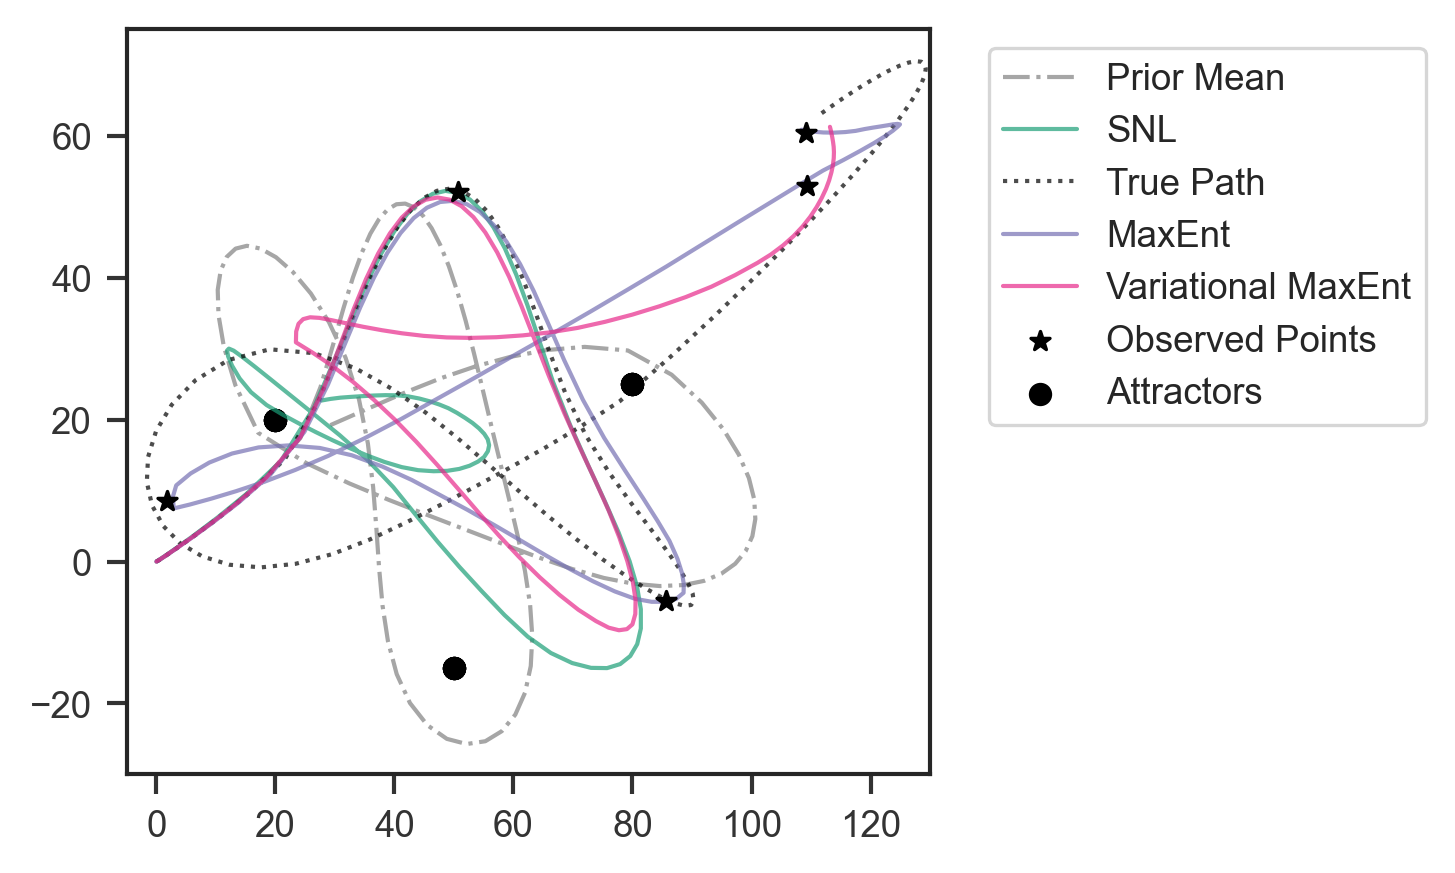

In [117]:
alpha_val = 0.7
fig, axes = plt.subplots(figsize=(5,3), dpi=300)

# plot the observation points
axes.scatter(observed_points[:,0], observed_points[:,1],
             color='black', zorder=10, marker='*', label='Observed Points')

# plot the trajectory generated by prior means
sim.set_traj(prior_means_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greys').reversed(),
              color='grey',
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-.',
              linewidth=1,
              label='Prior Mean')

# plot the SNL mean trajectory
sim.set_traj(mean_snl_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greens').reversed(),
              color=colors[0],
              fade_lines=False,
              linewidth=1,
              alpha=alpha_val,
              label='SNL')

# plot the true trajectory
sim.set_traj(true_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Reds').reversed(),
              color='black',
              fade_lines=False,
              alpha=alpha_val,
              linestyle=':',
              linewidth=1,
              label='True Path',
              label_attractors=False)

# plot the maxent average trajectory
sim.set_traj(maxent_avg_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Oranges').reversed(),
              color=colors[2],
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-',
              linewidth=1,
              label='MaxEnt',
              label_attractors=False)

# plot the maxent average trajectory
sim.set_traj(maxent_variational_avg_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Oranges').reversed(),
              color=colors[3],
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-',
              linewidth=1,
              label='Variational MaxEnt',
              label_attractors=True)

# set limits manually
axes.set_xlim(-5, 130)
axes.set_ylim(-30, 75)

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.))
plt.tight_layout()

plt.savefig('paths_compare.png')
plt.savefig('paths_compare.svg')
plt.show()